# Act 3: Generate from Data

In this notebook, you'll generate new data from existing data. We'll be using AI models to get creative:

🎭 Generate AI prompts based on multimodal inputs (text and images)  
🎬 Create static images from scenes we pull from videos  
🤹🏽 Animate images with text prompts  
🍿 Create videos from image and text prompts

In a typical workflow, this means: loading video files, extracting frames with OpenCV or ffmpeg, encoding images to base64, constructing API requests, managing authentication, parsing JSON responses, handling rate limits and errors, writing batch processing loops, saving outputs to disk, and tracking which items have been processed.

In Pixeltable, we can express this workflow without any explicit data handling. It is still the same work, same conceptual flow, but you don't have to craft the data operations. Instead, you can focus on the logic and Pixeltable handles the rest. 

Because Pixeltable handles all that for us, you might notice we're not covering topics like:
- Request batching
- Response parsing
- Retry strategies
- File serialization
- Media encoding/decoding
- Binary data handling
- State persistence
- Concurrency management

## In this notebook

The techniques you'll learn apply to any workflow that chains transformations and applies them across data. We'll use Pixeltable to:

1. **Extract Frames** - Pull a frame from each video scene
2. **Generate Creative Prompts** - Use multimodal AI to create trailer descriptions from frames and transcripts
3. **Create Visual Content** - Generate images and videos from AI prompts
4. **Apply Across All Scenes** - Run the workflow on your entire scene library automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models and Pixeltable UDFs used in this notebook:**

| Google Model | Pixeltable UDF | Purpose |
|--------------|----------------|----------|
| `gemini-2.0-flash` | `pxtf.gemini.generate_content()` | Generate text descriptions from images |
| `imagen-4.0-generate-001` | `pxtf.gemini.generate_images()` | Generate images from text prompts |
| `veo-3.1-generate-preview` | `pxtf.gemini.generate_videos()` | Generate videos from images and text |

In [1]:
import pixeltable as pxt
import pixeltable.functions as pxtf

As we've been doing, we'll take a look at the tables we can "get":

In [3]:
pxt.list_tables('primetime-workshop')

['primetime-workshop/video-frame-view',
 'primetime-workshop/primetime_vids',
 'primetime-workshop/sentences',
 'primetime-workshop/scene_view']

We'll be working with our `scene_view` table. 

In [5]:
scene_view = pxt.get_table('primetime-workshop/scene_view')

You can uncomment the code below if you have already gone through this notebook and want to start fresh with the state of `scene_view` before adding any generative AI model inputs or outputs.

In [ ]:
#scene_view.drop_column(scene_view.beginning_frame)
#scene_view.drop_column(scene_view.prompt_response)
#scene_view.drop_column(scene_view.prompt_text)

We can also check out the history of our table, to revisit where we've been!

In [6]:
# Your may look different than mine
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,4,2026-01-28 03:54:24.789093+00:00,None,data,101,0,0,0,NaN
1,3,2026-01-28 03:53:07.690538+00:00,None,schema,0,10,0,0,Added: transcript_text
2,2,2026-01-28 03:51:05.783620+00:00,None,schema,0,10,0,0,Added: transcription
3,1,2026-01-28 03:51:00.764533+00:00,None,schema,0,10,0,0,Added: audio
4,0,2026-01-28 03:50:50.962110+00:00,None,schema,10,0,0,0,Initial Version


In addition to viewing table history, you can do time travel, rollback to a previous version, and revert changes. See this page in our docs for more: https://docs.pixeltable.com/platform/version-control

As a reminder, here is our view schema:

In [7]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

You already have `scene_view` from Act 2 with video segments for each scene. Now you'll add a computed column to extract a frame from each segment.

As a reminder, `scene_view` is a view built on top of `primetime_vids`, which means it automatically has access to all the parent table's columns (like `title` and `promo_text`).

Computed columns work on views the same way they work on tables - they're automatically applied to every row:

- `extract_frame()` is a Pixeltable UDF that pulls a single frame at a specific timestamp from each video segment - we used this UDF already in Act 1
- Output frames are stored persistently
- If you add a new row to `primetime_vids`, only those new scenes are processed (incremental updates)

In [8]:
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=5),
    if_exists='replace'
)

Added 18 column values with 0 errors in 1.48 s (12.18 rows/s)


18 rows updated.

Let's look at the frames we just extracted:

pos,video_segment,beginning_frame
5,,
6,,
7,,

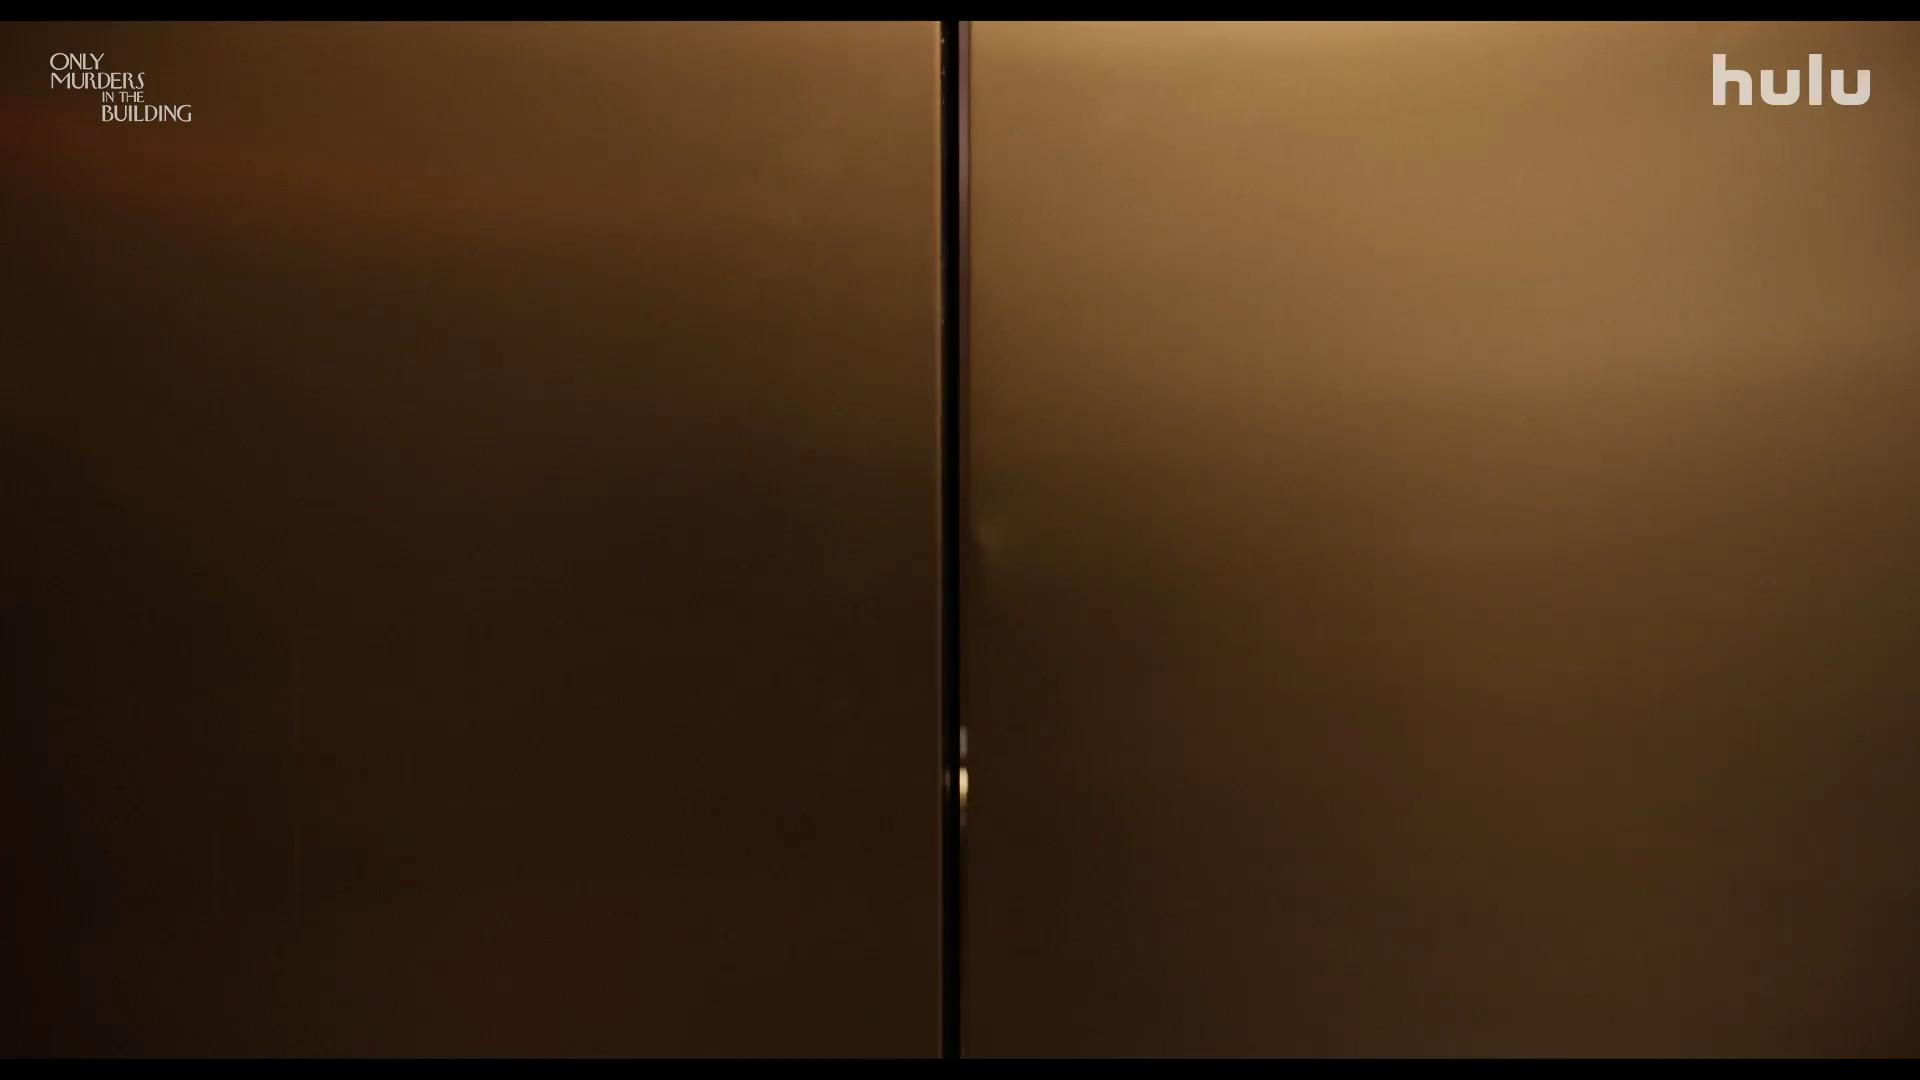
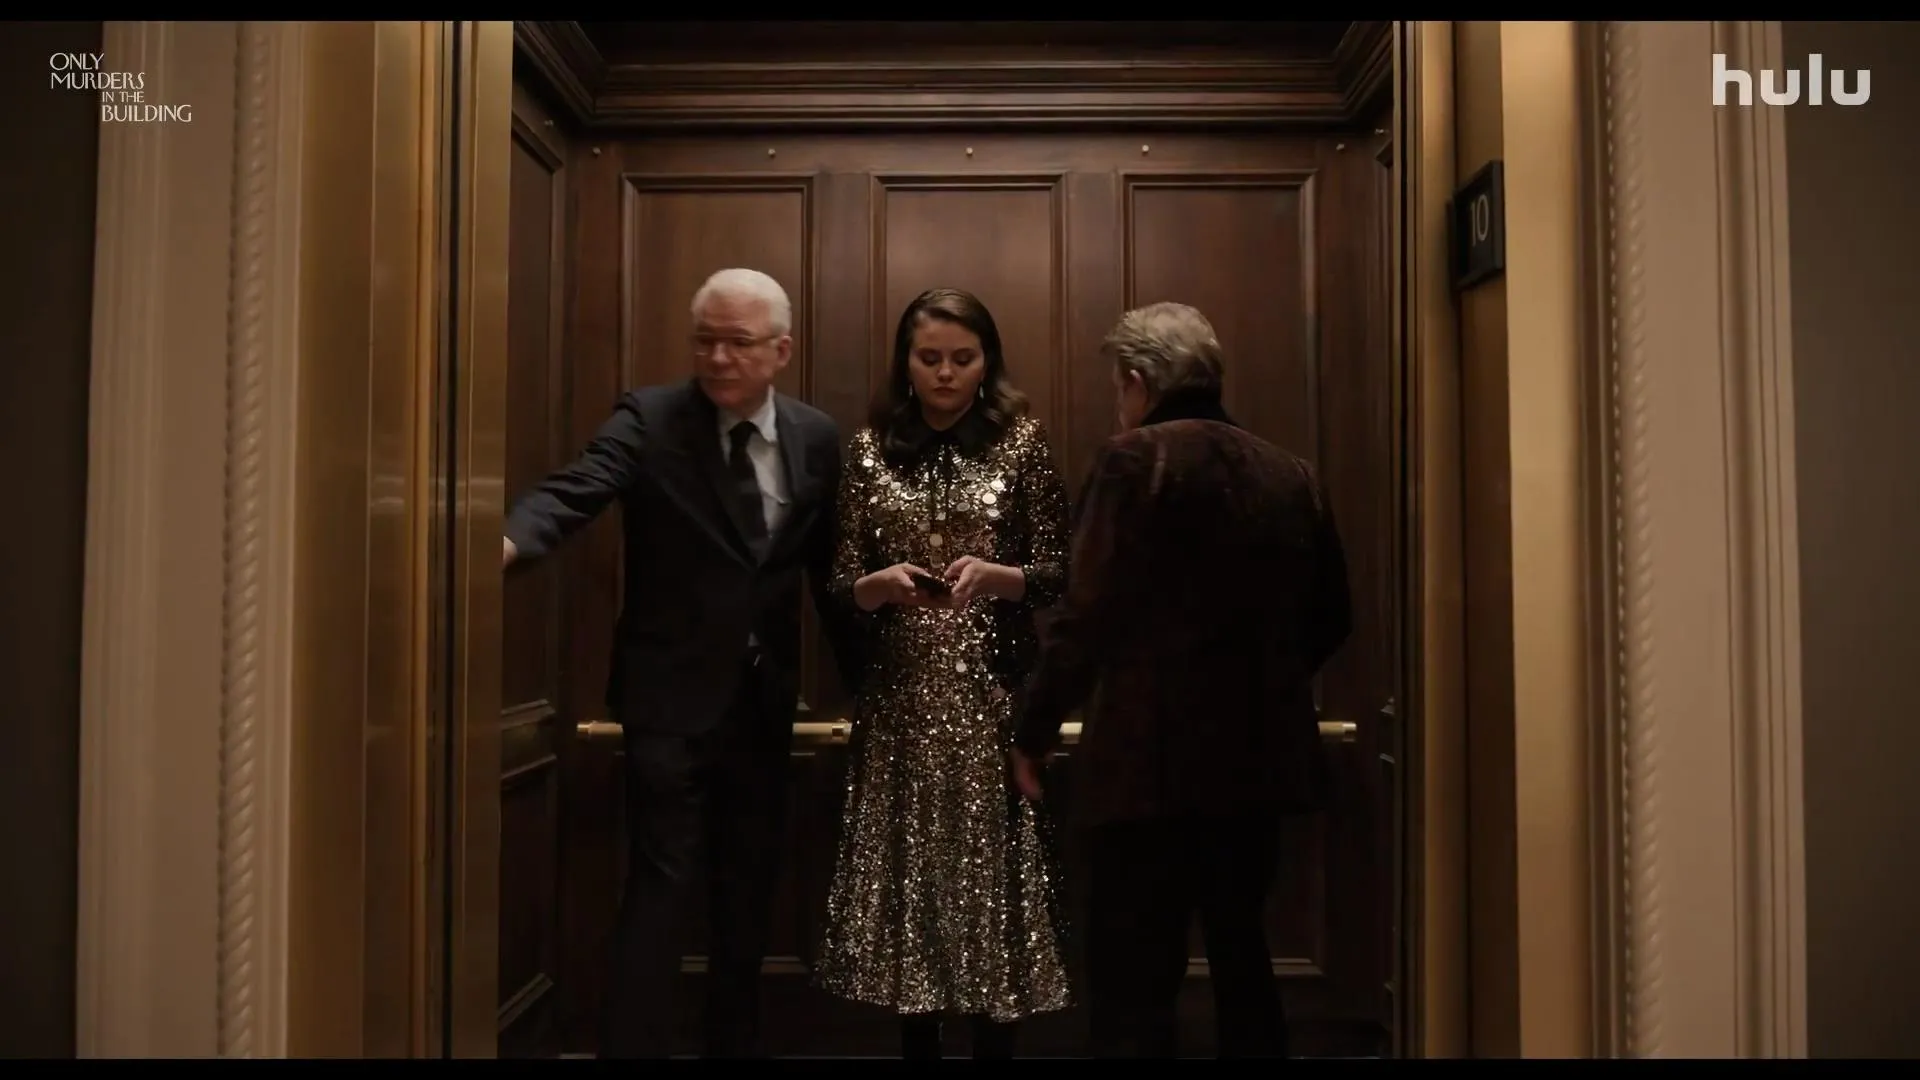
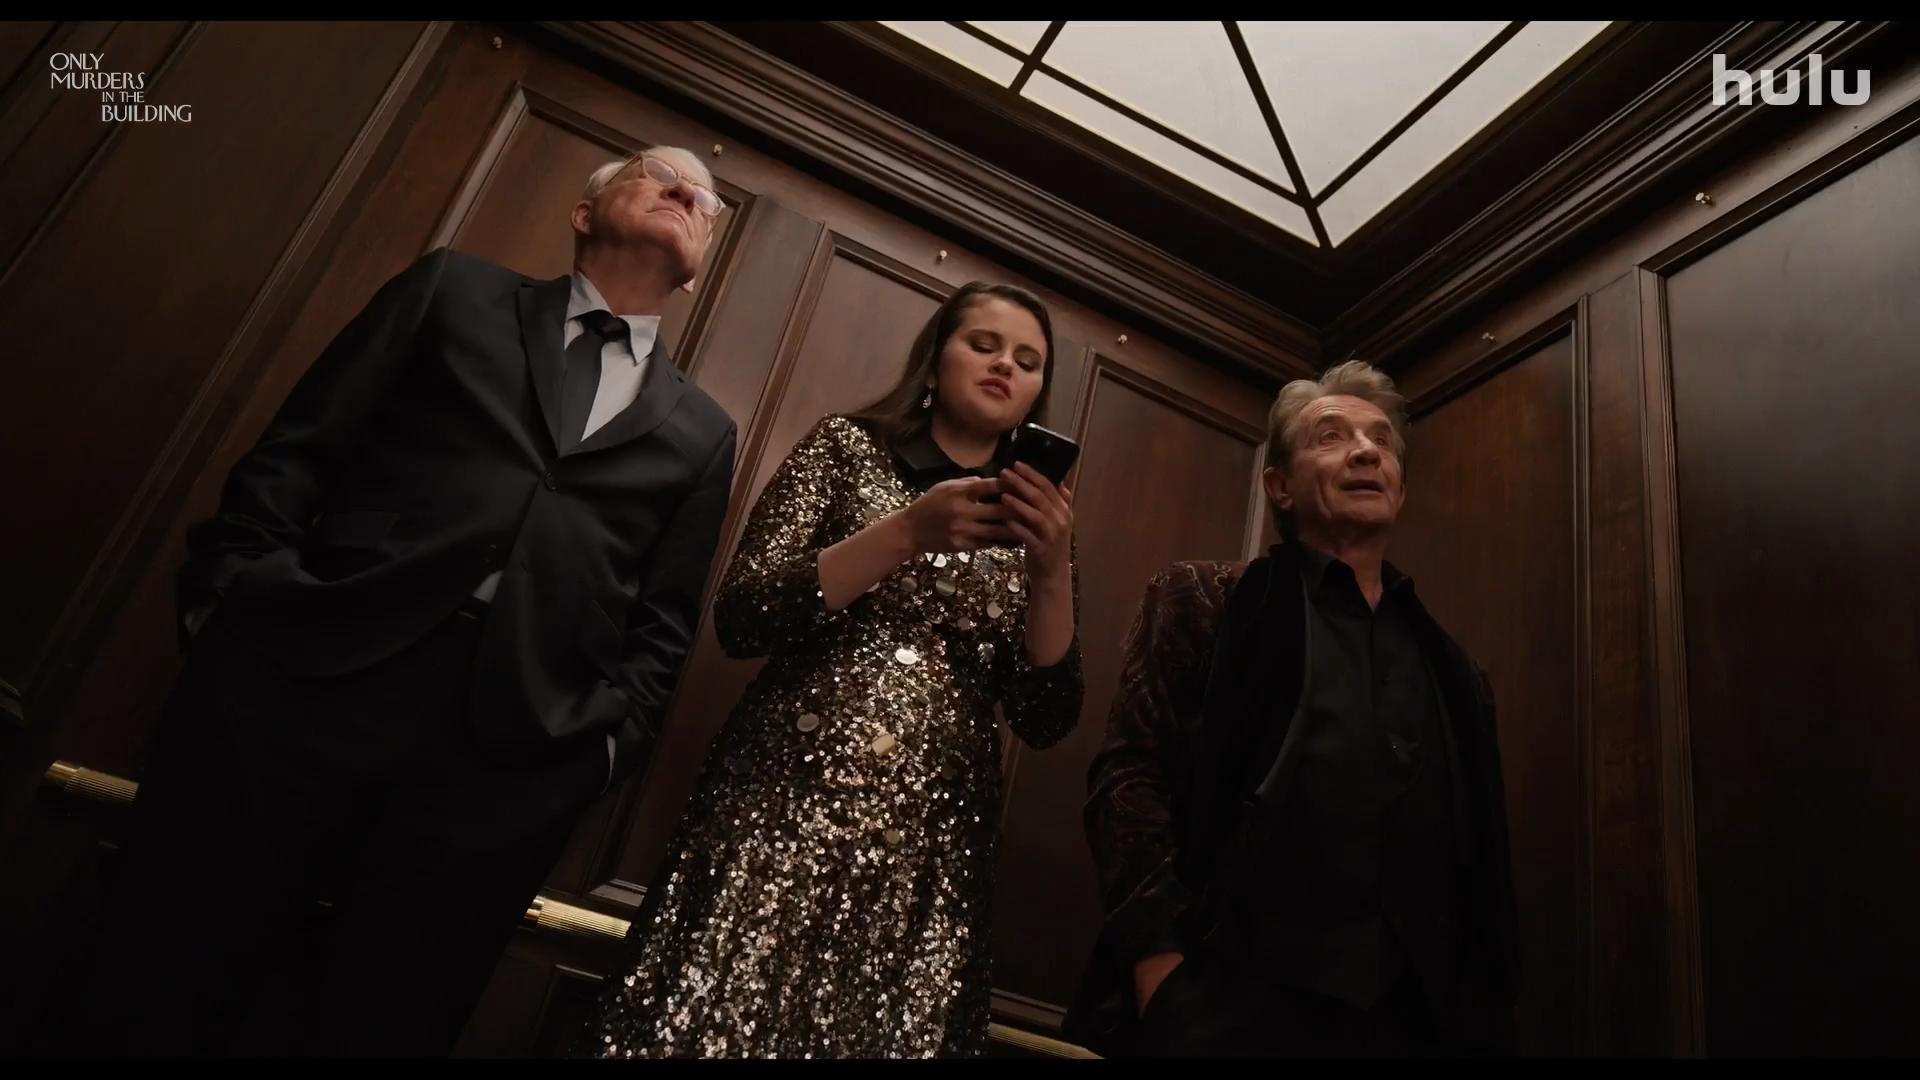
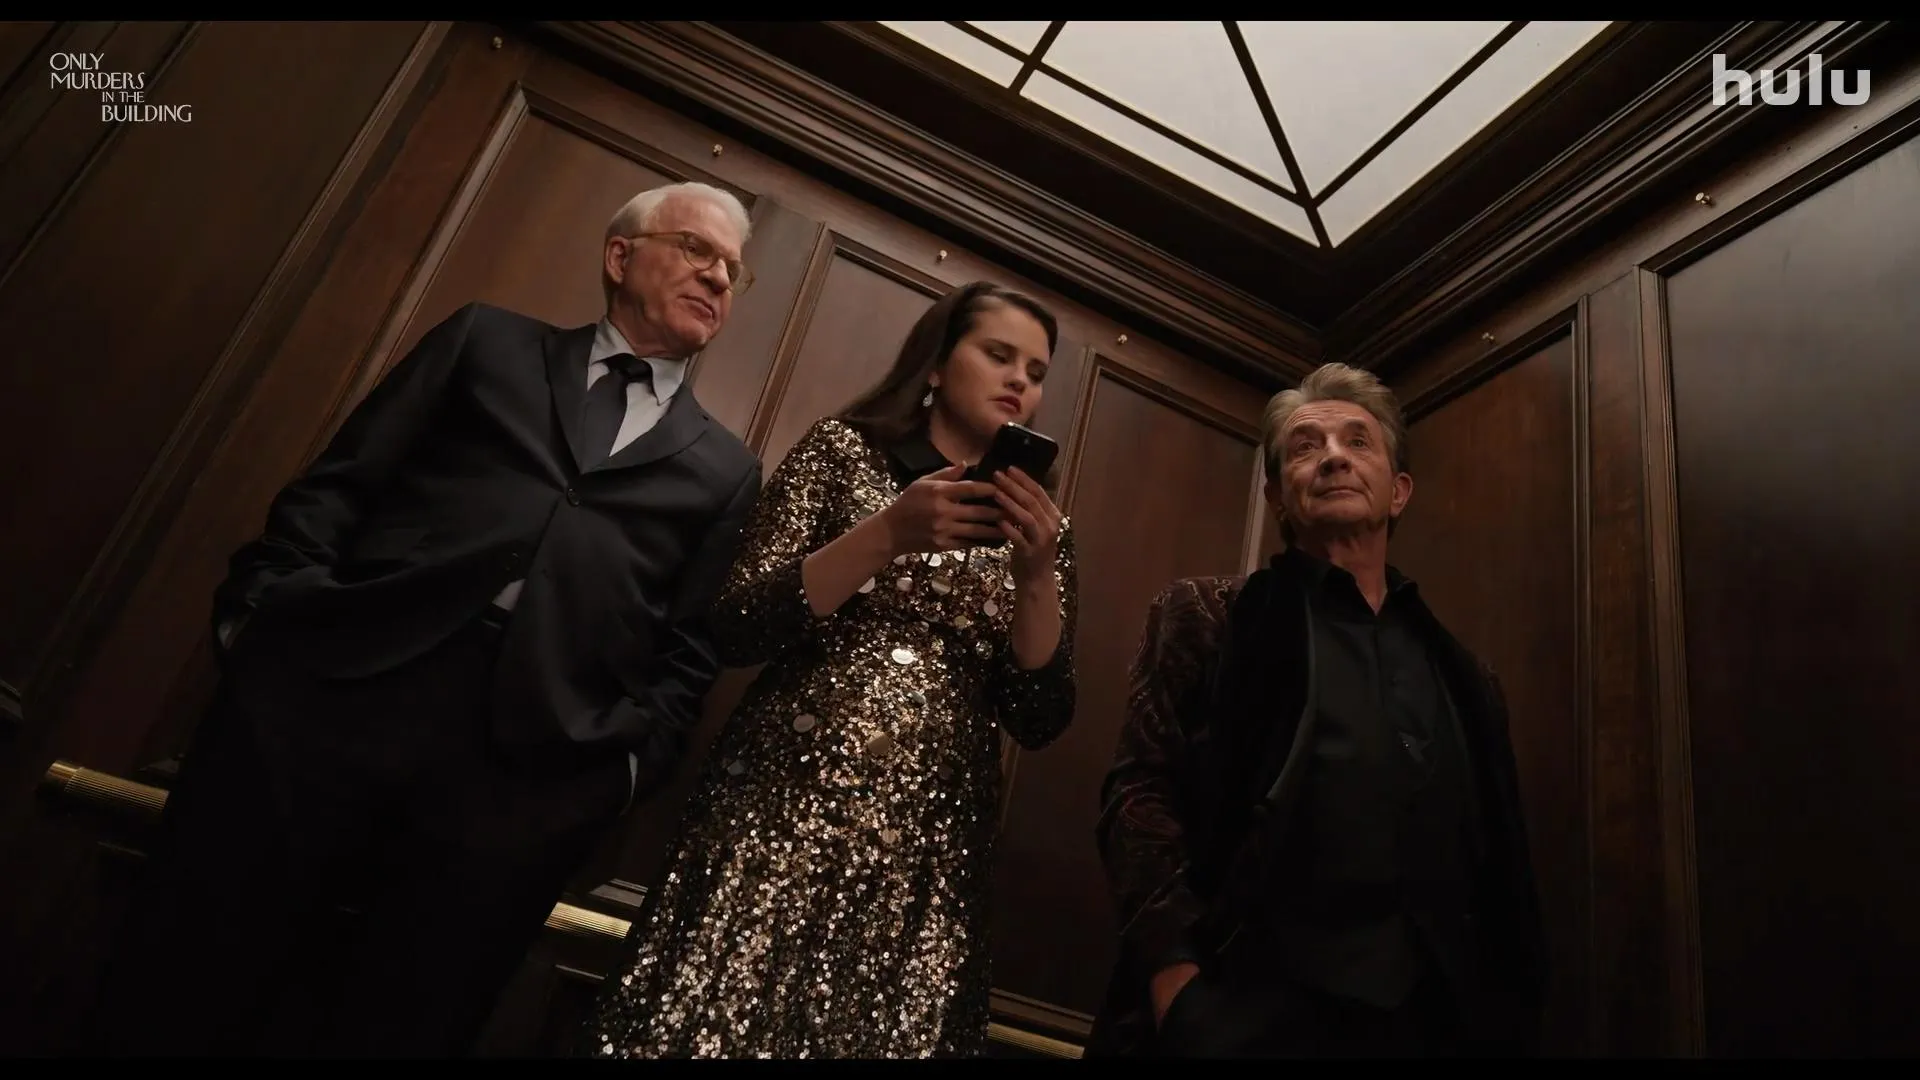
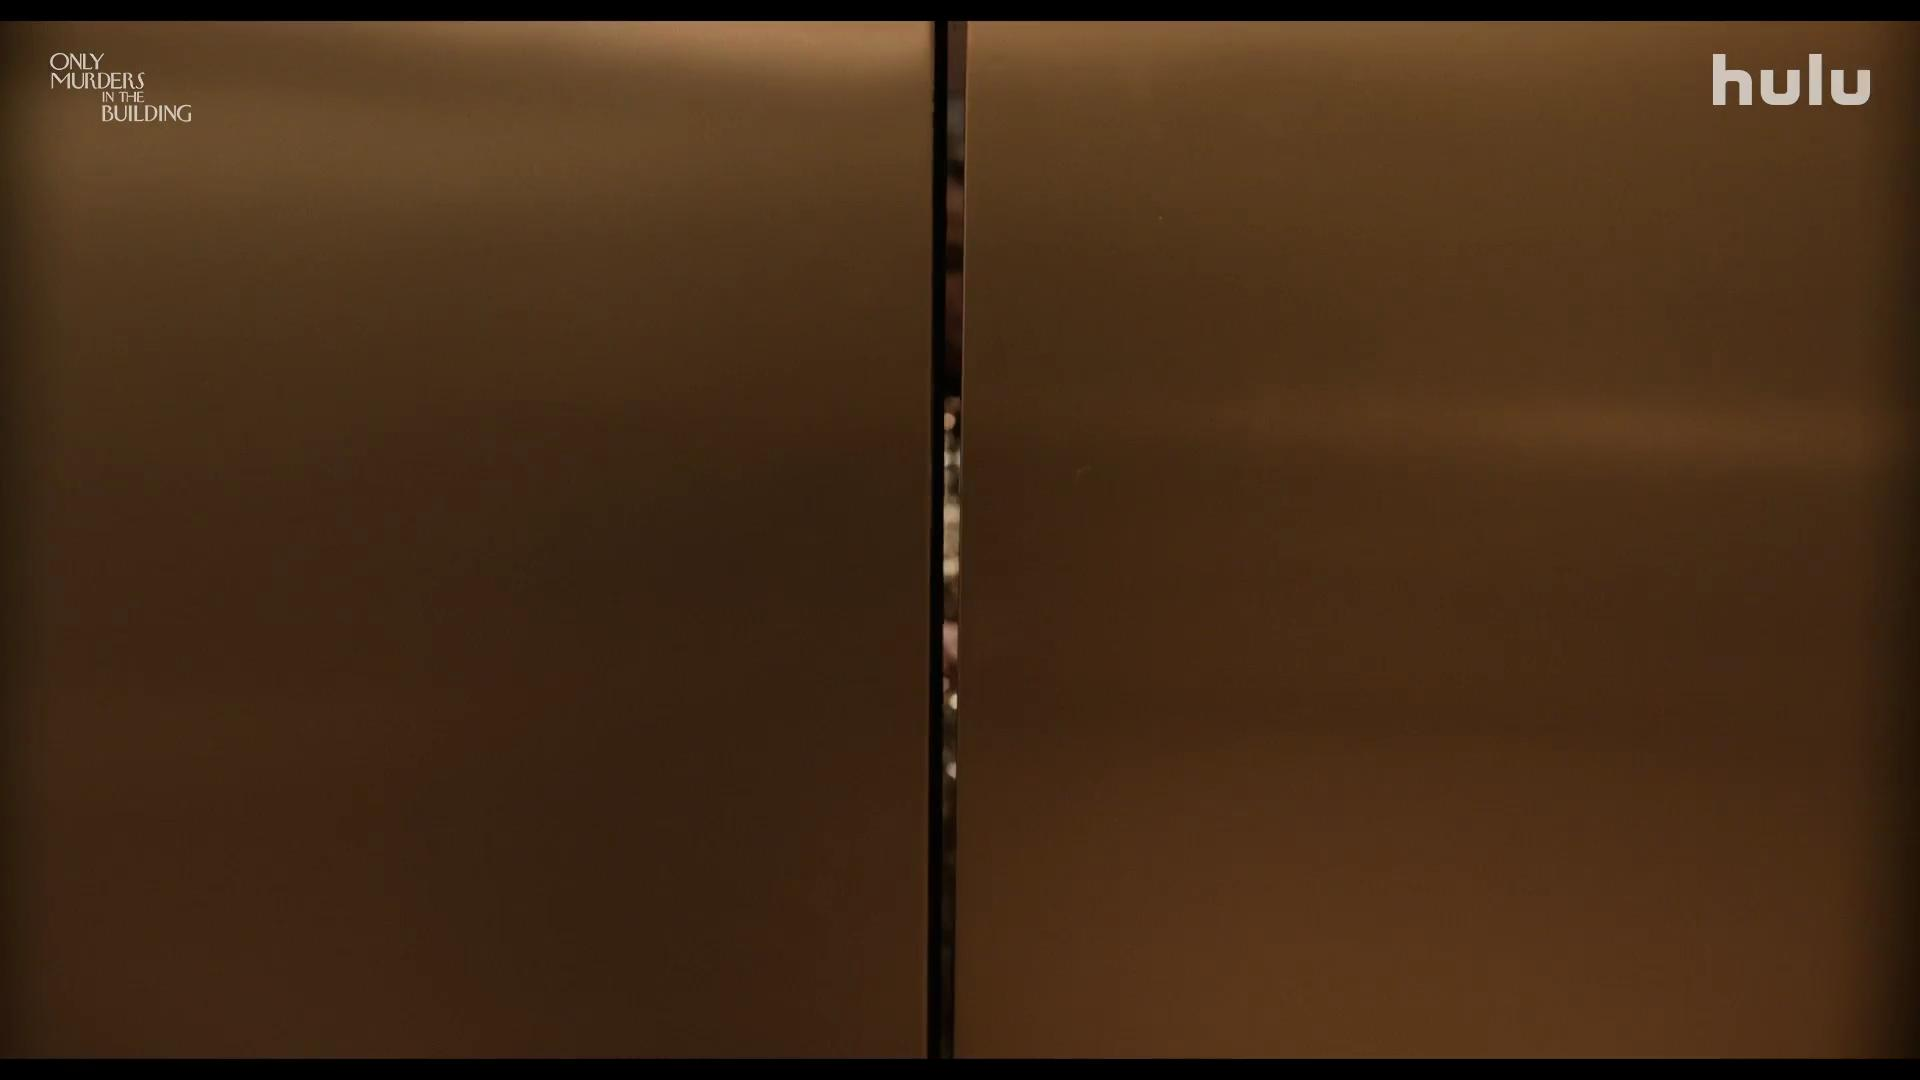
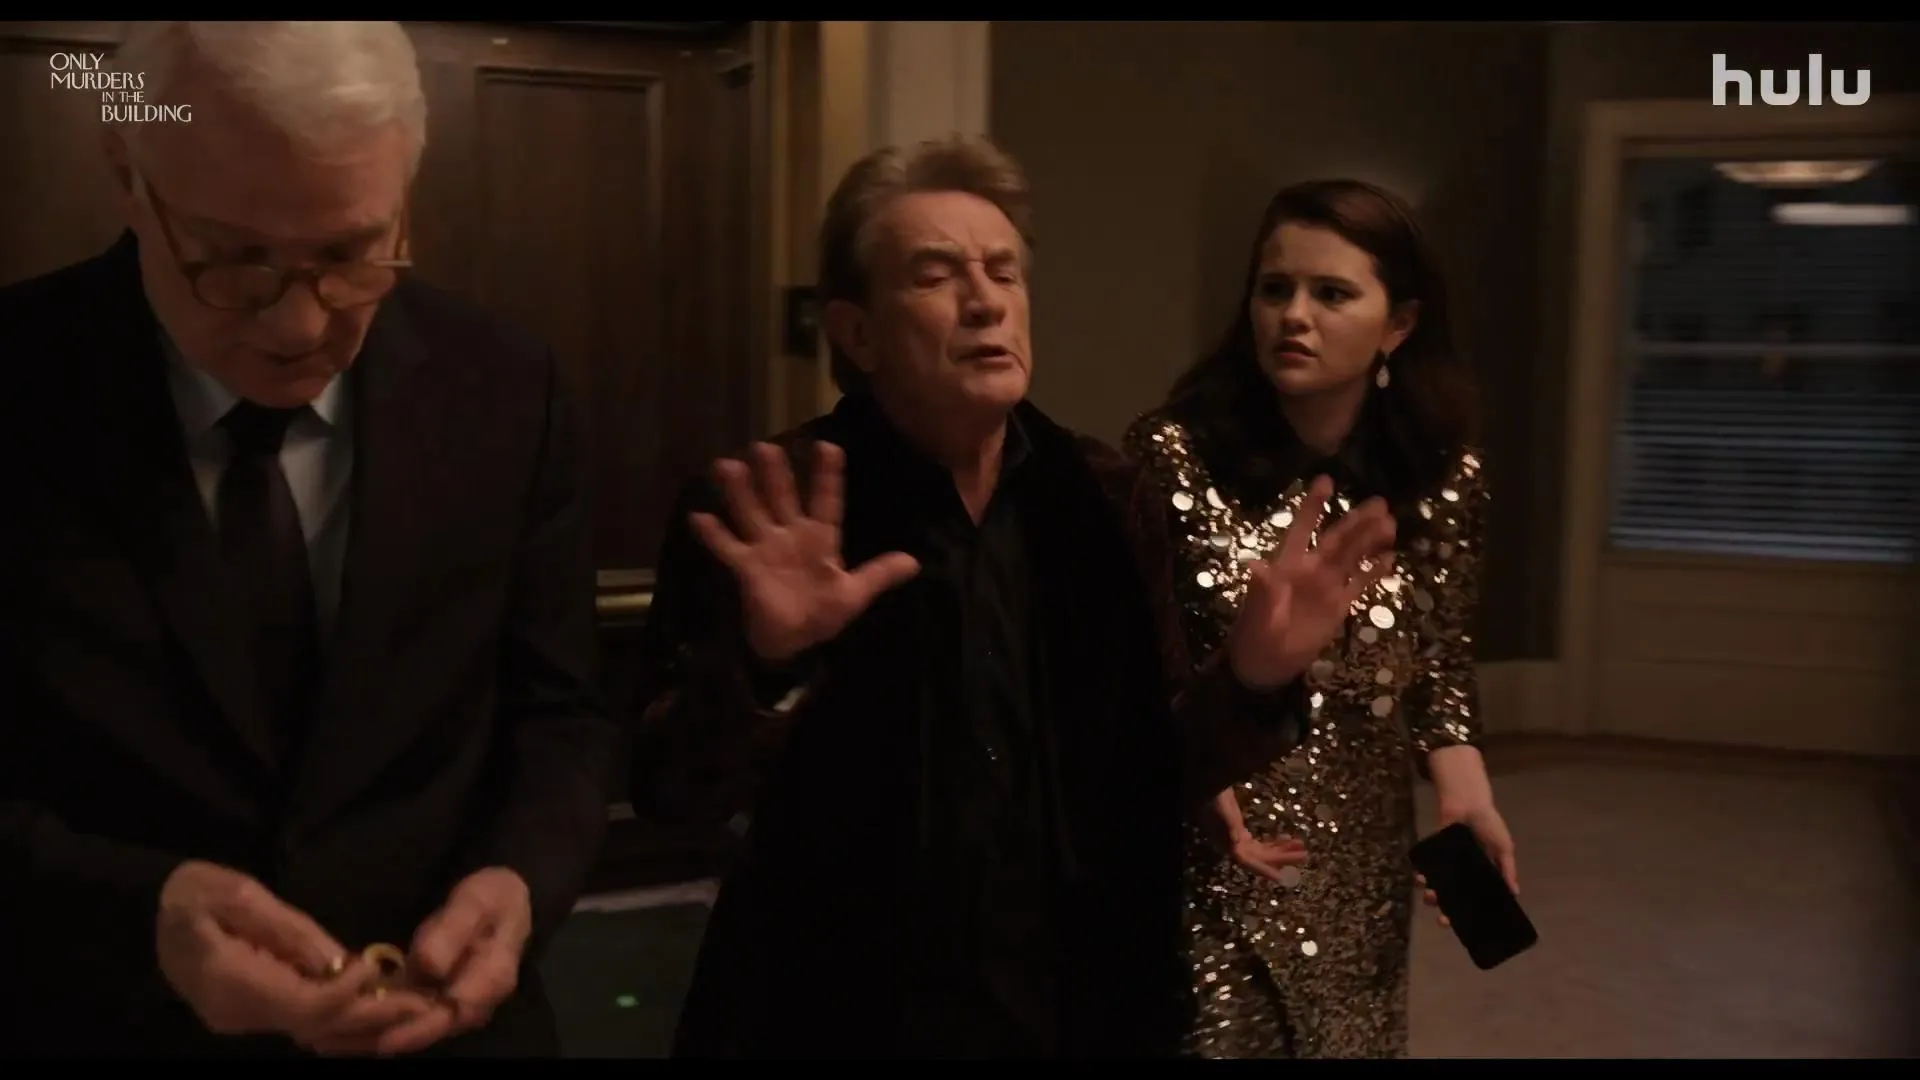

In [9]:
scene_view.select(scene_view.pos, scene_view.video_segment, scene_view.beginning_frame).tail(3)

## 02 - Build Scene Prompts

Now let's generate scene descriptions that we can use to create images and videos. We'll write two custom UDFs (User-Defined Functions):

1. **`build_scene_prompt()`** - Composes a text prompt using movie info (title, plot, transcript) and a prompt template
2. **`extract_text()`** - Extracts the generated text from Gemini's JSON output

Here's the workflow:

1. `build_scene_prompt()` composes the text prompt (no AI needed here)
2. We pass the text prompt + frame image to Gemini
3. Gemini returns a JSON response with the scene description
4. `extract_text()` extracts the text from the JSON

The prompt template in `build_scene_prompt()` follows best practices from Google's [guide to prompting Gemini for image generation](https://developers.googleblog.com/en/how-to-prompt-gemini-2-5-flash-image-generation-for-the-best-results/), which emphasizes describing scenes narratively with specific details about lighting, camera angles, and mood.

In [10]:
@pxt.udf
def build_scene_prompt(
    title: str,
    promo_text: str, 
    transcript_text: str,
    content_type: str = 'image'
) -> str:
    """Build the text prompt for Gemini to generate scene descriptions.
    
    Args:
        title: Movie title
        promo_text: Movie plot description
        transcript_text: Scene transcript
        content_type: Either 'image' or 'video' to customize the prompt
    """
    # Add video-specific instruction if generating video
    video_or_image_style = (
        'animated in a stop-motion claymation style with subtle, handcrafted movements. '
        if content_type == 'video' 
        else 'photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. '
    )
    
    return (
        'You are creating a miniature diorama scene. '
        f'Movie: "{title}". '
        f'Plot: {promo_text}. '
        f'This frame shows a key moment where: {transcript_text}. '
        f'Create a detailed prompt for {"a video" if content_type == "video" else "an image"} generator following this structure: '
        'An intricate miniature diorama of [describe the scene], '
        f'{video_or_image_style}'
        'Describe the shot type, lighting (emphasize dramatic miniature lighting), '
        'tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. '
        'The scene should feel both cinematic and charmingly handmade. '
        'Write only the prompt, no preamble or explanation. '
        f'Do not include text, typography, or words in the {content_type}.'
    )

In [11]:
# Build the text prompt for each scene
scene_view.add_computed_column(
    prompt_text=build_scene_prompt(
        scene_view.title,
        scene_view.promo_text,
        scene_view.transcript_text
    ),
    if_exists='replace'
)

Added 18 column values with 0 errors in 0.16 s (112.68 rows/s)


18 rows updated.

In [12]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    beginning_frame            Image           video_segment.extract_frame(timestamp=5)
        prompt_text           String  build_scene_prompt(title, promo_text, transcri...
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

So we have `prompt_text` as a new column in our view schema. Let's look at two of them:

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?. Create a detailed prompt for an imag ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

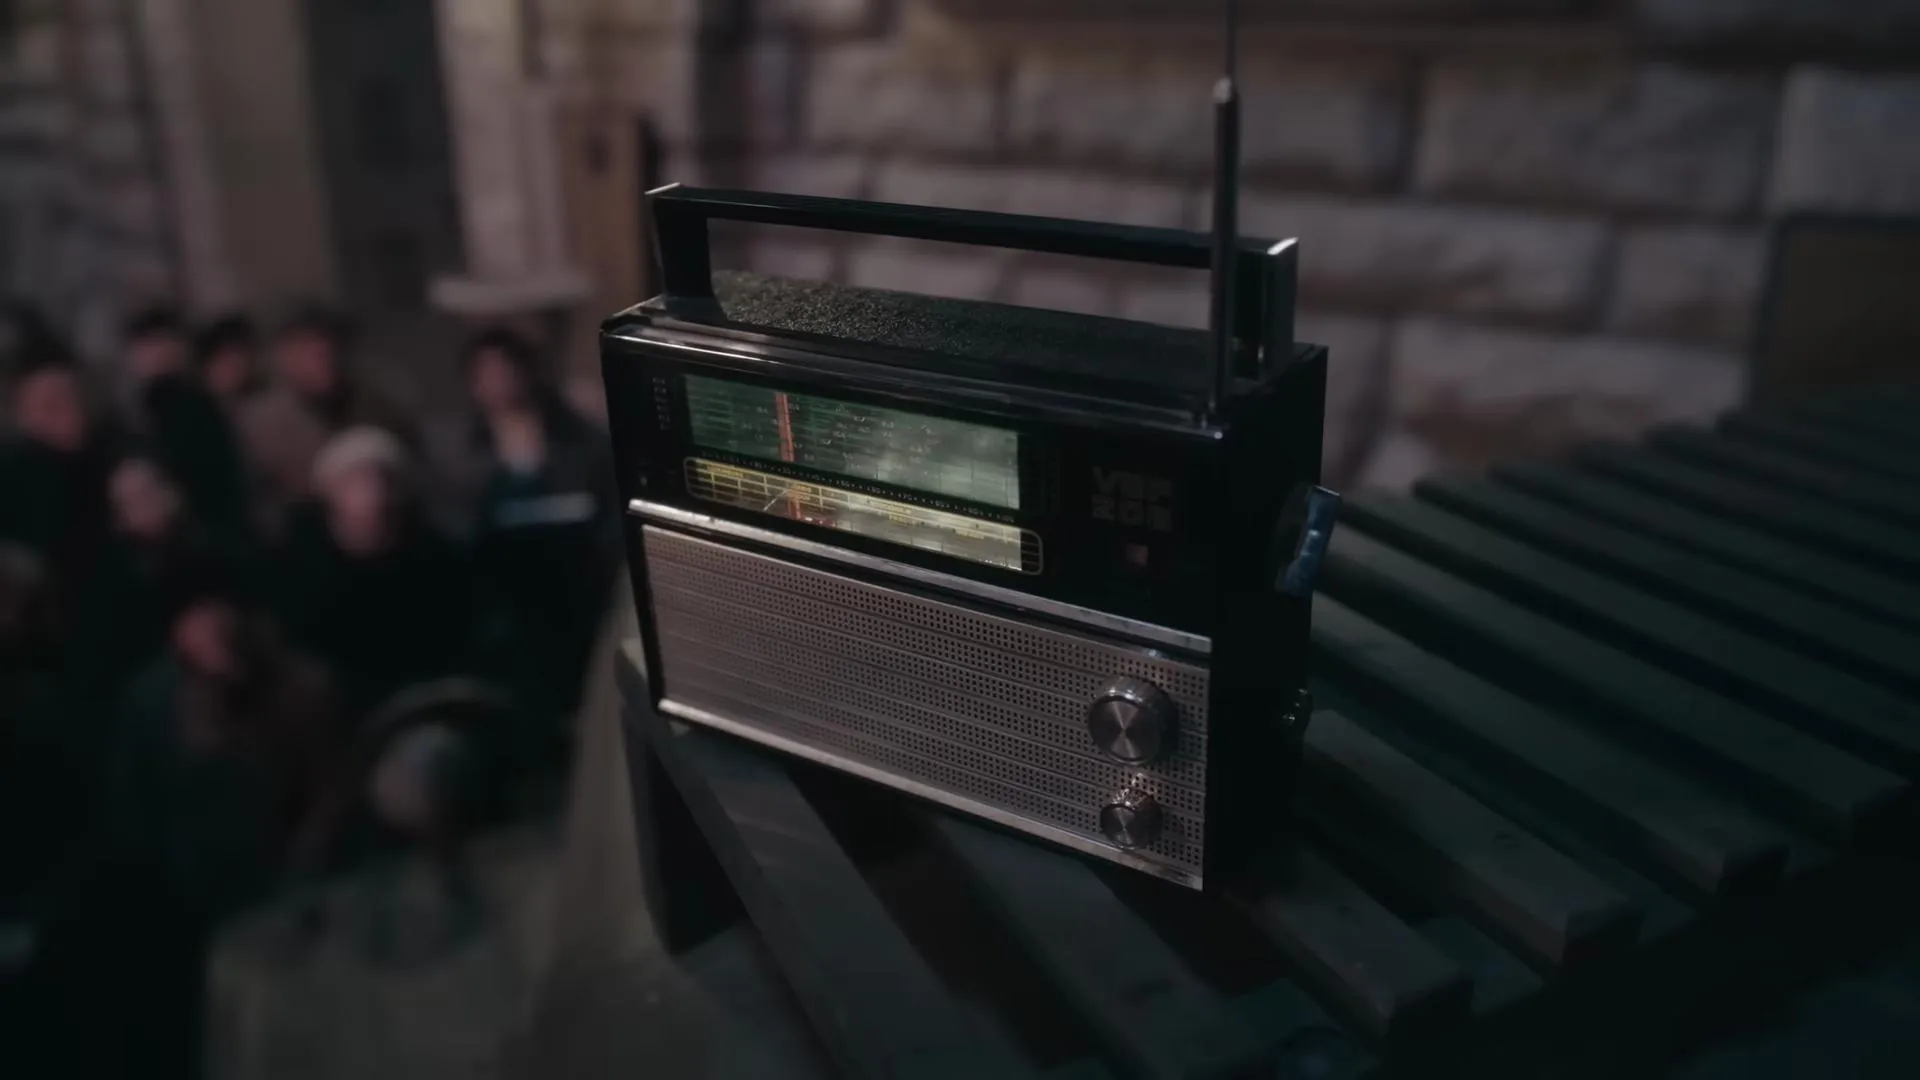

In [13]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).head(1)

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

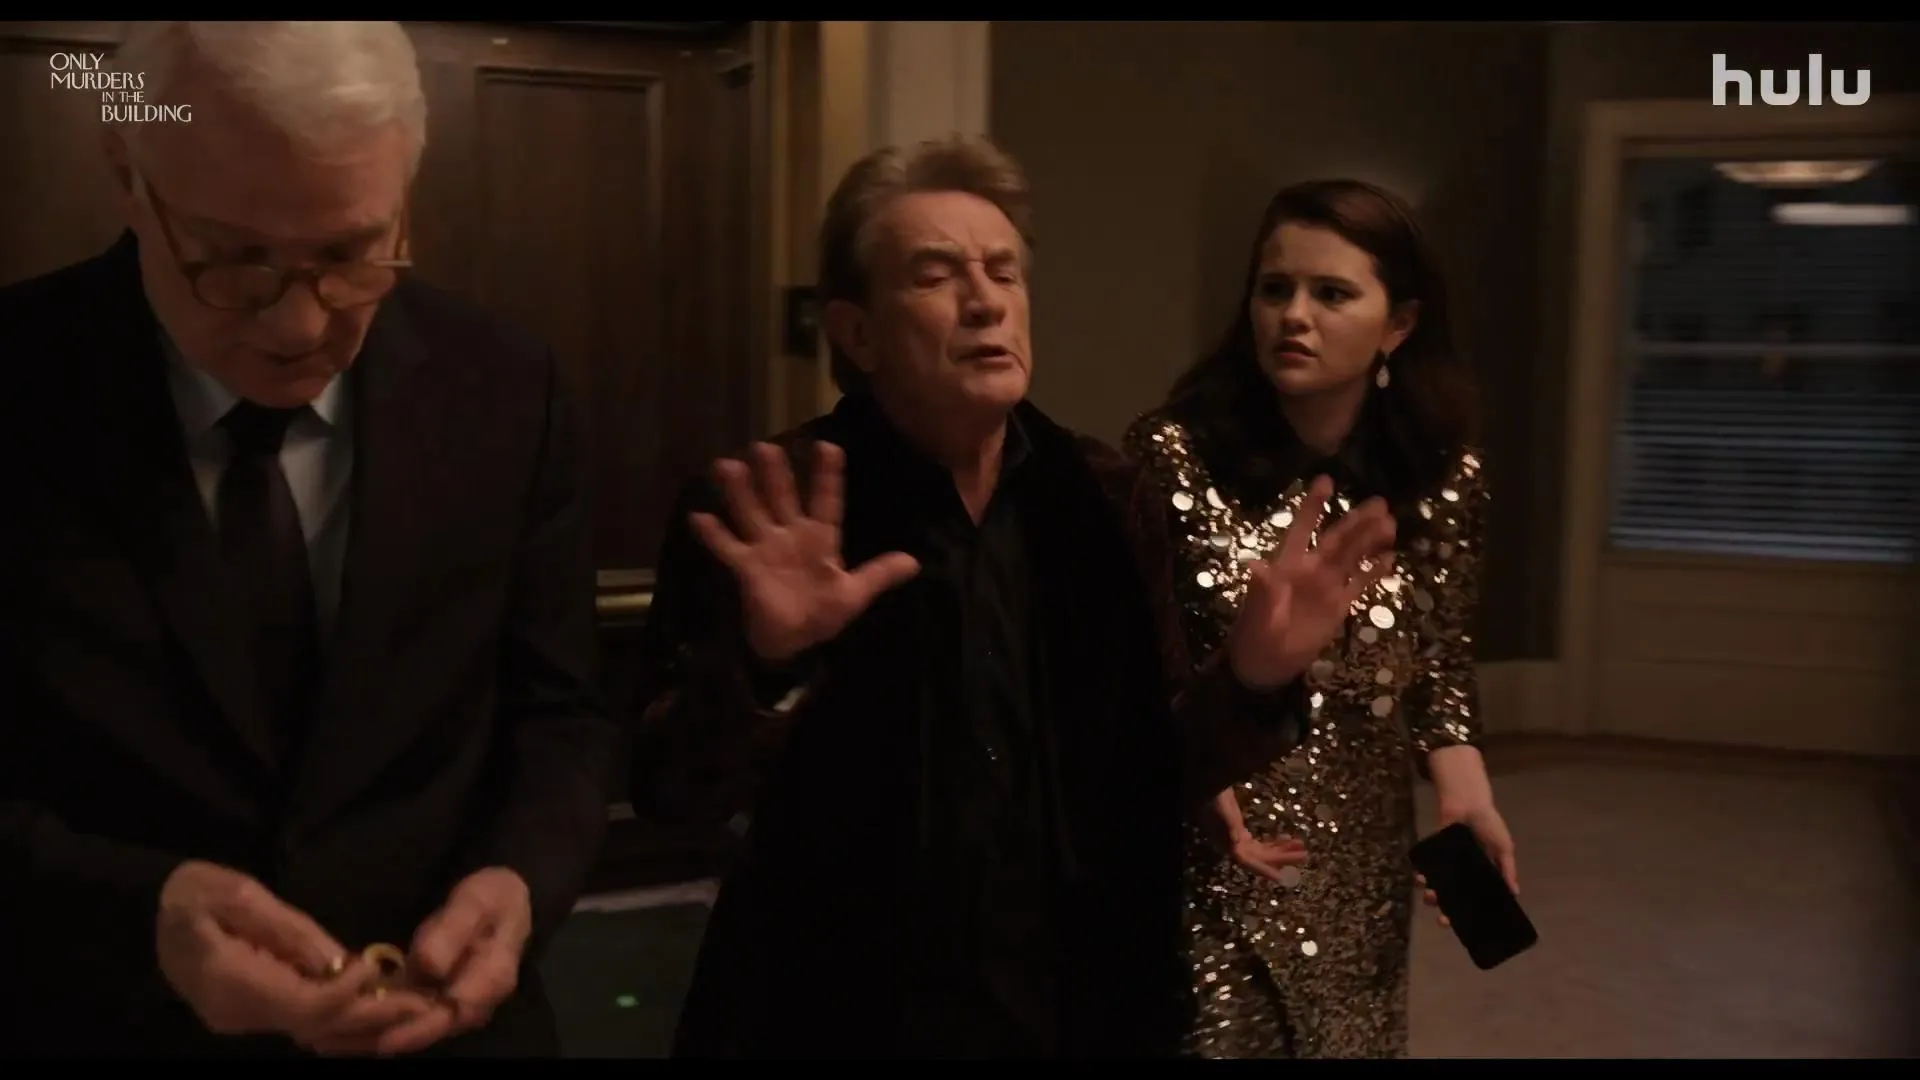

In [14]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).tail(1)

## 03 - Generate AI Prompts

Now we'll actually use these text prompts to generate scene prompts for AI image/video models. 

Recall from Act 01 that writing a query using `select()` does not change the underlying table - you can think of this like a purely "in memory" operation that is great for experimentation and transparency in your workflow. But in this chunk we are calling the Gemini model:

beginning_frame,prompt_text,scene_prompt
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: You're gonna miss the flood? Come on. Come on. Lisa, come on.. Create a detailed prompt for an image generator following this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image.","{""sdk_http_response"": {""headers"": {""Content-Type"": ""application/json; charset=UTF-8"", ""Vary"": ""Origin, X-Origin, Referer"", ""Content-Encoding"": ""gzip"", ""Date"": ""Wed, 28 Jan 2026 03:58:08 GMT"", ""Server"": ""scaffolding on HTTPServer2"", ""X-XSS-Protection"": ""0"", ""X-Frame-Options"": ""SAMEORIGIN"", ""X-Content-Type-Options"": ""nosniff"", ""Server-Timing"": ""gfet4t7; dur=3041"", ""Alt-Svc"": ""h3=\"":443\""; ma=2592000,h3-29=\"":443\""; ma=2592000"", ""Transfer-Encoding"": ""chunked""}, ""body"": null}, ""candidates"": [{""content"": {""parts"": [{""media_resolution"": null, ""code_execution_result"": null, ""executable_code"": null, ""file_data"": null, ""function_call"": null, ""function_response"": null, ""inline_data"": null, ""text"": ""An intricate miniature diorama of Beth Harmon, dressed in all white, standing in front of a large black Soviet car on a Cold War Berlin street. A ...... blacks with a hint of red from her hair. The mood is cinematic, charmingly handmade, and hints at both the beauty and loneliness of her journey.\n"", ""thought"": null, ""thought_signature"": null, ""video_metadata"": null}], ""role"": ""model""}, ""citation_metadata"": null, ""finish_message"": null, ""token_count"": null, ""finish_reason"": ""STOP"", ""avg_logprobs"": -0.861, ""grounding_metadata"": null, ""index"": null, ""logprobs_result"": null, ""safety_ratings"": null, ""url_context_metadata"": null}], ""create_time"": null, ""model_version"": ""gemini-2.0-flash"", ""prompt_feedback"": null, ""response_id"": ""TYl5aYDeH6C-_uMPhd2EuQg"", ""usage_metadata"": {""cache_tokens_details"": null, ""cached_content_token_count"": null, ""candidates_token_count"": 200, ""candidates_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 200}], ""prompt_token_count"": 1988, ""prompt_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 182}, {""modality"": ""IMAGE"", ""token_count"": 1806}], ""thoughts_token_count"": null, ""tool_use_prompt_token_count"": null, ""tool_use_prompt_tokens_details"": null, ""total_token_count"": 2188, ""traffic_type"": null}, ""automatic_function_calling_history"": [], ""parsed"": null}"
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. W
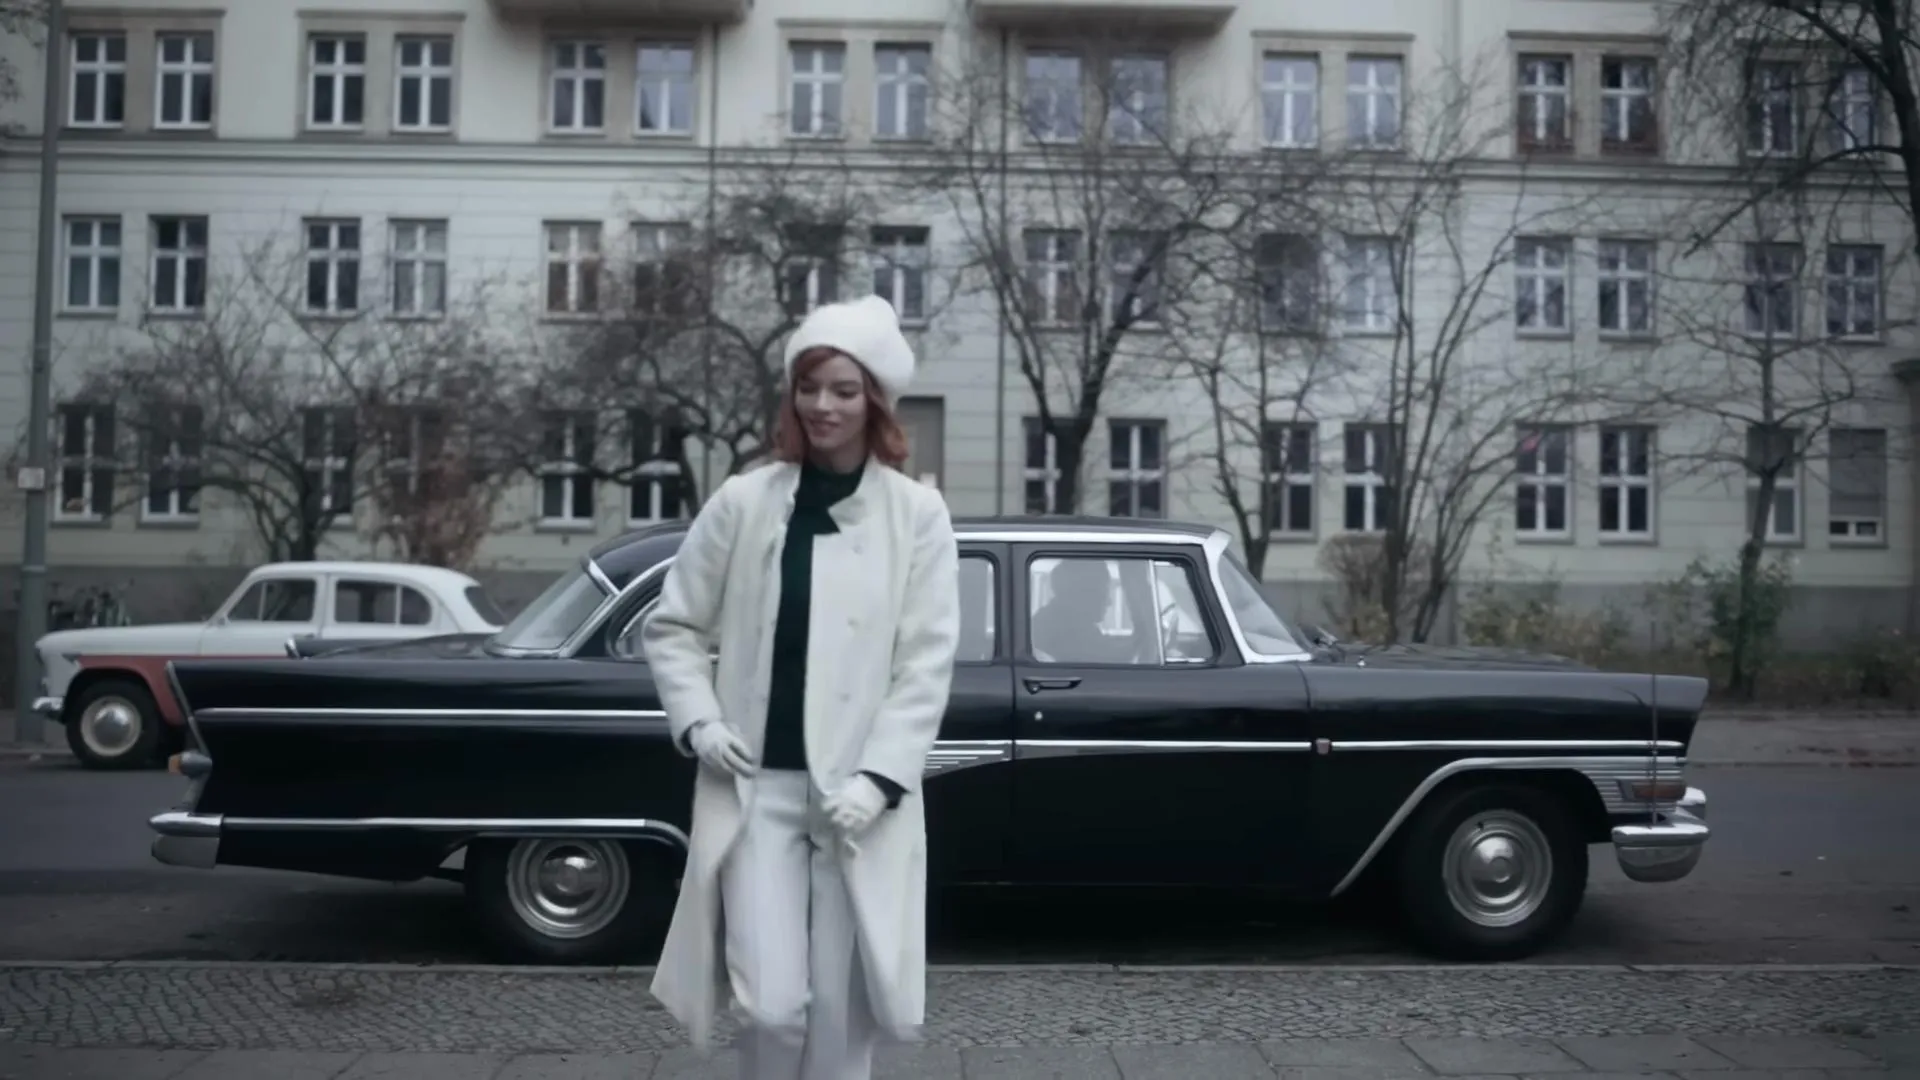
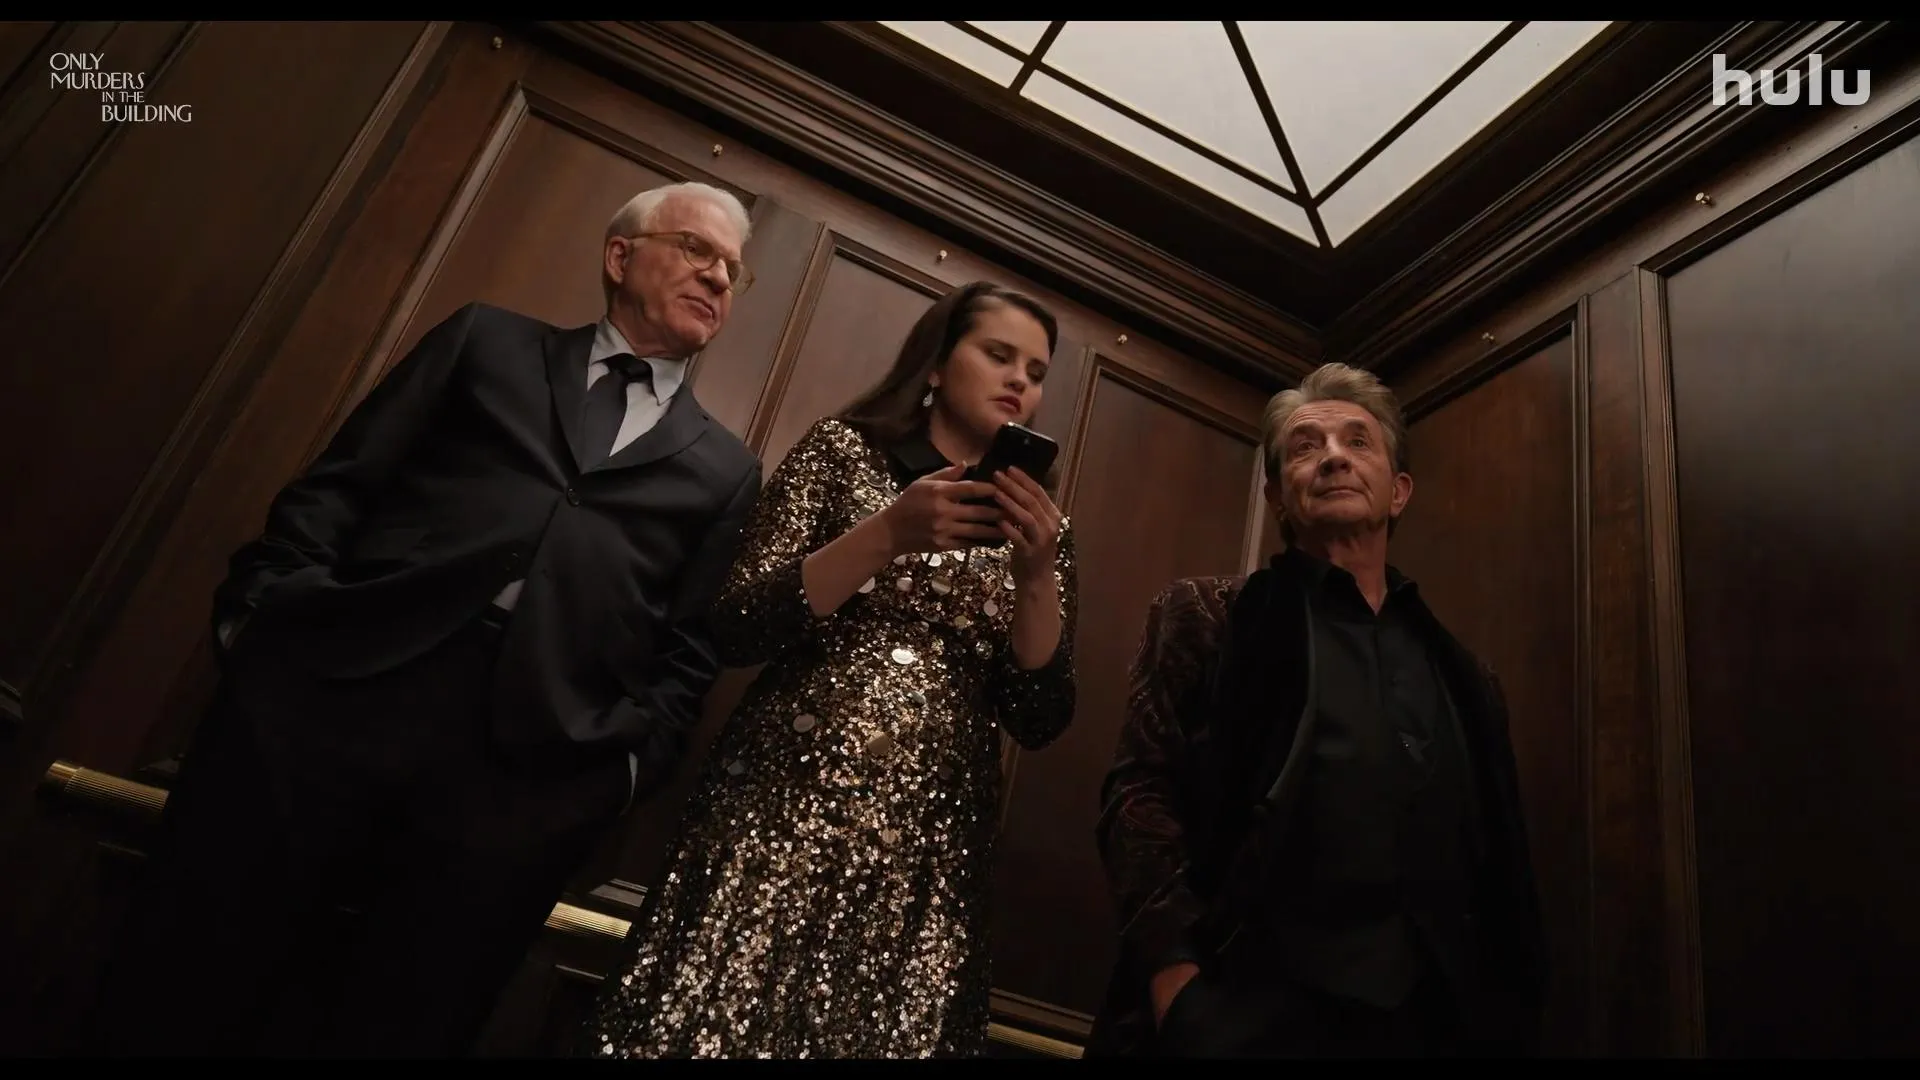

In [15]:
# Test on a single scene
scene_view.where(scene_view.pos == 6).select(
    scene_view.beginning_frame,
    scene_view.prompt_text,
    scene_prompt=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    )
).collect()

You can see that Gemini returns JSON output that needs to be parsed, because we only want the text. We are going to fast-forward through this by writing a UDF to extract the text we need.

In [16]:
@pxt.udf
def extract_text(response: dict) -> str:
    """Extract the generated text from Gemini's response."""
    return response['candidates'][0]['content']['parts'][0]['text']

So now we've called the Gemini API for two scenes (one from each video). Our view table remains unchanged:

In [17]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    beginning_frame            Image           video_segment.extract_frame(timestamp=5)
        prompt_text           String  build_scene_prompt(title, promo_text, transcri...
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

Now let's add our AI-generated scene prompt as a computed column, and extract just the text we need from the Gemini response.

- This calls the Gemini API for each scene and saves the output in a column in our table persistently. 
- This will take longer (>1 minute) to generate the output because we are generating across all rows in our table. 
- We use our `extract_text` UDF to parse the response as another computed column (that depends on `prompt_response`)

In [18]:
scene_view.add_computed_column(
    prompt_response=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    ), if_exists='replace')

scene_view.add_computed_column(
    scene_prompt=extract_text(scene_view.prompt_response),
    if_exists='replace'
)

Added 18 column values with 0 errors in 5.40 s (3.33 rows/s)
Added 18 column values with 0 errors in 0.03 s (674.30 rows/s)


18 rows updated.

In [19]:
scene_view

view 'primetime-workshop/scene_view' (of 'primetime-workshop/primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    beginning_frame             Image           video_segment.extract_frame(timestamp=5)
        prompt_text            String  build_scene_prompt(title, promo_text, transcri...
    prompt_response    Required[Json]  generate_content(contents=[prompt_text, beginn...
       scene_prompt  Required[String]                      extract_text(prompt_response)
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

beginning_frame,scene_prompt
,"An intricate miniature diorama of Beth Harmon, in a climactic chess tournament scene, surrounded by blurred figures representing the audience, her expression intensely focused as she brings her hands together in contemplation. The diorama is photographed with a tilt-shift lens creating selective focus on Beth, and a dreamlike toy-world atmosphere. Medium shot, dramatic miniature lighting from above casting long shadows, tiny handcrafted details on her white coat and beret, and the audience's suits, made from felt, clay, and wood. The color palette is muted grays, creams, and reds, with a somber mood. The scene should feel both cinematic and charmingly handmade."
,"An intricate miniature diorama of a pivotal scene from ""The Queen's Gambit,"" focusing on a vintage Soviet radio on a wooden xylophone. The radio is black, with a silver grill and chrome knobs, the xylophone is in dark green. Behind it, blurred by tilt-shift, is a crowd of tiny onlookers in a dark room. The shot is a medium close-up, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Dramatic miniature lighting highlights the radio's details, with a single spotlight emphasizing the reflection on the silver grill. Tiny handcrafted details include meticulously sculpted miniature faces in the crowd, minuscule radio dials, and visible wood grain on the xylophone keys. Primary materials are felt for the background crowd, clay for the miniature figures, and meticulously carved wood for the xylophone. The color palette is muted, with dark greens, grays, and blacks contrasted by the chrome accents. The mood is tense, quiet, and expectant."
,"An intricate miniature diorama of an outdoor chess scene in Moscow during the Cold War, inspired by ""The Queen's Gambit."" An elderly man in a black coat and tweed cap, sculpted from clay, reaches out his hand in greeting, a warm smile on his tiny face. Behind him, two men are seated at a miniature chess table crafted from wood, pieces meticulously arranged. Background shows a building with detailed window frames and architectural details. Photographed with a tilt-shift lens creating selectiv ...... nd building softened. Dramatic miniature lighting, a single warm spotlight highlighting the man's face, casting long, soft shadows. Tiny handcrafted details include felt scarves and minuscule buttons on the coats, cobblestone street made of painted clay. Color palette: muted grays, browns, and hints of red in the storefront details, creating a melancholic yet charming atmosphere. Mood: a heartwarming moment of camaraderie amid a stark and cold environment, cinematic and charmingly handmade."

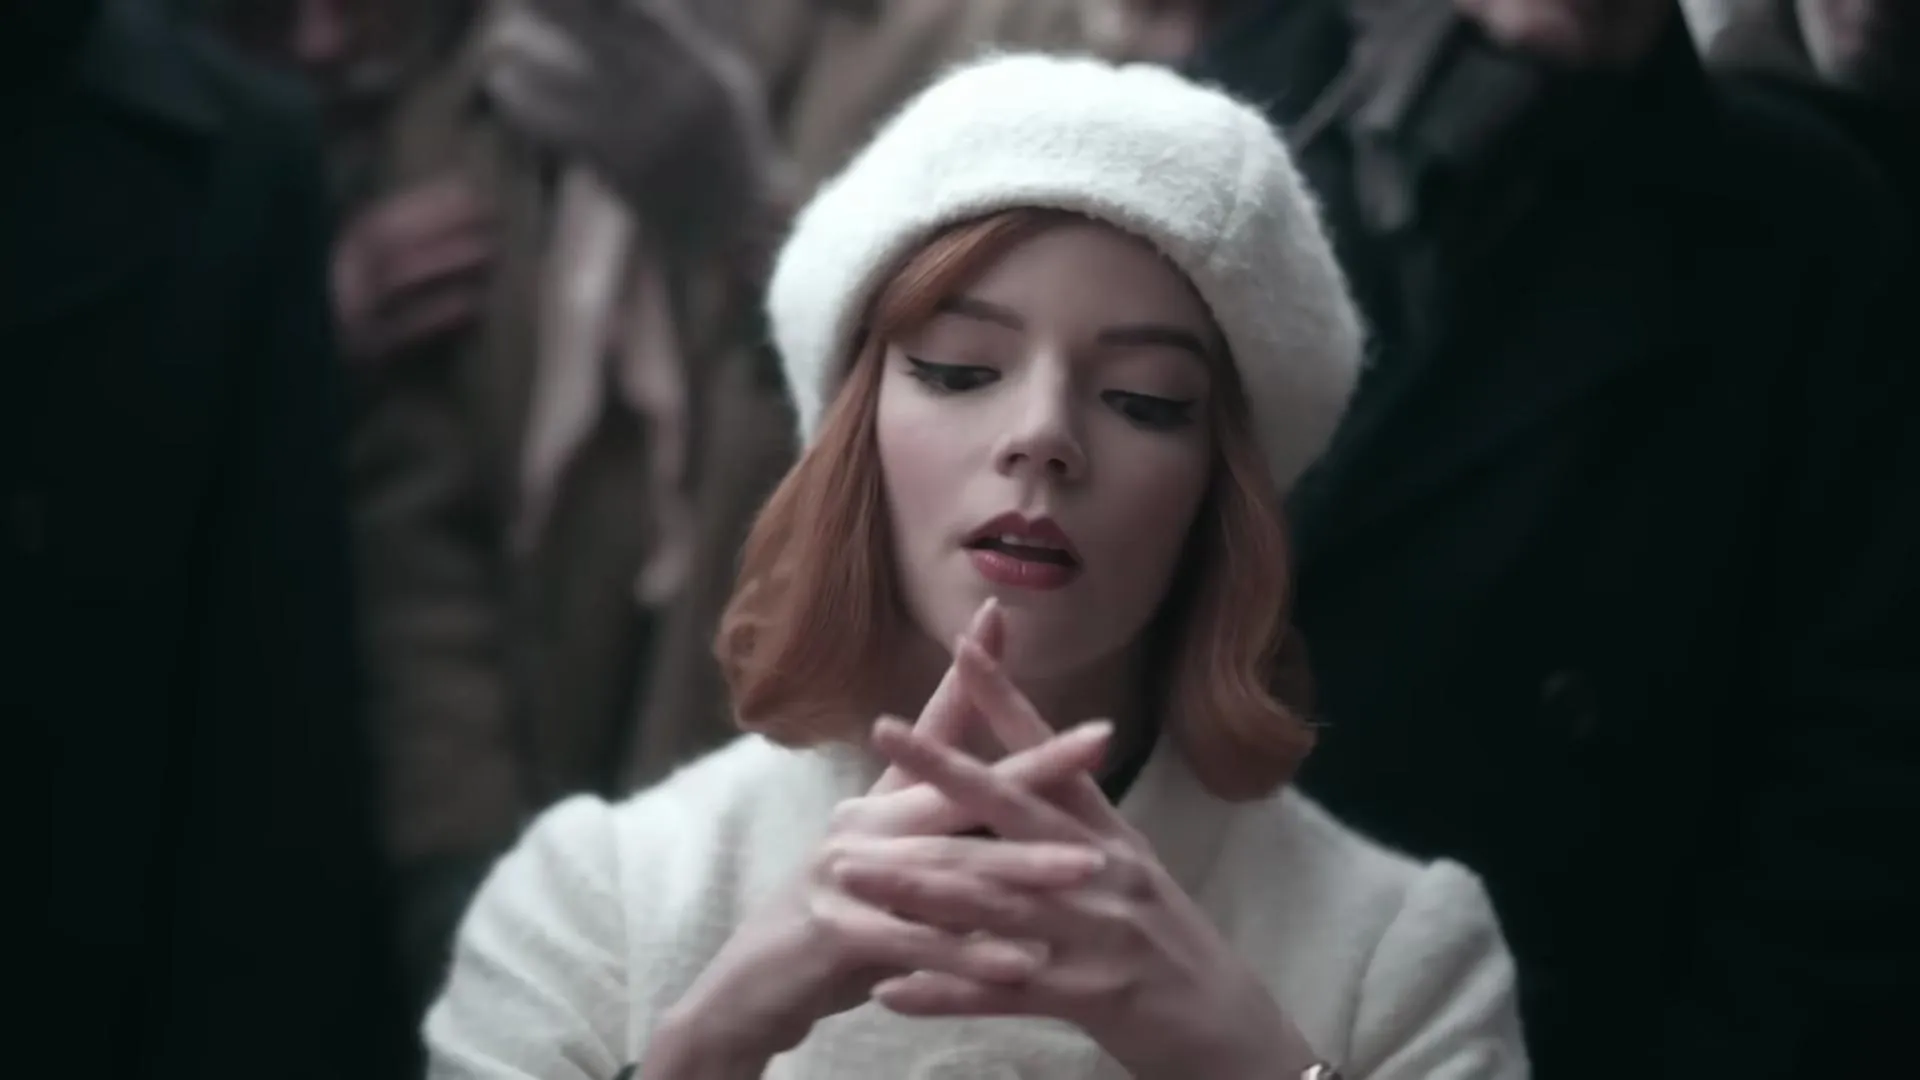
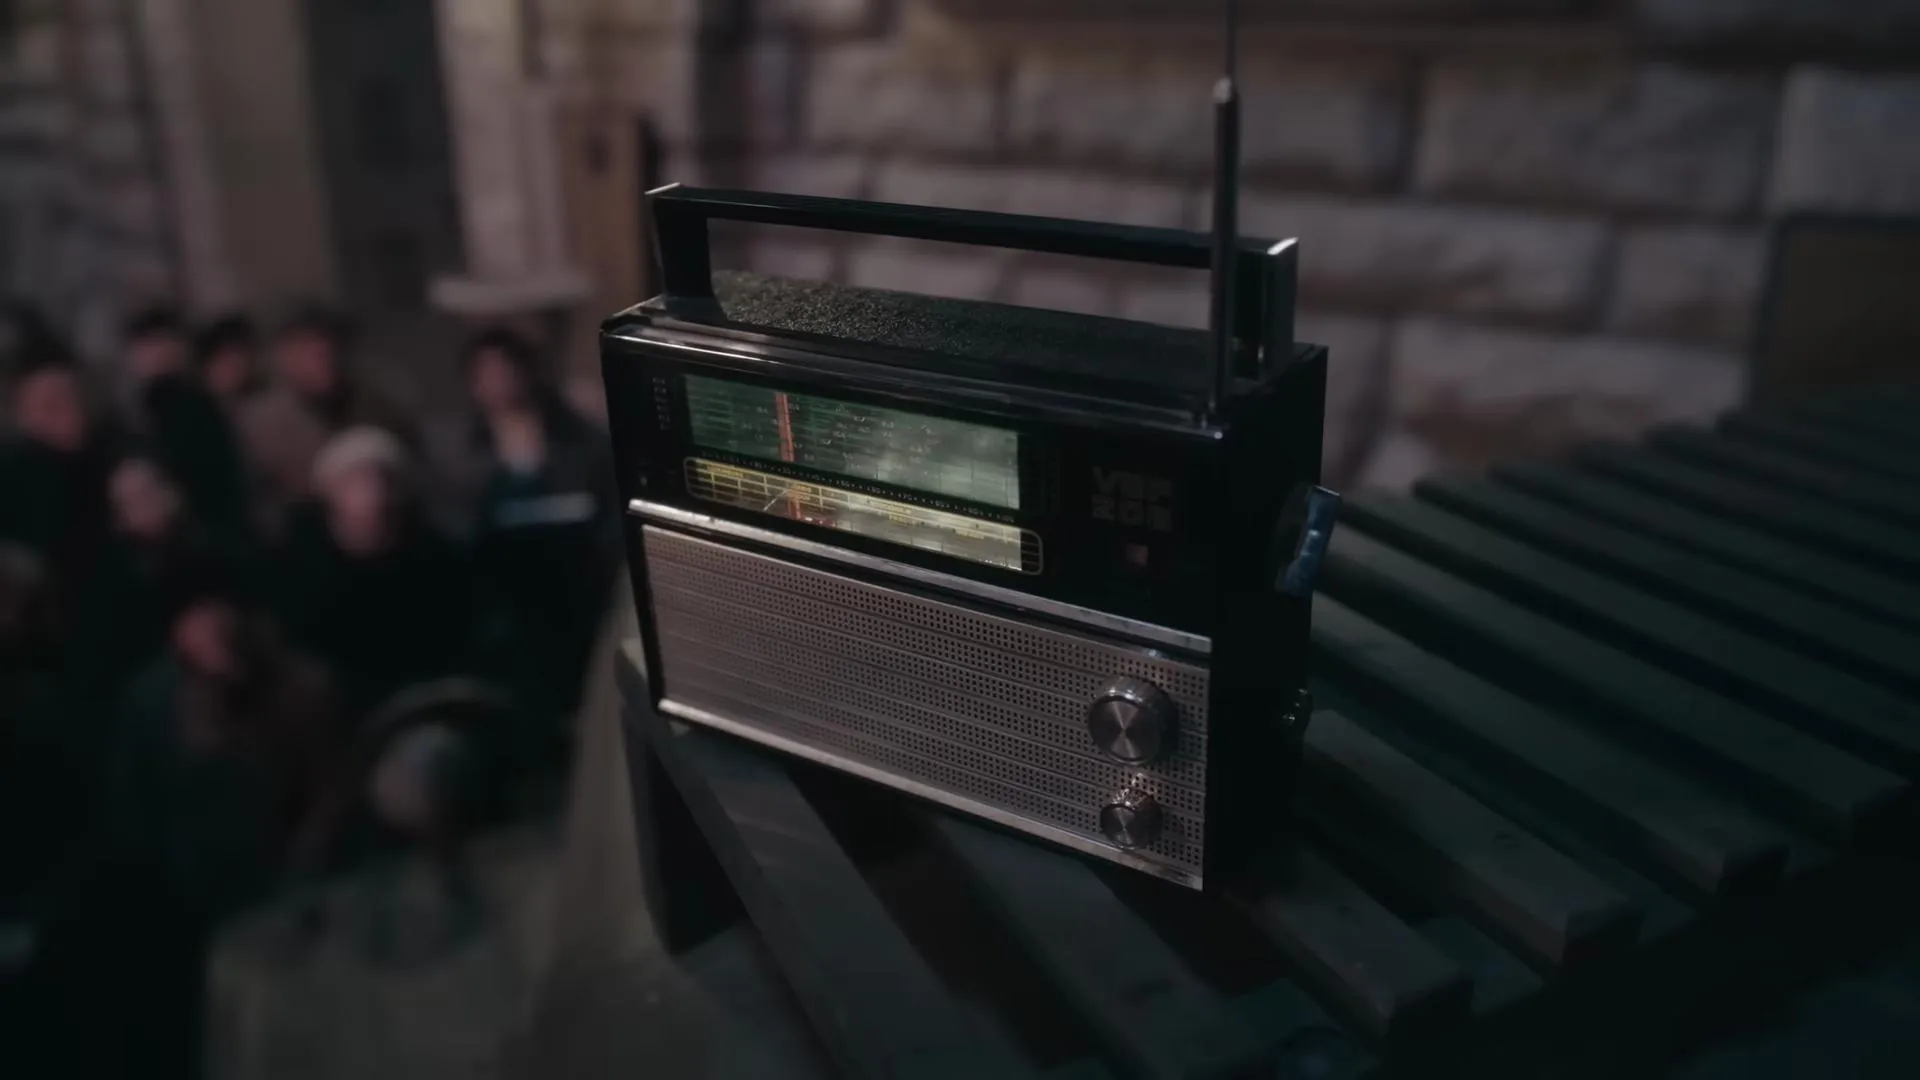
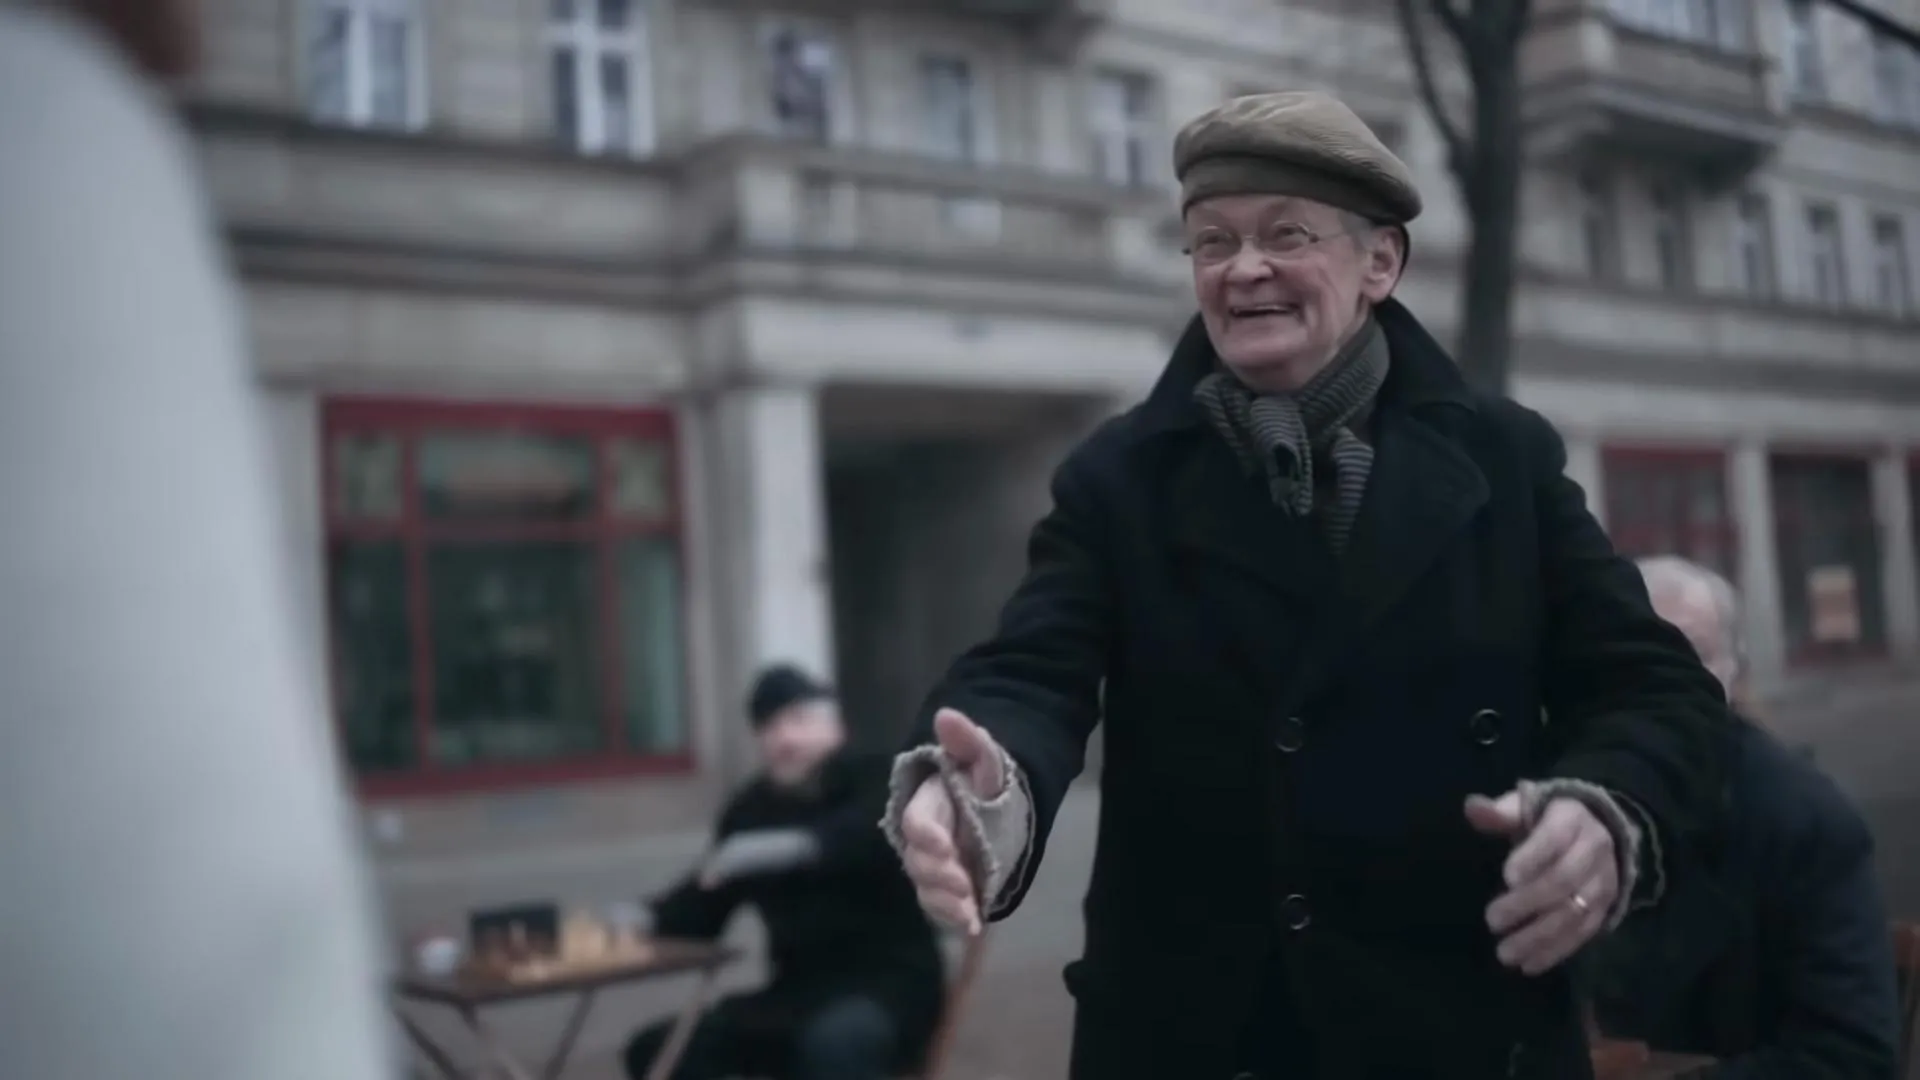

In [20]:
scene_view.select(scene_view.beginning_frame, scene_view.scene_prompt).limit(3).collect()

Now we have a `scene_prompt` column that contains the generated text descriptions. This prompt will be reused for both image and video generation in the next sections.

Let's look at our table history again:

In [21]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,8,2026-01-28 03:58:28.164026+00:00,None,schema,0,18,0,0,Added: scene_prompt
1,7,2026-01-28 03:58:22.751116+00:00,None,schema,0,18,0,0,Added: prompt_response
2,6,2026-01-28 03:57:39.036841+00:00,None,schema,0,18,0,0,Added: prompt_text
3,5,2026-01-28 03:57:24.928196+00:00,None,schema,0,18,0,0,Added: beginning_frame
4,4,2026-01-28 03:54:24.789093+00:00,None,data,101,0,0,0,NaN
5,3,2026-01-28 03:53:07.690538+00:00,None,schema,0,10,0,0,Added: transcript_text
6,2,2026-01-28 03:51:05.783620+00:00,None,schema,0,10,0,0,Added: transcription
7,1,2026-01-28 03:51:00.764533+00:00,None,schema,0,10,0,0,Added: audio
8,0,2026-01-28 03:50:50.962110+00:00,None,schema,10,0,0,0,Initial Version


## 04 - Generate Scene Images

Now let's put these prompts from `gemini-2.0-flash` to the test. We will use these scene prompts to generate visual images, using `imagen-4.0-generate-001` as our text-to-image model.

The examples below use `.select().where()` to test generation on a single scene. This is a **query** - it runs once and returns results without storing anything. This is perfect for testing expensive operations before applying them to all rows. Later, you'll see how to add image generation as a **computed column** to process all scenes automatically and store the results persistently.

Some things to note as you consider these options:

1. All frames are resized from 1920x1080 to 640x360 before being sent to Gemini. Gemini's API limit for combined text and image data is 100MB per request (recently increased from 20MB). We resize to stay well under this limit.

1. In Pixeltable, you can chain image operations like [`.resize()`](https://docs.pixeltable.com/sdk/latest/image#udf-resize) directly on image columns - you don't need to save the resized image to disk or create a separate column to include it in your API call.

1. Many model providers, including Gemini, limit how many requests you can send per minute (RPM = requests per minute), per day (RPD = requests per day), or both (these also may vary by model, too). Pixeltable gives you a few options for working within those rate limits:
    - First, do nothing! Pixeltable defaults to 600 requests per minute, but dynamically listens to model return messages to walk that pace back. For example, Google will tell you at some point to wait for 50+ seconds before submitting another API request. Pixeltable listens to these messages from Google and schedules requests appropriately.
    - Second, you can set rate limits globally across all your Pixeltable projects with a `~./pixeltable/config.toml` per provider and per model. This is a good option if you want to "cap" Pixeltable's API request pace based on known rate limits or budget constraints.
    - Third, you can set rate limits as environment variables. This is a good option for either overriding your global settings from your `config.toml` file, or just to cap the Pixeltable request pace in a specific notebook or Python session.

In [ ]:
# Uncomment to set rate limits in your Python session
#os.environ['GEMINI_RATE_LIMITS'] = '{"gemini-2.0-flash": 10}'
#os.environ['IMAGEN_RATE_LIMITS'] = '{"imagen-4.0-generate-001": 10}'
#os.environ['VEO_RATE_LIMITS'] = '{"veo-3.1-generate-preview": 2}'

Here, we are creating a variable `scene_image` to hold the result of the query. This is an in memory result and does not change your stored table. It is also limited: you can pull this result back up within your Python session only. We'll persist outputs in the next section.

In [22]:
scene_image = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    )
).collect()

pos,scene_prompt,scene_image
7,"An intricate miniature diorama of an outdoor chess scene in Moscow during the Cold War, inspired by ""The Queen's Gambit."" An elderly man in a black coat and tweed cap, sculpted from clay, reaches out his hand in greeting, a warm smile on his tiny face. Behind him, two men are seated at a miniature chess table crafted from wood, pieces meticulously arranged. Background shows a building with detailed window frames and architectural details. Photographed with a tilt-shift lens creating selectiv ...... nd building softened. Dramatic miniature lighting, a single warm spotlight highlighting the man's face, casting long, soft shadows. Tiny handcrafted details include felt scarves and minuscule buttons on the coats, cobblestone street made of painted clay. Color palette: muted grays, browns, and hints of red in the storefront details, creating a melancholic yet charming atmosphere. Mood: a heartwarming moment of camaraderie amid a stark and cold environment, cinematic and charmingly handmade.",
7,"An intricate miniature diorama of a hallway scene from ""Only Murders in the Building"", featuring three handcrafted miniature figures: Charles in a dark suit meticulously holding a wine cork, Oliver gesturing with both hands raised, and Mabel in a sequined dress looking bewildered. The diorama includes a miniature wooden door behind them. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, eye-level perspective, dramatic miniature lighting emphasizing the characters' faces and the hallway's details with soft, warm spotlights mimicking interior lighting. Tiny handcrafted details: individual sequins on Mabel’s dress, realistic folds in Charles and Oliver’s felt clothing, and wood grain in the door. Materials: felt, clay, wood. The color palette is predominantly beige and brown, with a glint of gold from Mabel's dress. The mood is both humorous and slightly suspenseful, capturing the essence of the show.",

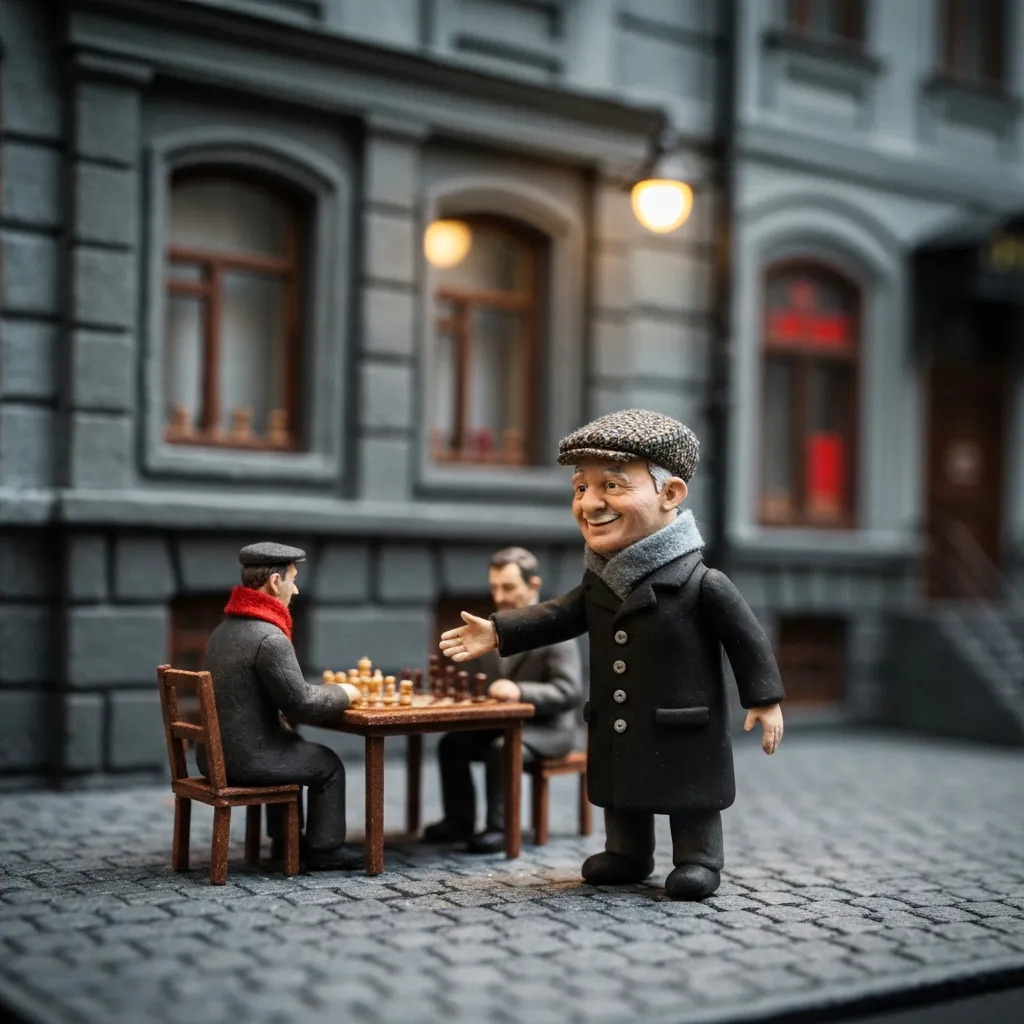
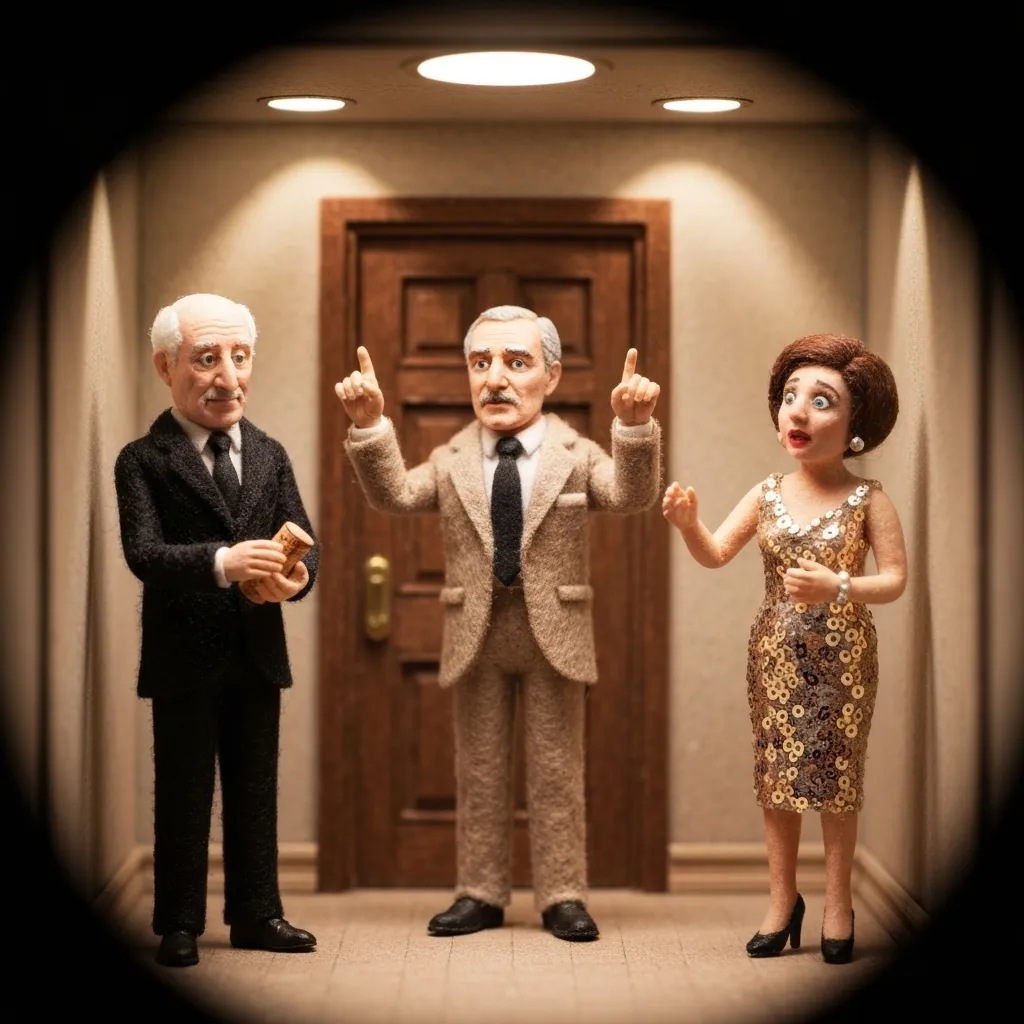

In [23]:
scene_image

You've tested image and video generation on individual scenes in queries using `.select().where()`. 

But what if you want to generate images for **all** scenes automatically, and save them persistently in your scene view?

## 05 - Generate Across All Scenes

You've tested image generation on a single scene using `.select().where()`. Now you'll add it as a computed column to process all scenes automatically.

**What changes when you use a computed column:**

1. **Processes all rows**: Generates images for all rows (here, we have 1 row per scene for each video) with a unique prompt per row, without loops or iteration code
2. **Parallel execution**: Pixeltable parallelizes API calls automatically - faster than sequential processing
3. **Persistent storage**: Results are stored in the table, not just returned as query results
4. **Incremental updates**: If you add new videos to the base table, the scene detection and image generation cascade automatically

Here we will generate just images with the `imagen-4.0-generate-001` model. At the time of this workshop, Gemini limits this model to 10 requests per minute with a max of 70 images per day, so you can run this code on all rows within the free tier.

If you want to test out video generation and have your billing setup, you can adapt our query code above to use computed columns instead. You'll want to configure Pixeltable with provider-specific rate limits: https://docs.pixeltable.com/platform/configuration#rate-limit-configuration

This computed column will automatically generate a "diorama" image for each scene - it takes about 2 minutes to execute.

In [24]:
scene_view.add_computed_column(
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    ),
    if_exists='replace',
    on_error='ignore' # Continue processing despite individual row-wise failures
)

Added 18 column values with 0 errors in 53.22 s (0.34 rows/s)


18 rows updated.

**What happens when you execute this code:**

We've created a **declarative workflow** with three computed columns that form a processing pipeline:

1. `beginning_frame` - Extracts a frame from each video segment
2. `trailer_prompt` - Generates a text description from the frame (multimodal AI)
3. `trailer_image` - Generates an image from the text description (text-to-image AI)

Each computed column builds on the previous one. Pixeltable handles the orchestration - it knows the dependencies and executes them in the correct order automatically.

Let's take a look at our collection of generated images:

pos,scene_prompt,scene_image
0,"An intricate miniature diorama of Charles, Oliver, and Mabel, handcrafted figures made of felt and clay, standing in Mabel's dramatically lit, meticulously detailed apartment, mid-investigation. A wide shot, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. The floor is littered with tiny wood and paper clues - miniature newspaper clippings, crime scene photos, and floor plans. The overall color palette is muted grays, browns, and greens, punctuated by pops of blood-red paint on a miniature sculpture and a strategically placed clue. A miniature desk lamp casts stark shadows, creating a noir mood, while the handmade details add a charming, disarming element.",
1,"An intricate miniature diorama of home movie footage of a young man in a black shirt and pants running in front of a red brick wall. He is slightly out of focus. In the background, a white house with a white porch overhang is visible, partially obscured by trees. The diorama is photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. The shot is a medium shot, and the lighting is dramatic and miniature, with a slight sepia tint, evoking old film stock. Tiny handcrafted details include minuscule leaves on the trees made of felt, the brick wall painstakingly created with individual clay bricks, and the tiny figure of the running man sculpted from clay. Materials include felt, clay, and wood. The color palette is muted and warm, with shades of red-brown, white, green, and black. The mood is nostalgic and slightly unsettling, as if a forgotten memory is being unearthed. The scene should feel both cinematic and charmingly handmade.",
2,"An intricate miniature diorama of a little girl with pigtails, crafted from clay and felt, holding a large, black landline phone receiver to her ear, her expression a mix of distress and fear. The background is a simple, light green wall. Shot with a tilt-shift lens creating selective focus, emphasizing the miniature nature and dreamlike toy-world atmosphere. A tight, close-up shot. Dramatic, soft miniature lighting, with slightly muted colors and a hint of film grain to evoke a vintage home movie. Materials: felt, clay, balsa wood. Color palette: muted pastel greens, pinks, and creams. Mood: anxious, unsettling, yet charmingly handcrafted.",
3,"An intricate miniature diorama of a young boy in a backyard swimming pool. A tilt-shift lens creates a selective focus on the boy's miniature clay face, with the background of felt trees softly blurred, creating a dreamlike toy-world atmosphere. Medium shot, dramatic overhead lighting from a miniature spotlight casts long, soft shadows from the trees, emphasizing the boy's expression. Tiny handcrafted details include water ripples crafted from resin, leaves from felt, and the pool is made from painted wood. The color palette is muted: blues, greens, and browns. The mood is melancholic, introspective, and a touch unsettling.",
4,"An intricate miniature diorama of Charles's cluttered apartment corner at the Arconia, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. A medium shot focusing on a dark green armchair with a black coat casually draped over it, a plate with miniature cookies resting on the arm; to the right, a framed silhouette portrait is prominently displayed, capturing the light from a desk lamp; the background reveals a dark wooden bookshelf filled with tiny handcrafted books. Lighting: dramatic miniature lighting with pools of warm light from the desk lamp and floor lamp, casting long shadows and creating a sense of mystery. Tiny handcrafted details include the felt fabric of the coat, clay cookies with tiny crumbs, wood for the furniture with intricate carvings. Color palette: dark academia, with deep greens, browns, and hints of gold, creating a cozy yet mysterious atmosphere. The scene feels both cinematic and charm
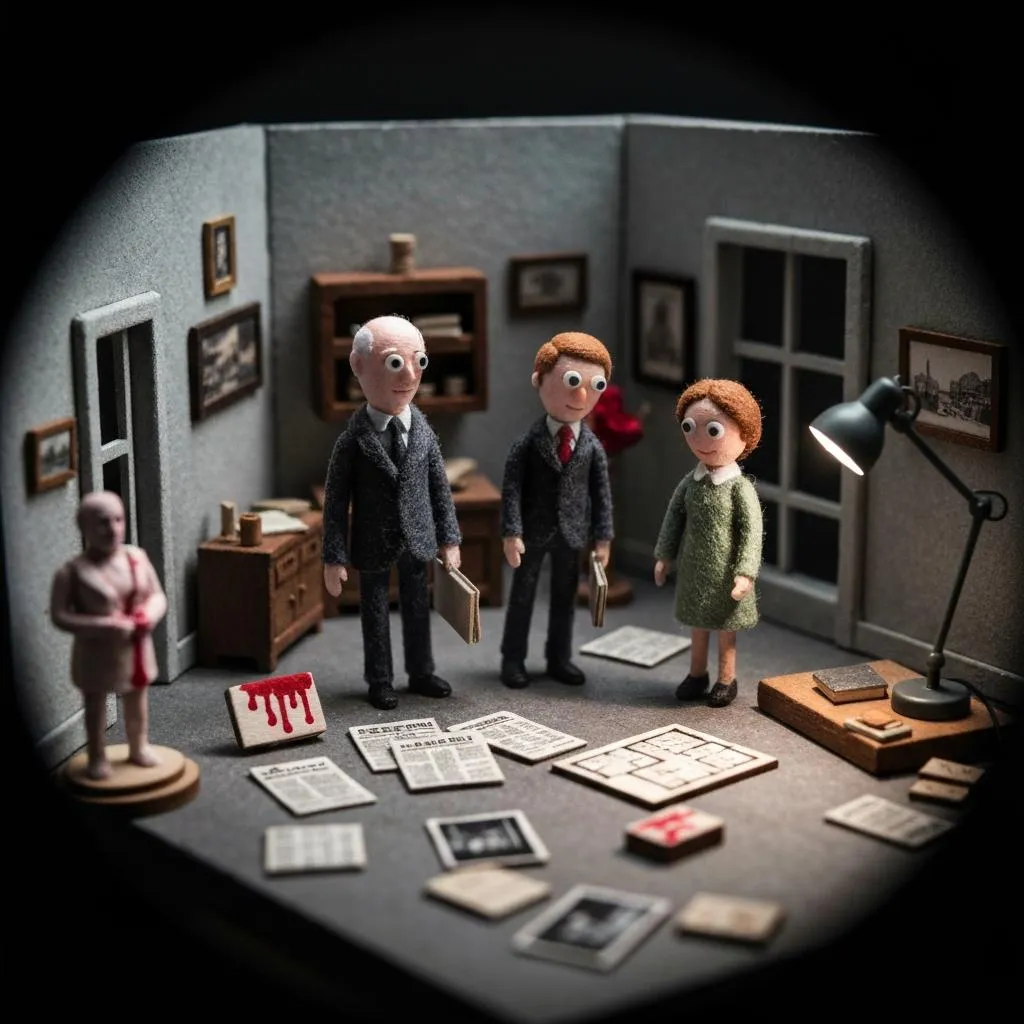
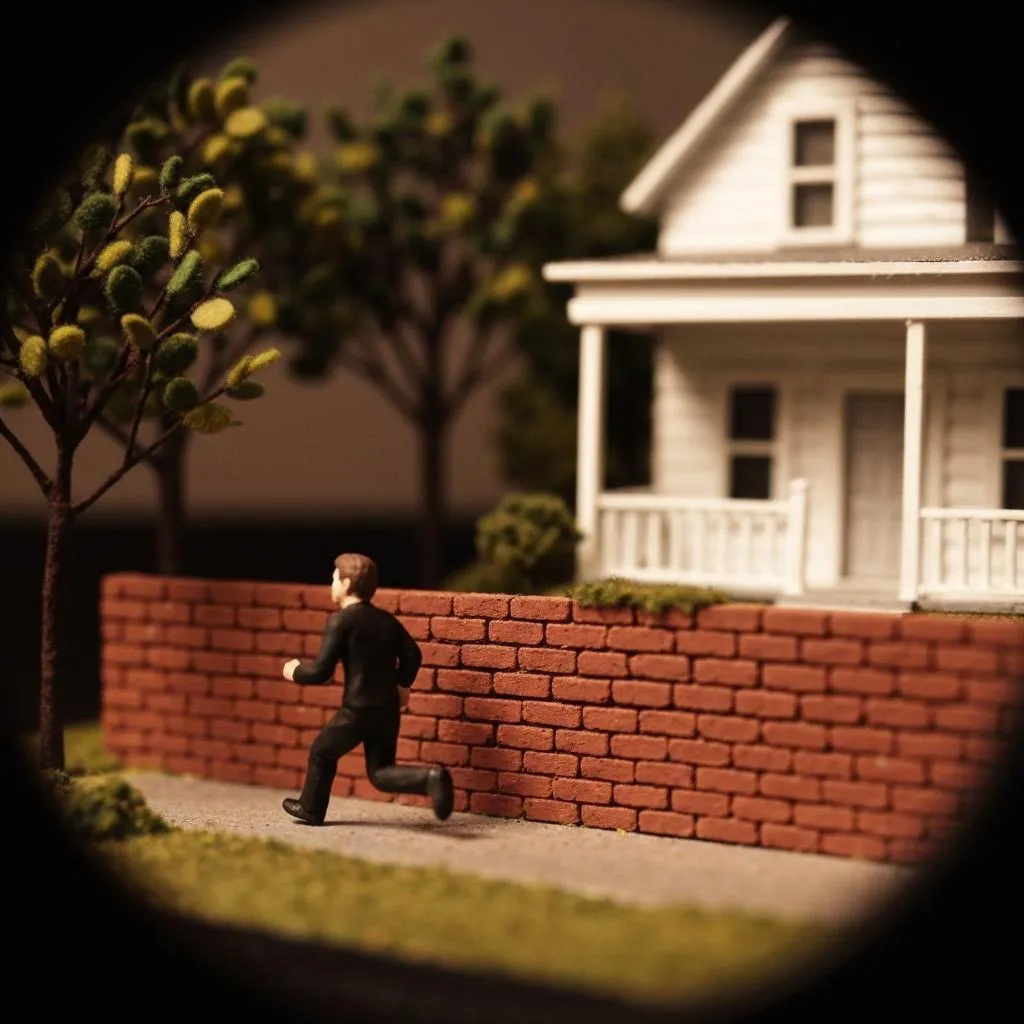
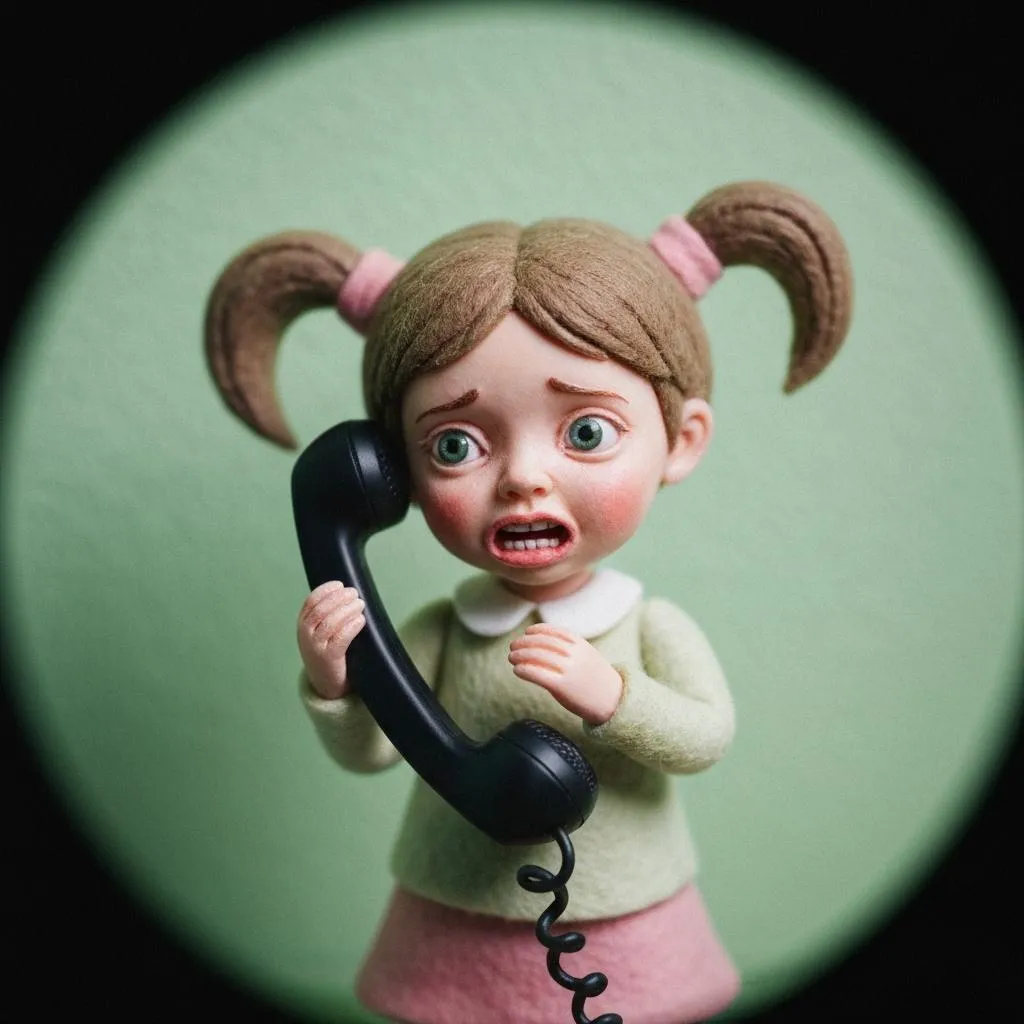
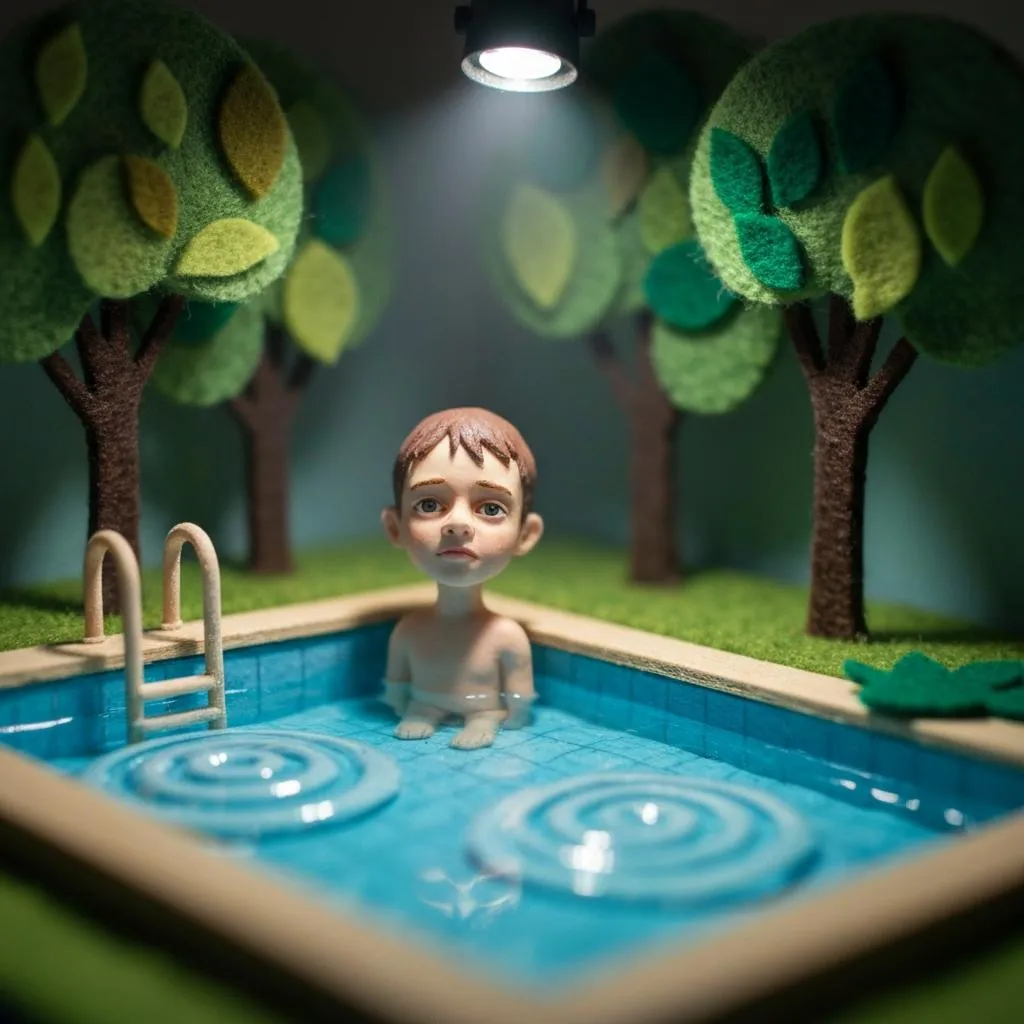
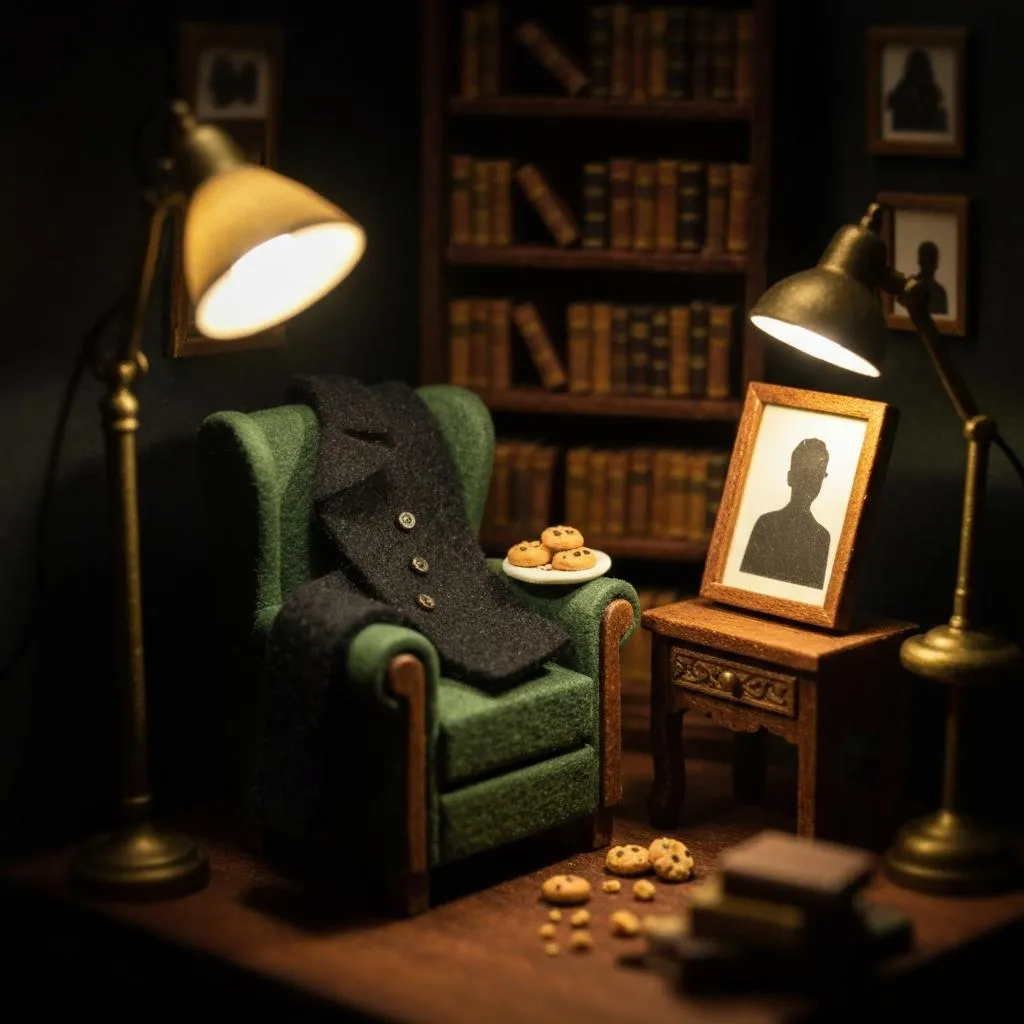
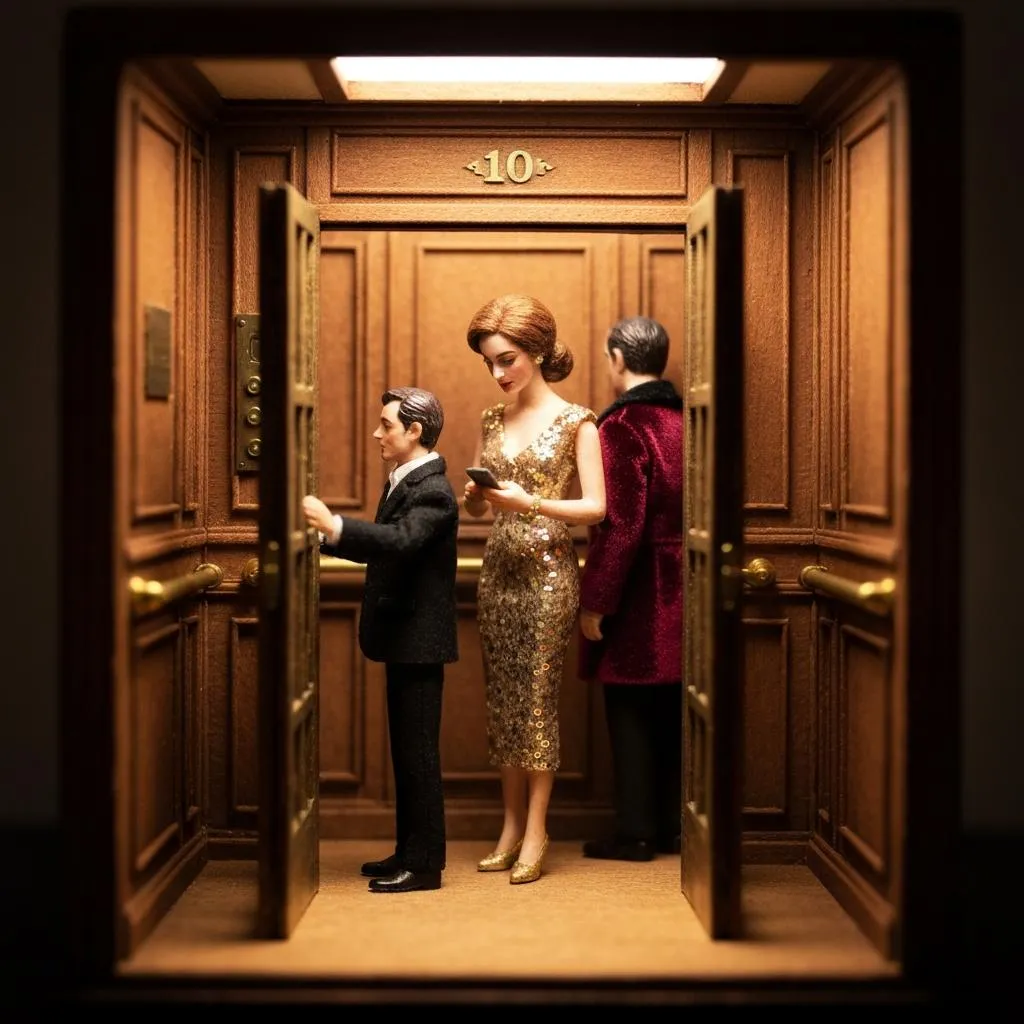
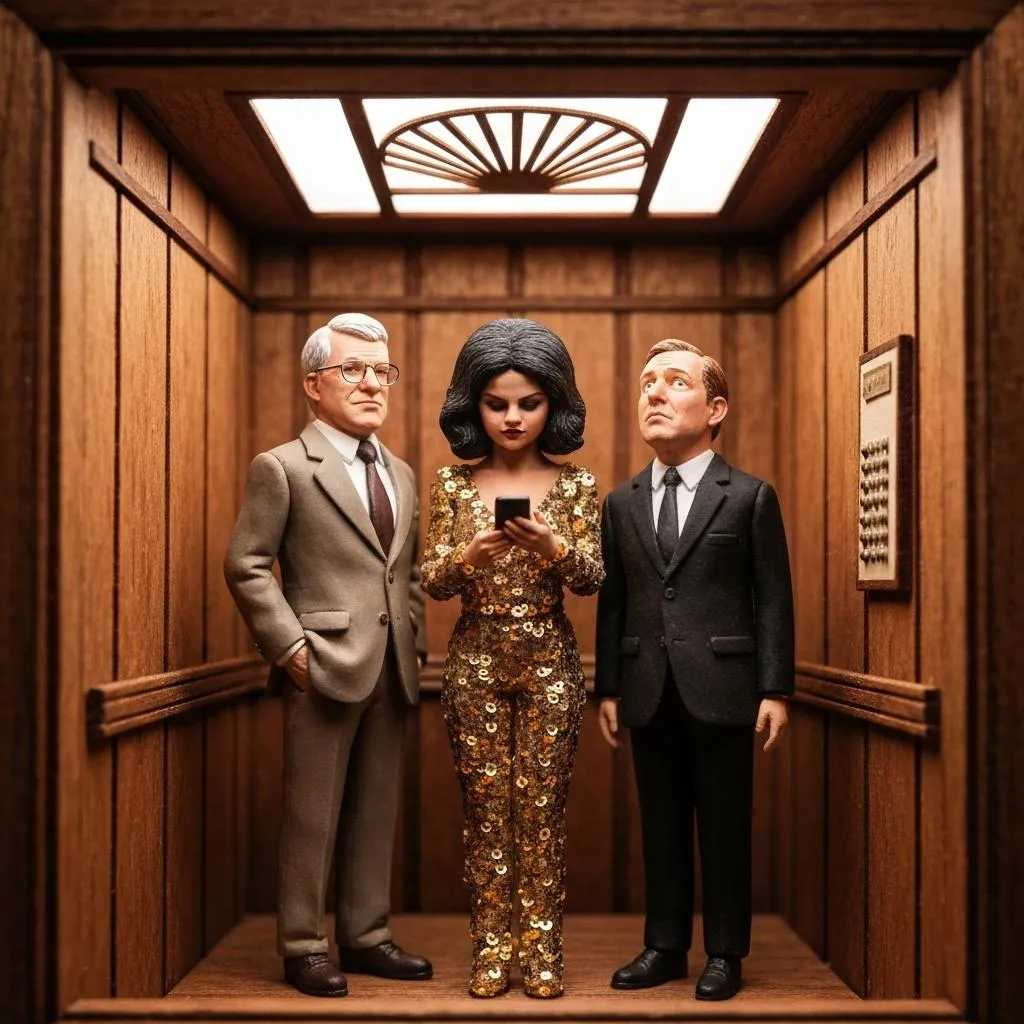
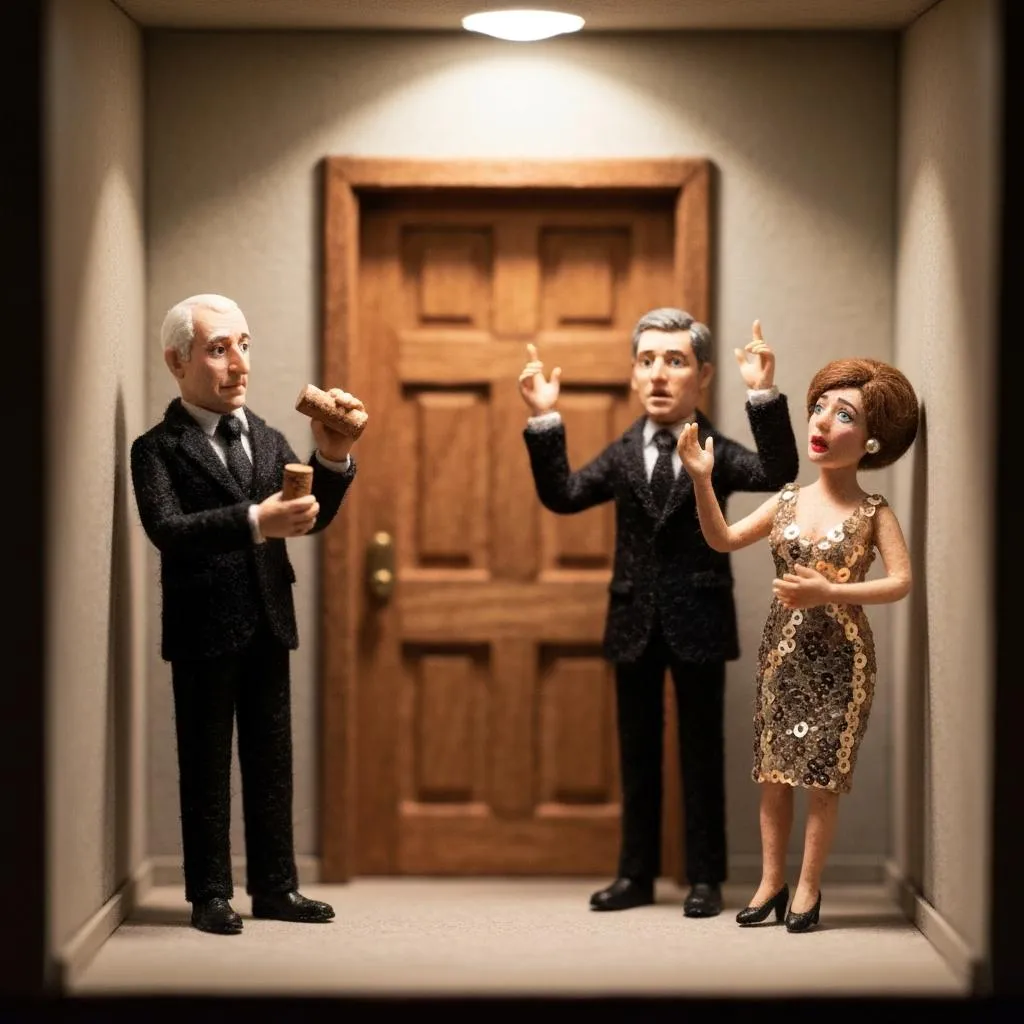

In [34]:
scene_view.where(
    scene_view.title.contains('Murders')
).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

pos,scene_prompt,scene_image
0,"An intricate miniature diorama of a pivotal scene from ""The Queen's Gambit,"" focusing on a vintage Soviet radio on a wooden xylophone. The radio is black, with a silver grill and chrome knobs, the xylophone is in dark green. Behind it, blurred by tilt-shift, is a crowd of tiny onlookers in a dark room. The shot is a medium close-up, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Dramatic miniature lighting highlights the radio's details, with a single spotlight emphasizing the reflection on the silver grill. Tiny handcrafted details include meticulously sculpted miniature faces in the crowd, minuscule radio dials, and visible wood grain on the xylophone keys. Primary materials are felt for the background crowd, clay for the miniature figures, and meticulously carved wood for the xylophone. The color palette is muted, with dark greens, grays, and blacks contrasted by the chrome accents. The mood is tense, quiet, and expectant.",
1,"An intricate miniature diorama of a tense chess match from ""The Queen's Gambit"", Beth Harmon facing Borgov at a tournament. Beth is in the foreground, her brow furrowed in concentration as she studies the board; Borgov is seated across from her, an inscrutable expression on his face. A tilt-shift lens creates selective focus and a dreamlike toy-world atmosphere. Close-up shot, with the focus on Beth's face and the chess board, the background softly blurred. Dramatic miniature lighting, with a single spotlight illuminating the chess board and casting long shadows across the felt-lined table. Tiny handcrafted details: minuscule chess pieces made of clay, tiny spectators seated in the background, wood paneling on the walls, felt curtains. Predominantly cool colors: blues, grays, and browns, accented by the warm glow of the spotlight. The mood is one of intense concentration and quiet tension.",
2,"An intricate miniature diorama of a tense chess match, focusing on the pieces and the hand of a player making a move, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Close-up shot, dramatic single-source miniature lighting highlighting the chess board and the player's hand, tiny handcrafted details on the chess pieces and board made from felt, clay, and wood. The chessboard is glossy, reflecting the light, the pieces are intricately carved and painted. Color palette is warm, with blacks, creams, and browns dominating the scene, the mood is intense and suspenseful. The clock on the background adds to the tension. The scene should feel both cinematic and charmingly handmade.",
3,"An intricate miniature diorama of Beth Harmon, hunched over a chessboard, late at night, in her dimly lit hotel room during a tournament. The room includes wallpaper with an ornate pattern, a small bed with a felt bedspread, and a handcrafted wooden chess set. A tilt-shift lens creates selective focus and a dreamlike toy-world atmosphere. Medium shot. The lighting is dramatic, with a single desk lamp casting long shadows and highlighting the chess pieces, with backlighting from a miniature, flickering television screen. Tiny handcrafted details include individual chess pieces, patterned felt curtains, and miniature pill bottles. Primary materials are felt, clay, and wood. The color palette is muted, with browns, greens, and oranges, creating a somber yet nostalgic mood.",
4,"An intricate miniature diorama of Beth Harmon, surrounded by a crowd of people in dark winter clothing, arriving at the Central Chess Club of Moscow. A stern-faced man in a dark overcoat stands in the doorway. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, dramatic miniature lighting with cool blue tones and a spotlight on Beth. Tiny handcrafted details include individual faces, tiny hats, and the ornate stonework of the building entrance. Materials used are felt, c
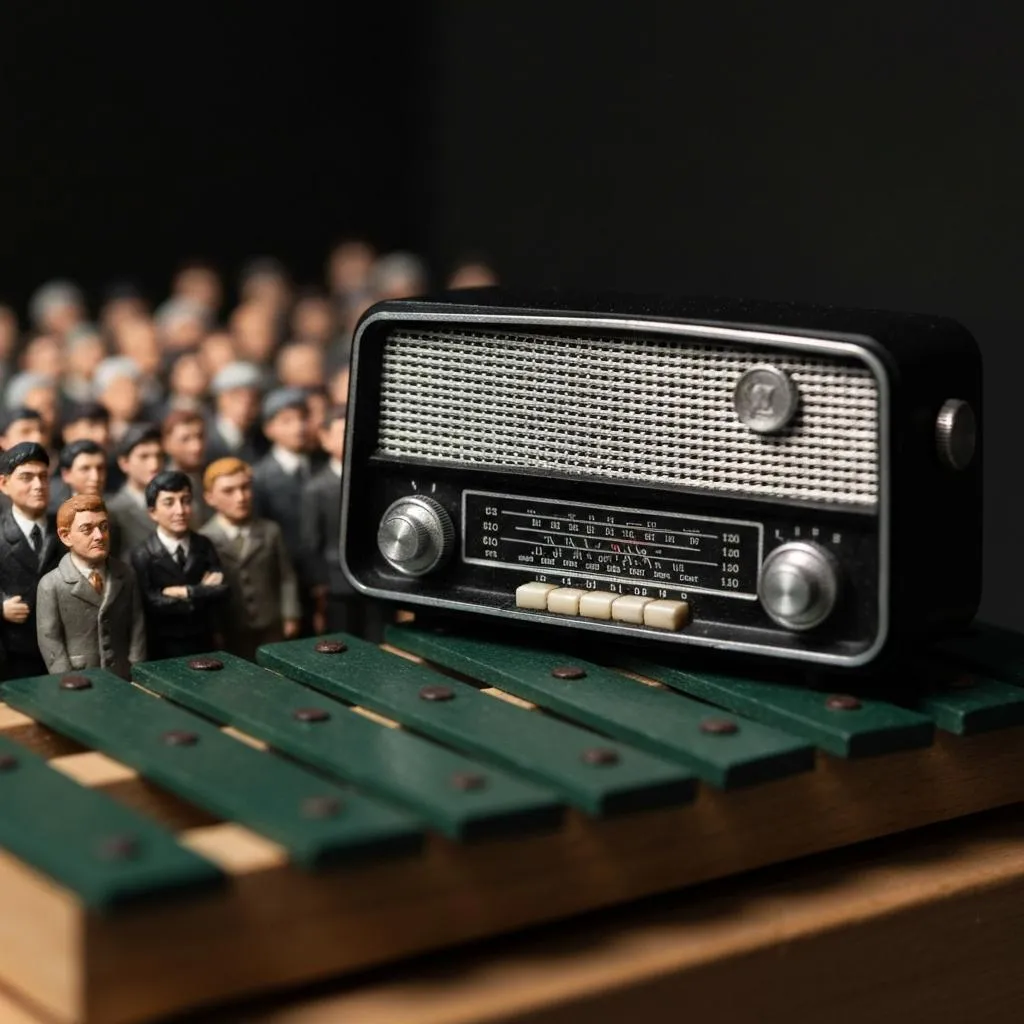
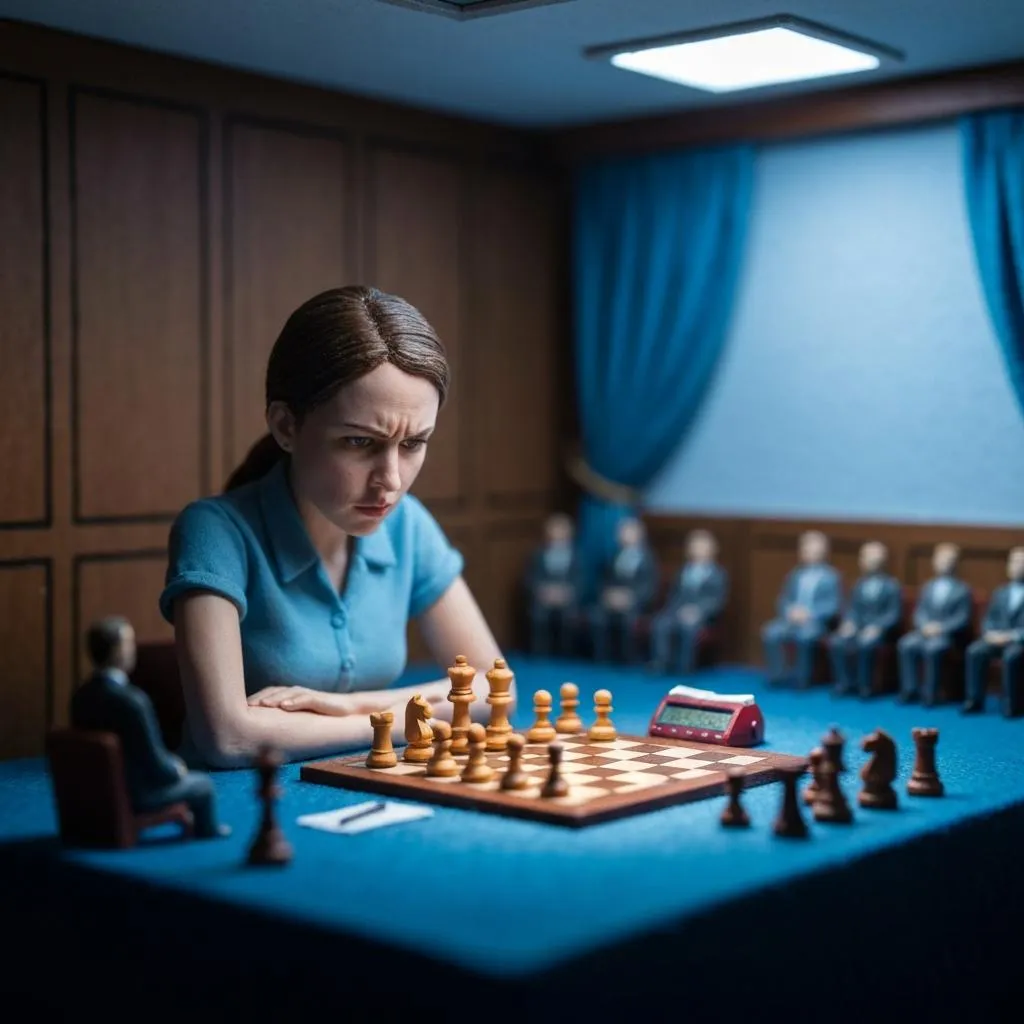
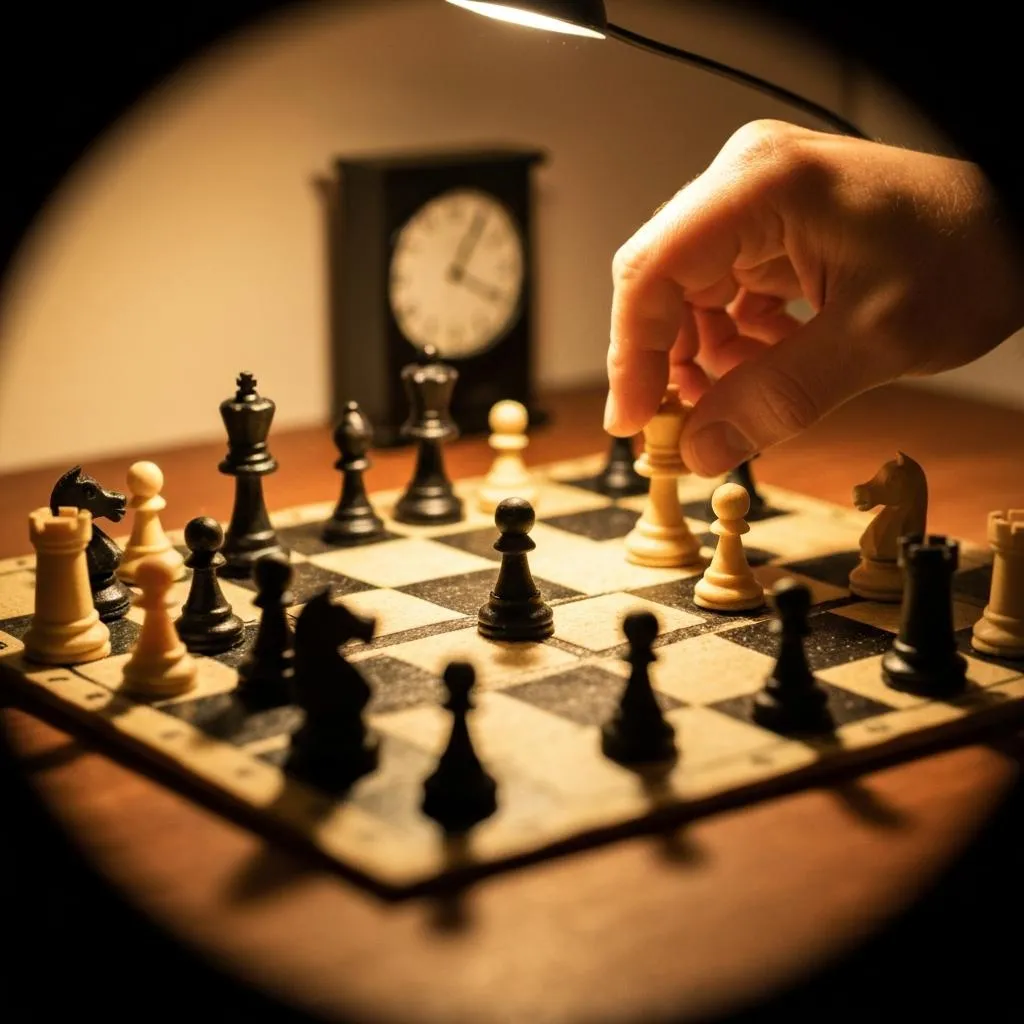
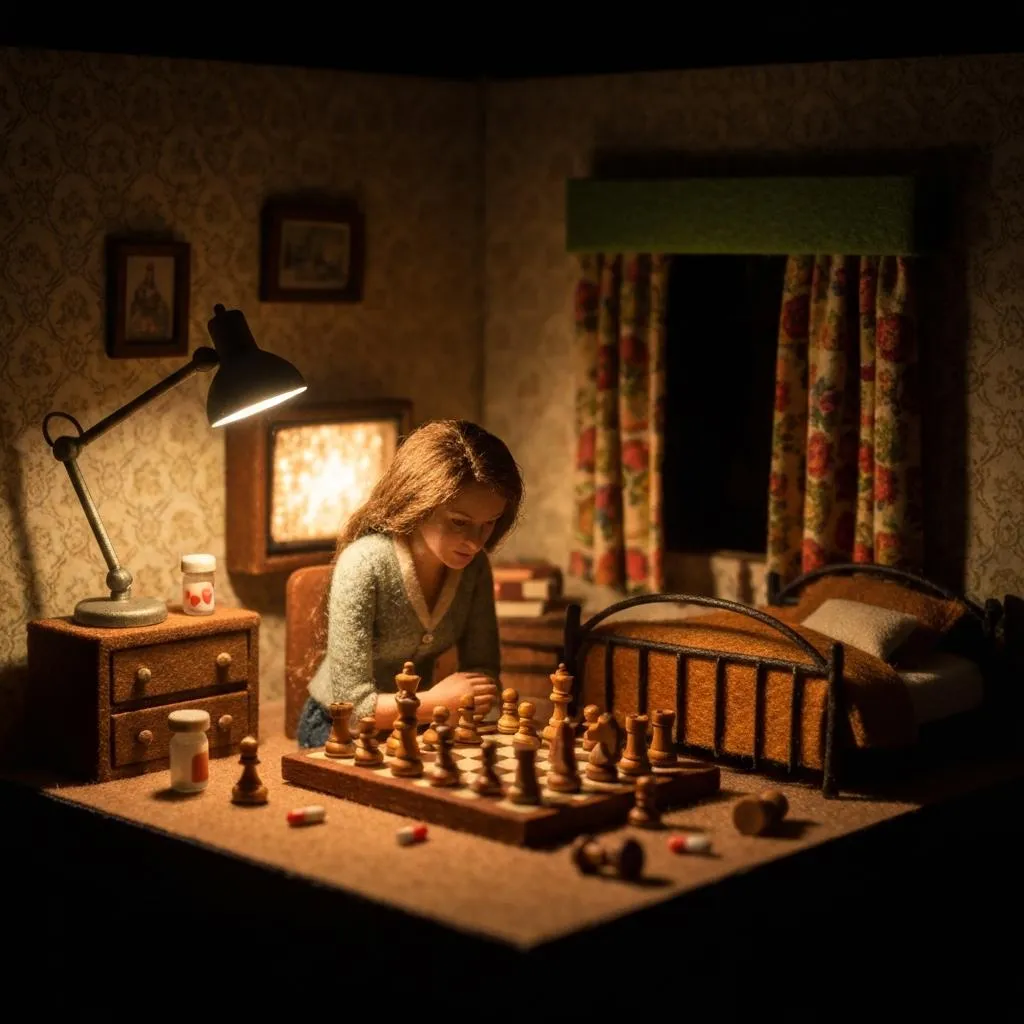
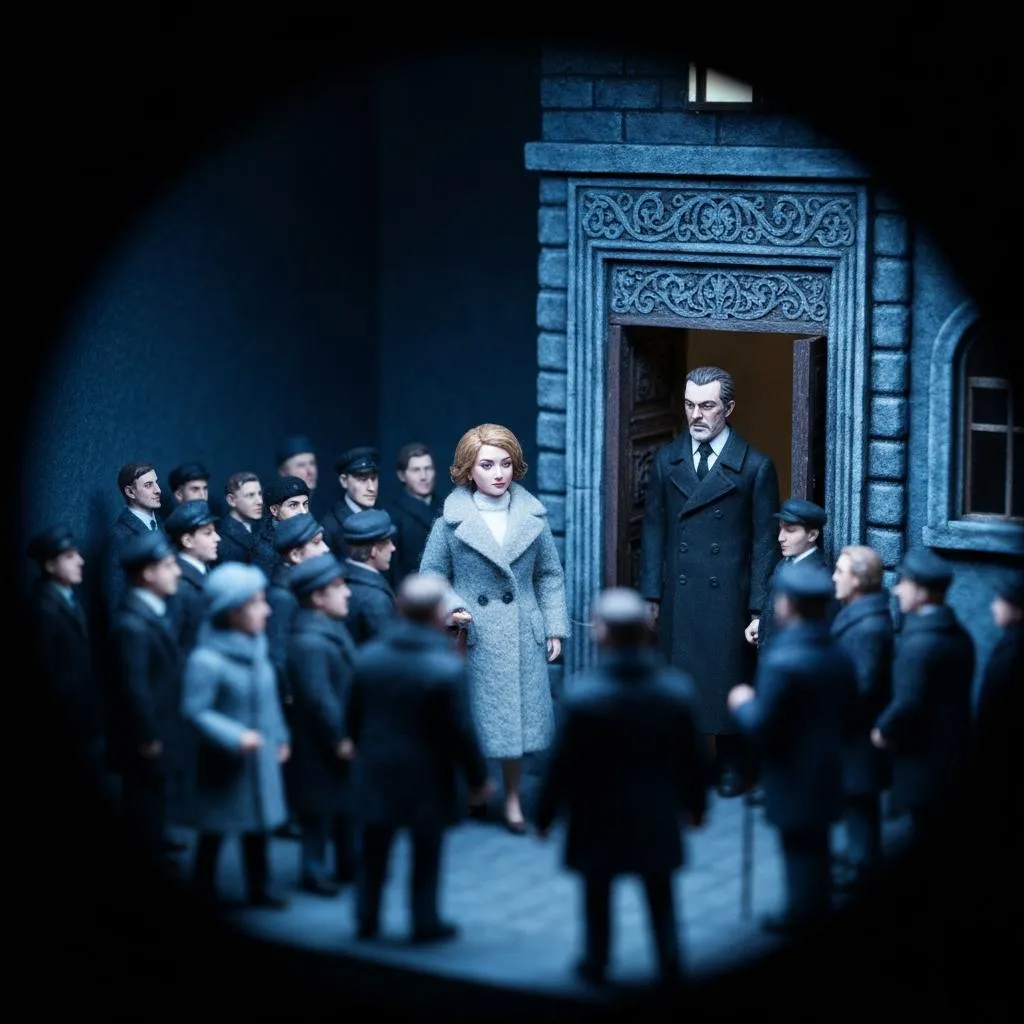
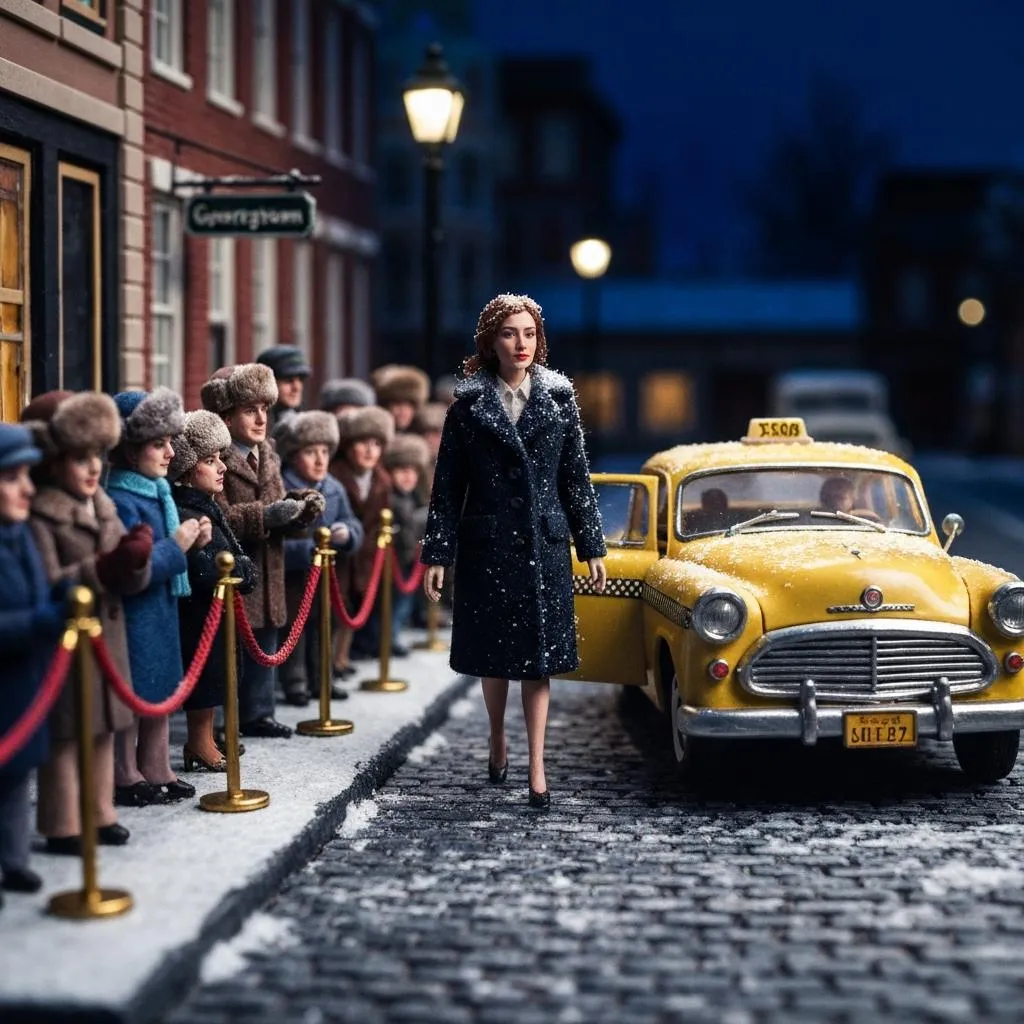
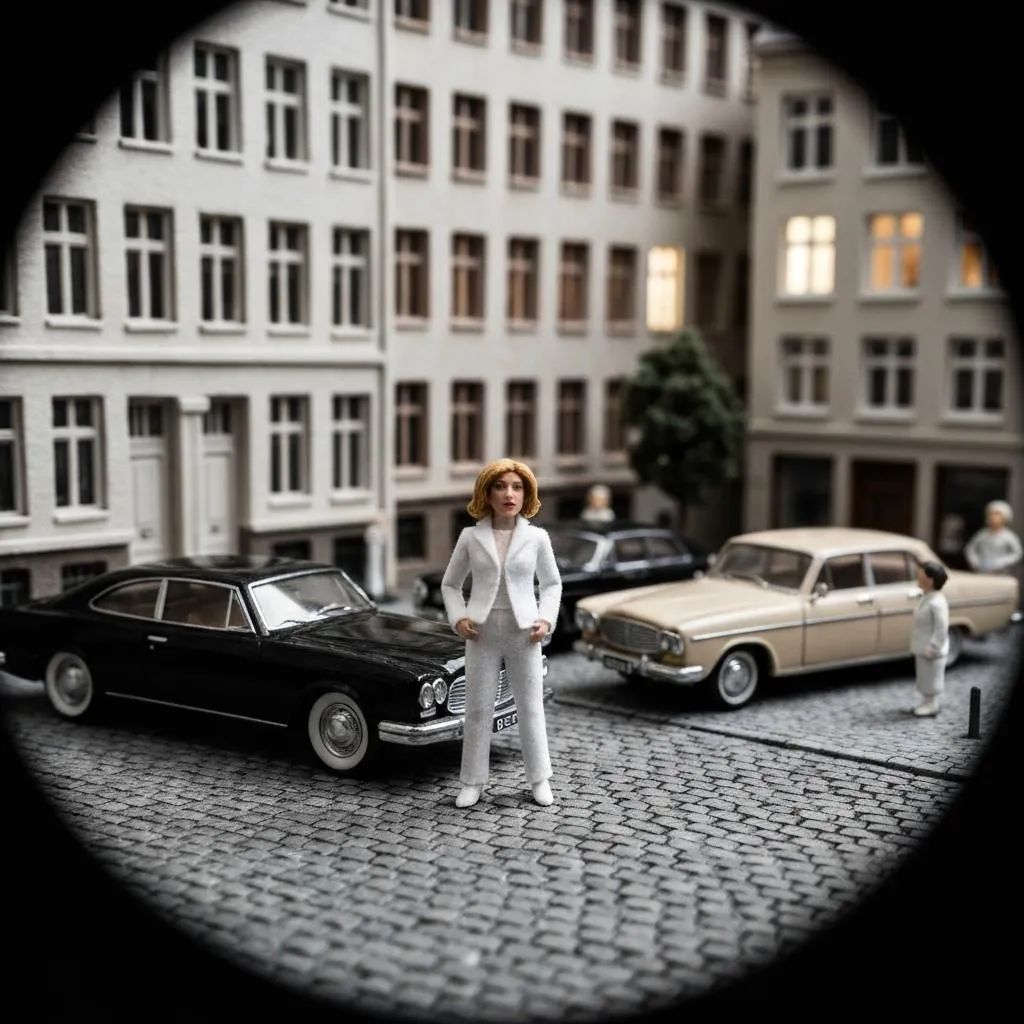
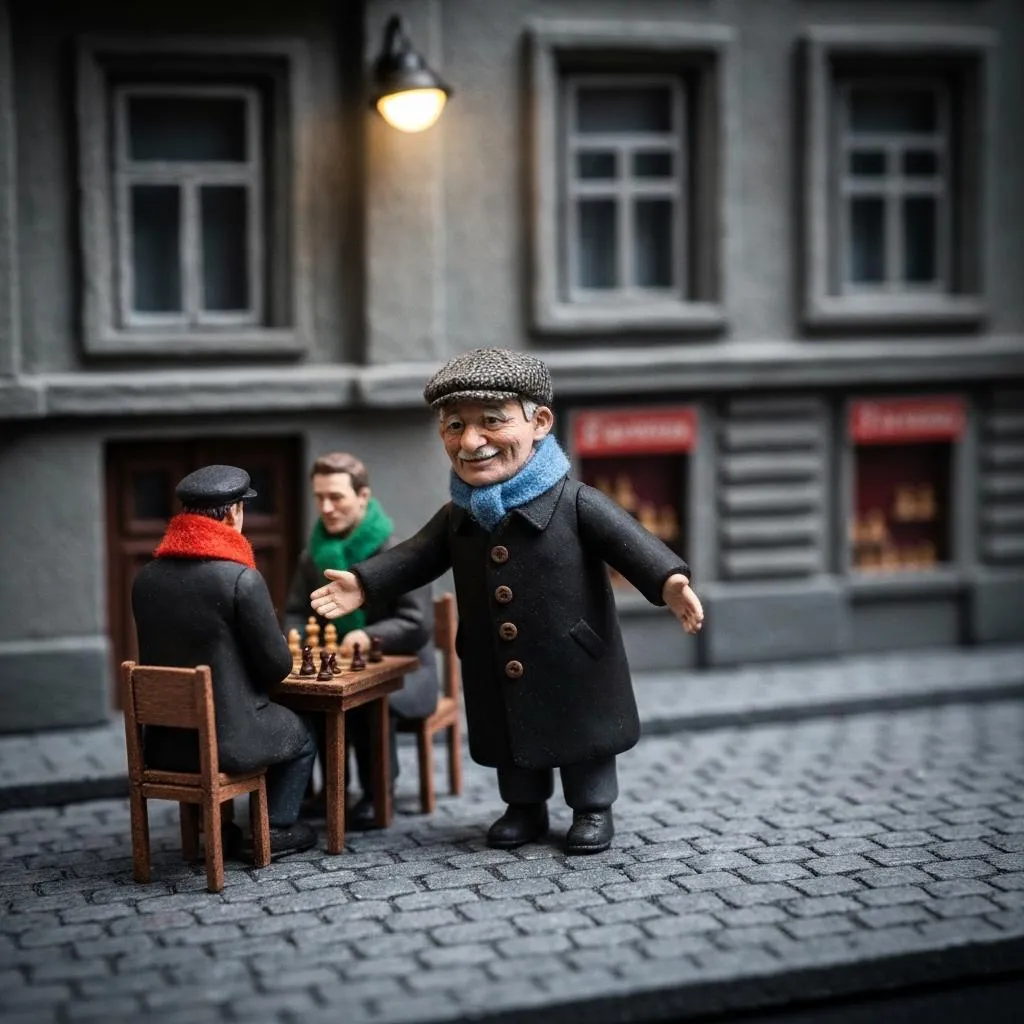
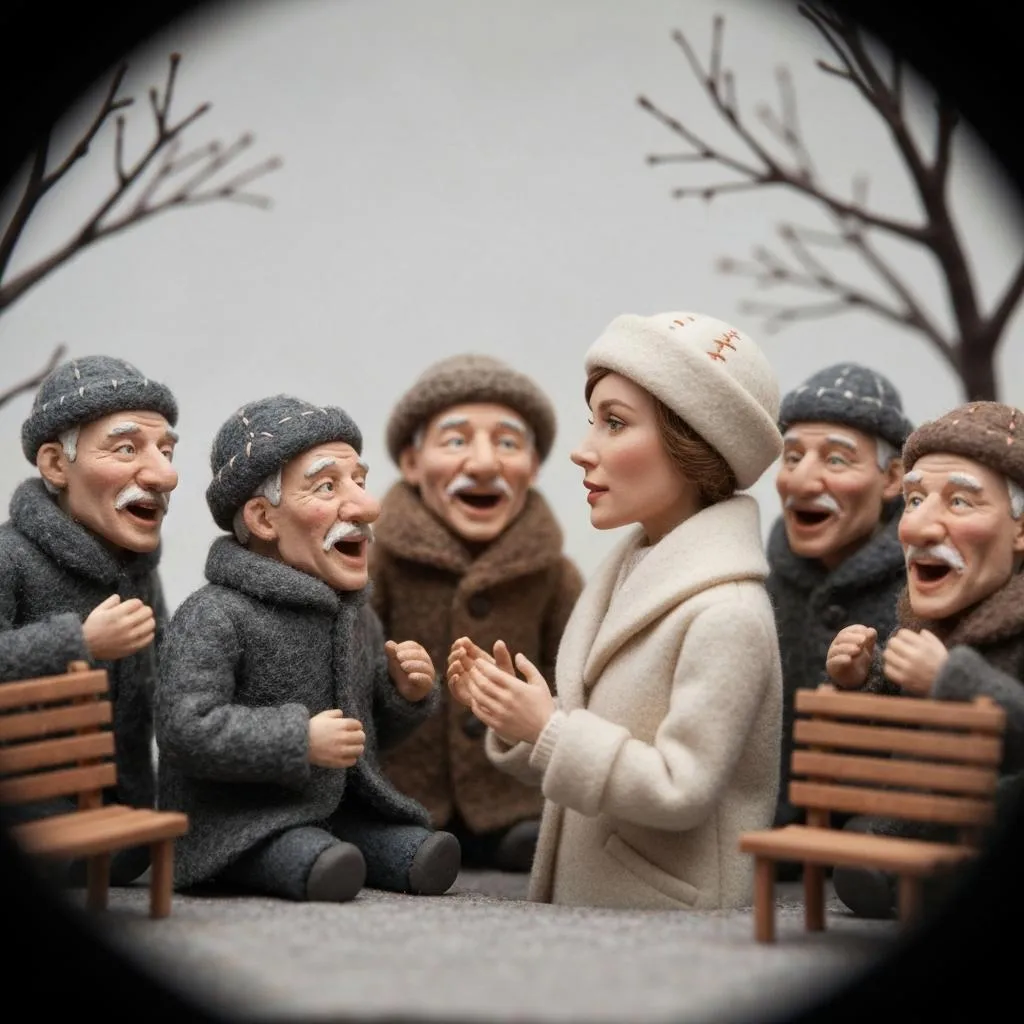
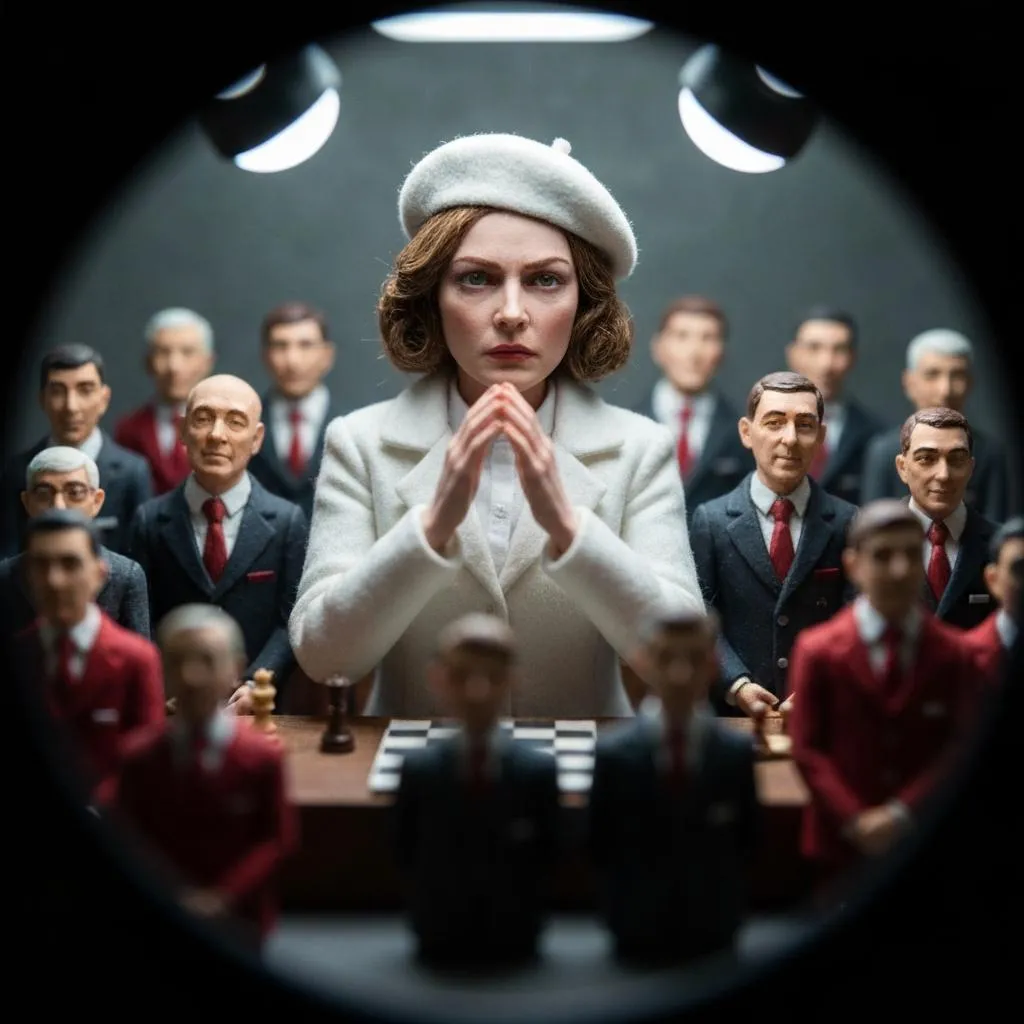

In [35]:
scene_view.where(
    scene_view.title.contains('Queen')
).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

Now that these are stored persistently, you can see the images have a spot in your local file cache. Read more about external files in our docs: https://docs.pixeltable.com/platform/external-files

scene_image,scene_image_localpath
,/Users/alison-pxt/.pixeltable/media/93a2d47bea1e426a9df241f60f78c467/b2/b288/93a2d47bea1e426a9df241f60f78c467_19_9_b2884c7fbbef404eb1a38a6476201d90.jpeg

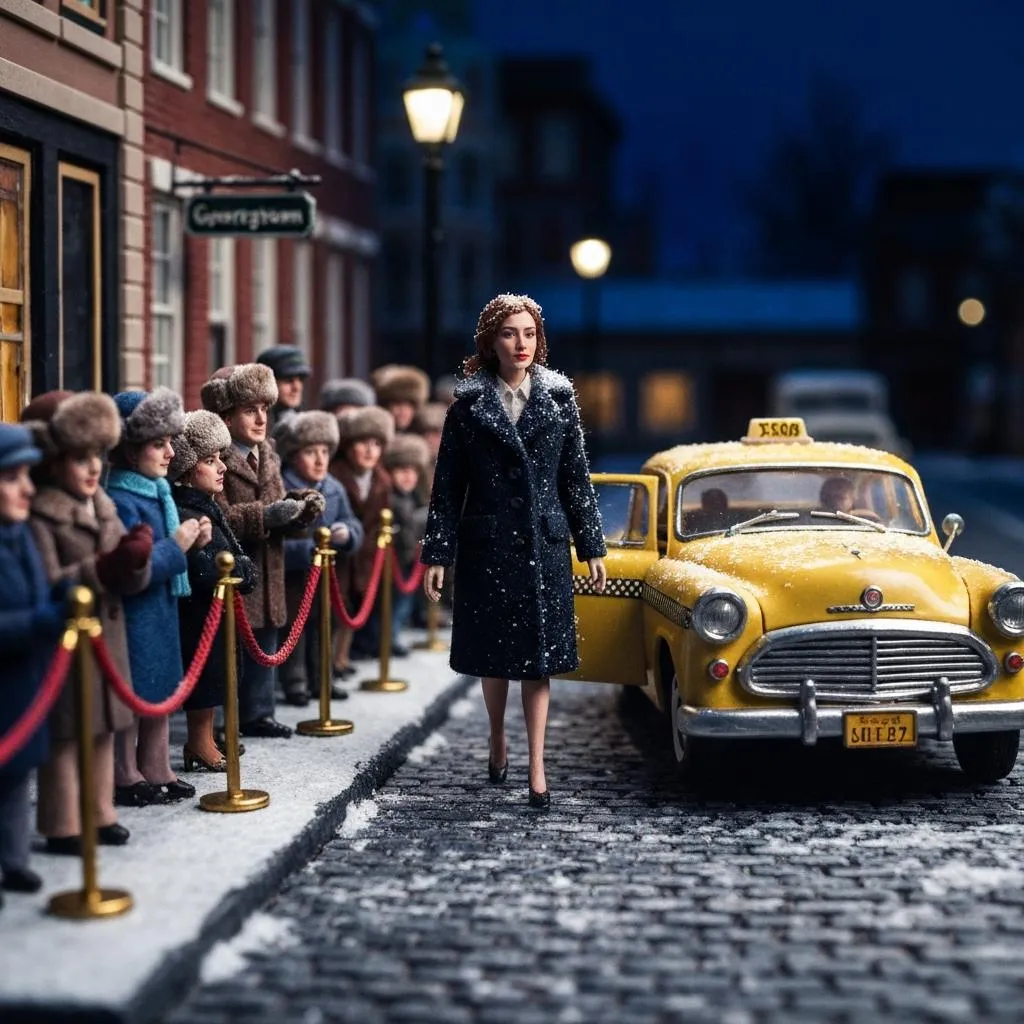

In [26]:
scene_view.select(
    scene_view.scene_image,
    scene_view.scene_image.localpath
).limit(1).collect()

If any rows encountered errors during processing (rate limits, API issues, etc.), you can recompute just those rows where Pixeltable logged errors:

In [27]:
# Recompute any rows that had errors
scene_view.recompute_columns(
    scene_view.scene_image,
    errors_only=True
)

No rows affected.

## 06 - (Optional) Video Generation

This section demonstrates two ways to use Gemini for video generation. Video generation is slower and more expensive than text or image generation. At the time of this workshop, the code we provide here should keep you safely in the free tier of four videos per day.

- **Image Input: Generate Videos from Image Only** - Slower, simpler approach (`veo-3.1-generate-preview`)
- **Multimodal Inputs: Generate Videos from Prompt + Image** - Slower, more tokens, production quality (`veo-3.1-generate-preview`)

### Image Input: Animate an Image (No Text Prompt)

This simpler approach animates the frame without a text prompt - just the image itself.

In [38]:
scene_animation = scene_view.where(scene_view.pos == 7).select(
    scene_view.beginning_frame,
    scene_view.scene_image,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.scene_image.resize((640, 640)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

beginning_frame,scene_image,animated_video
,,
,,

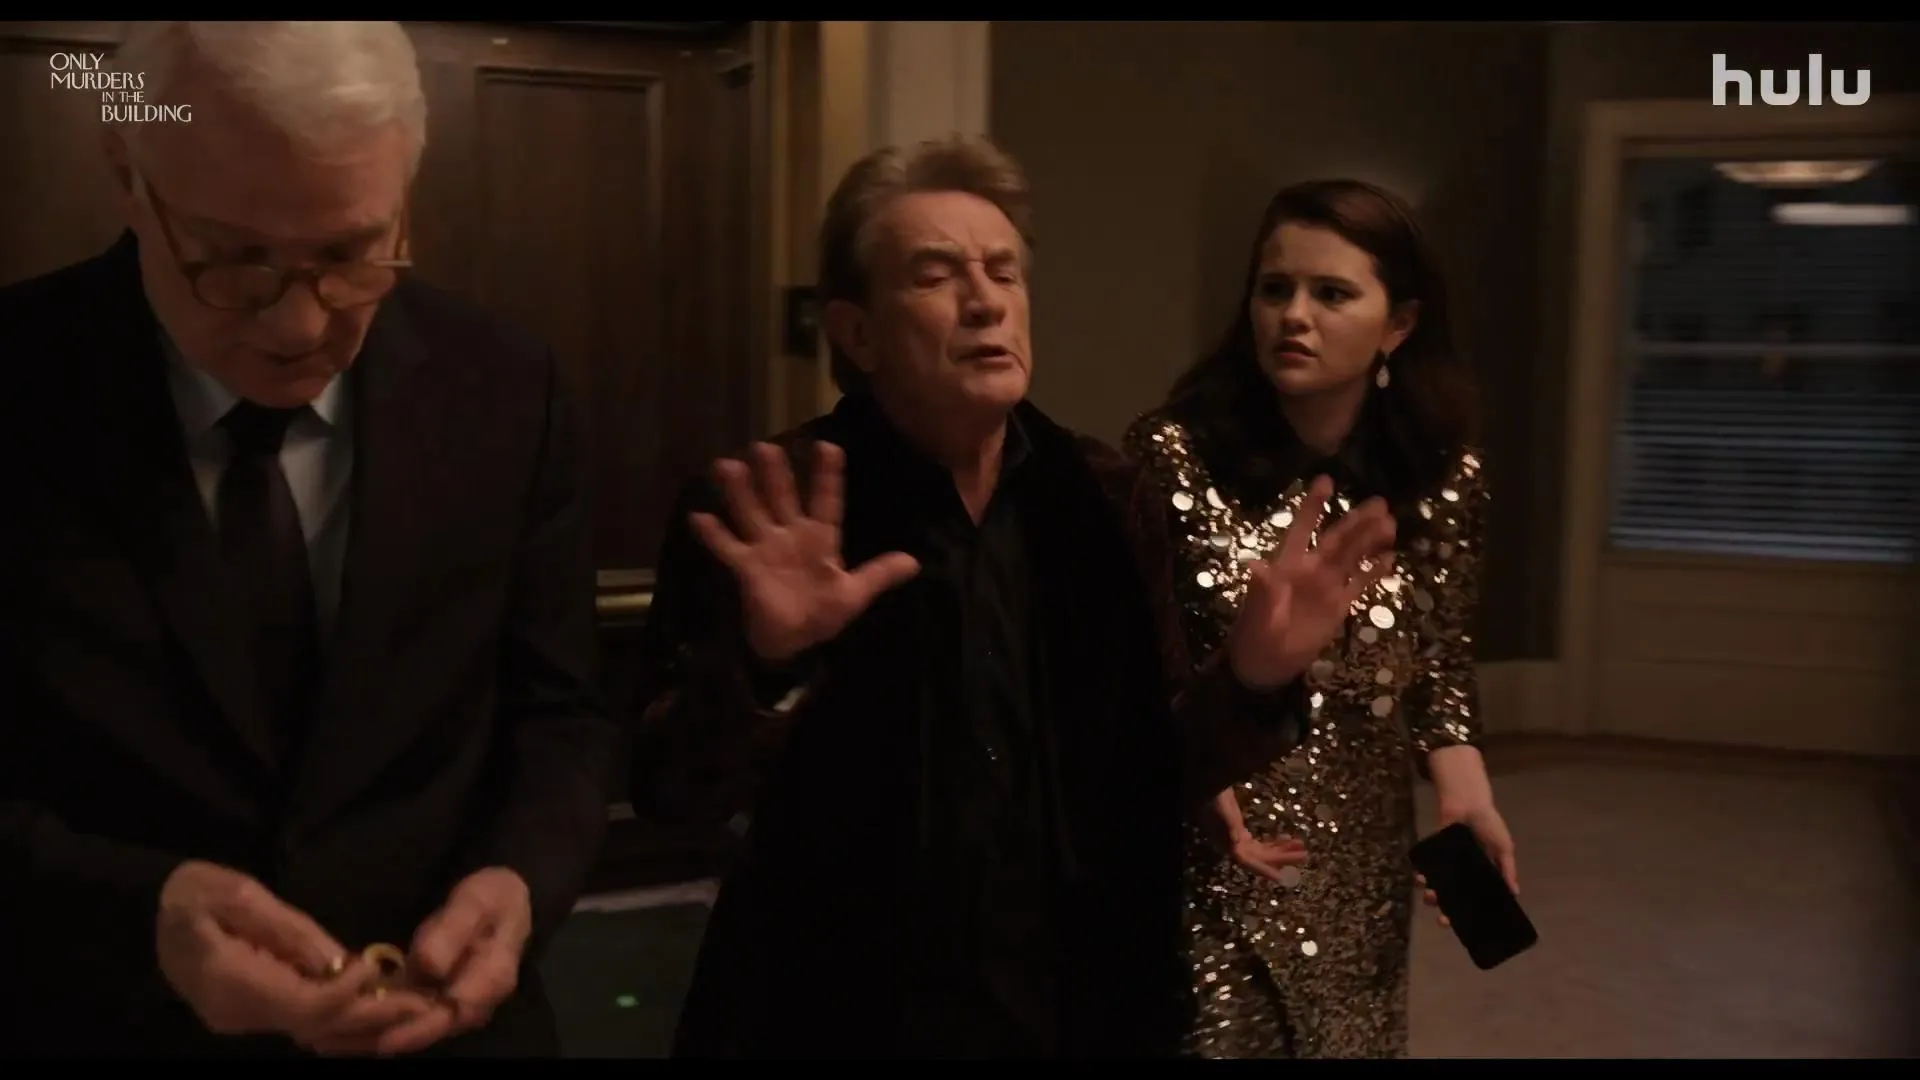
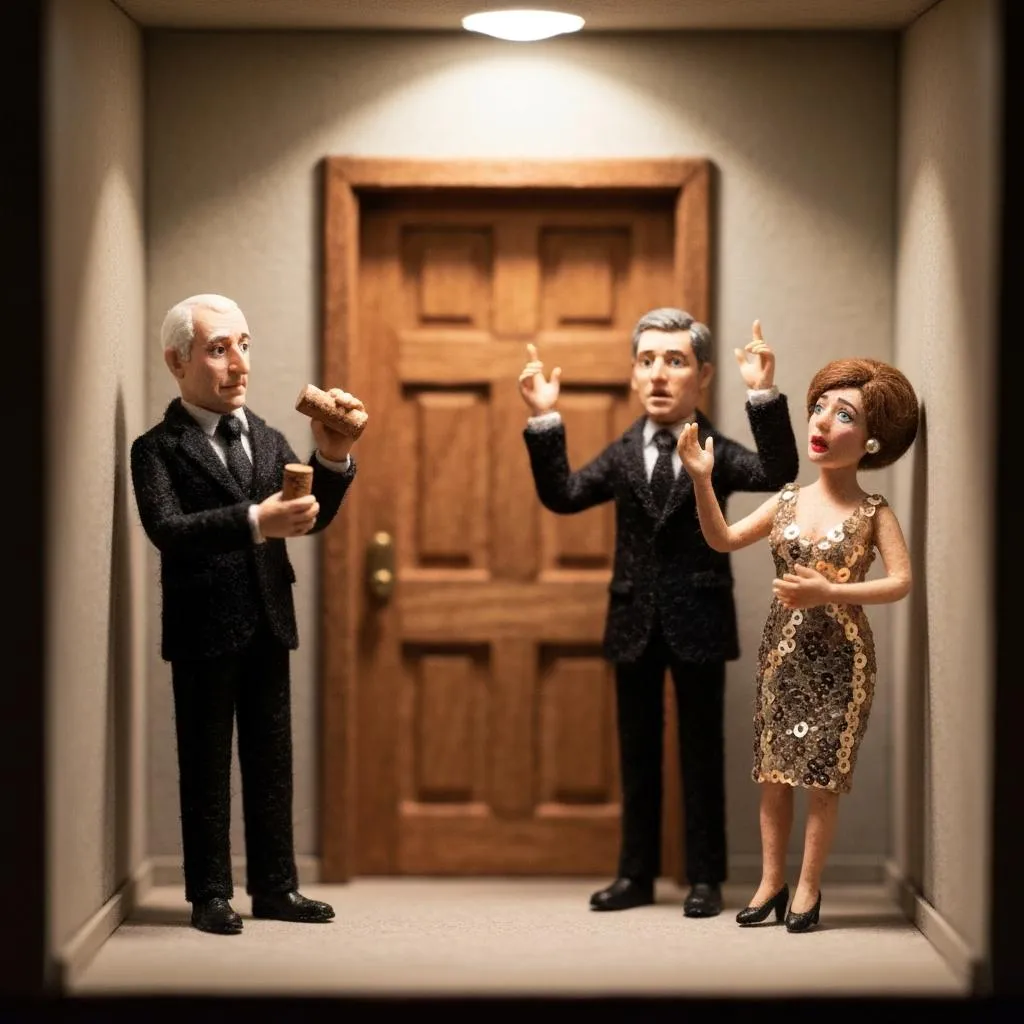
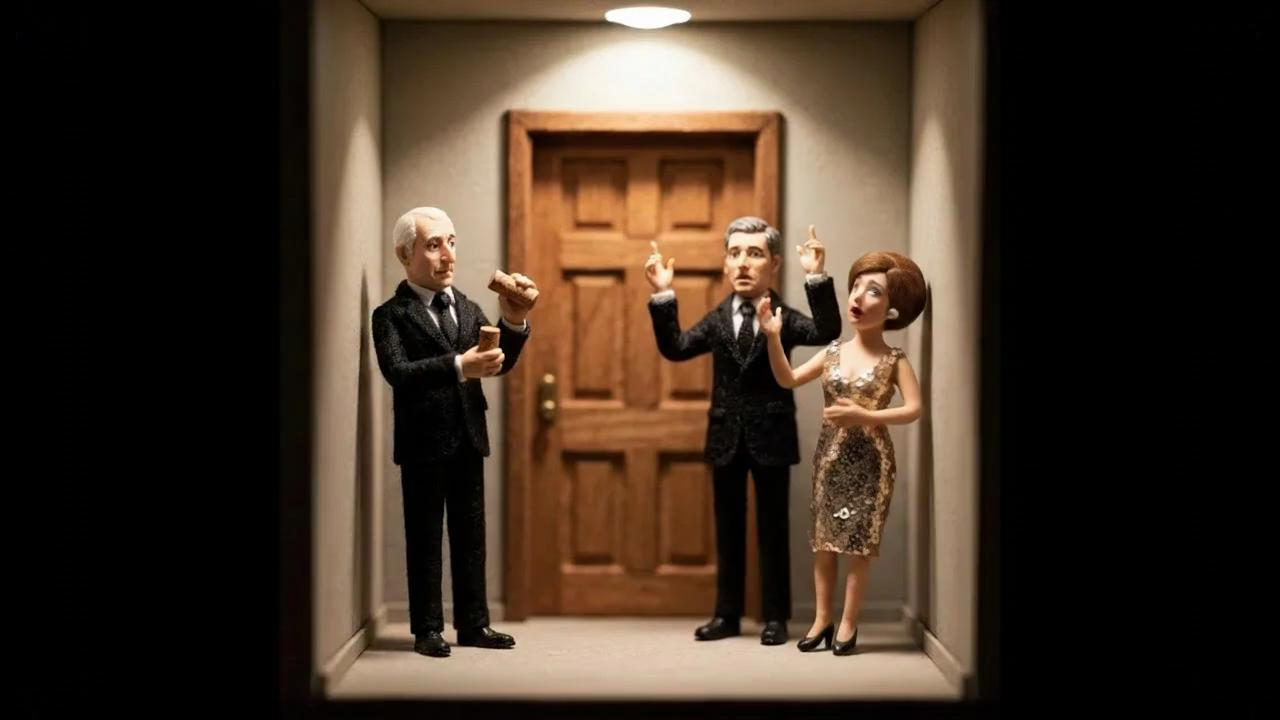
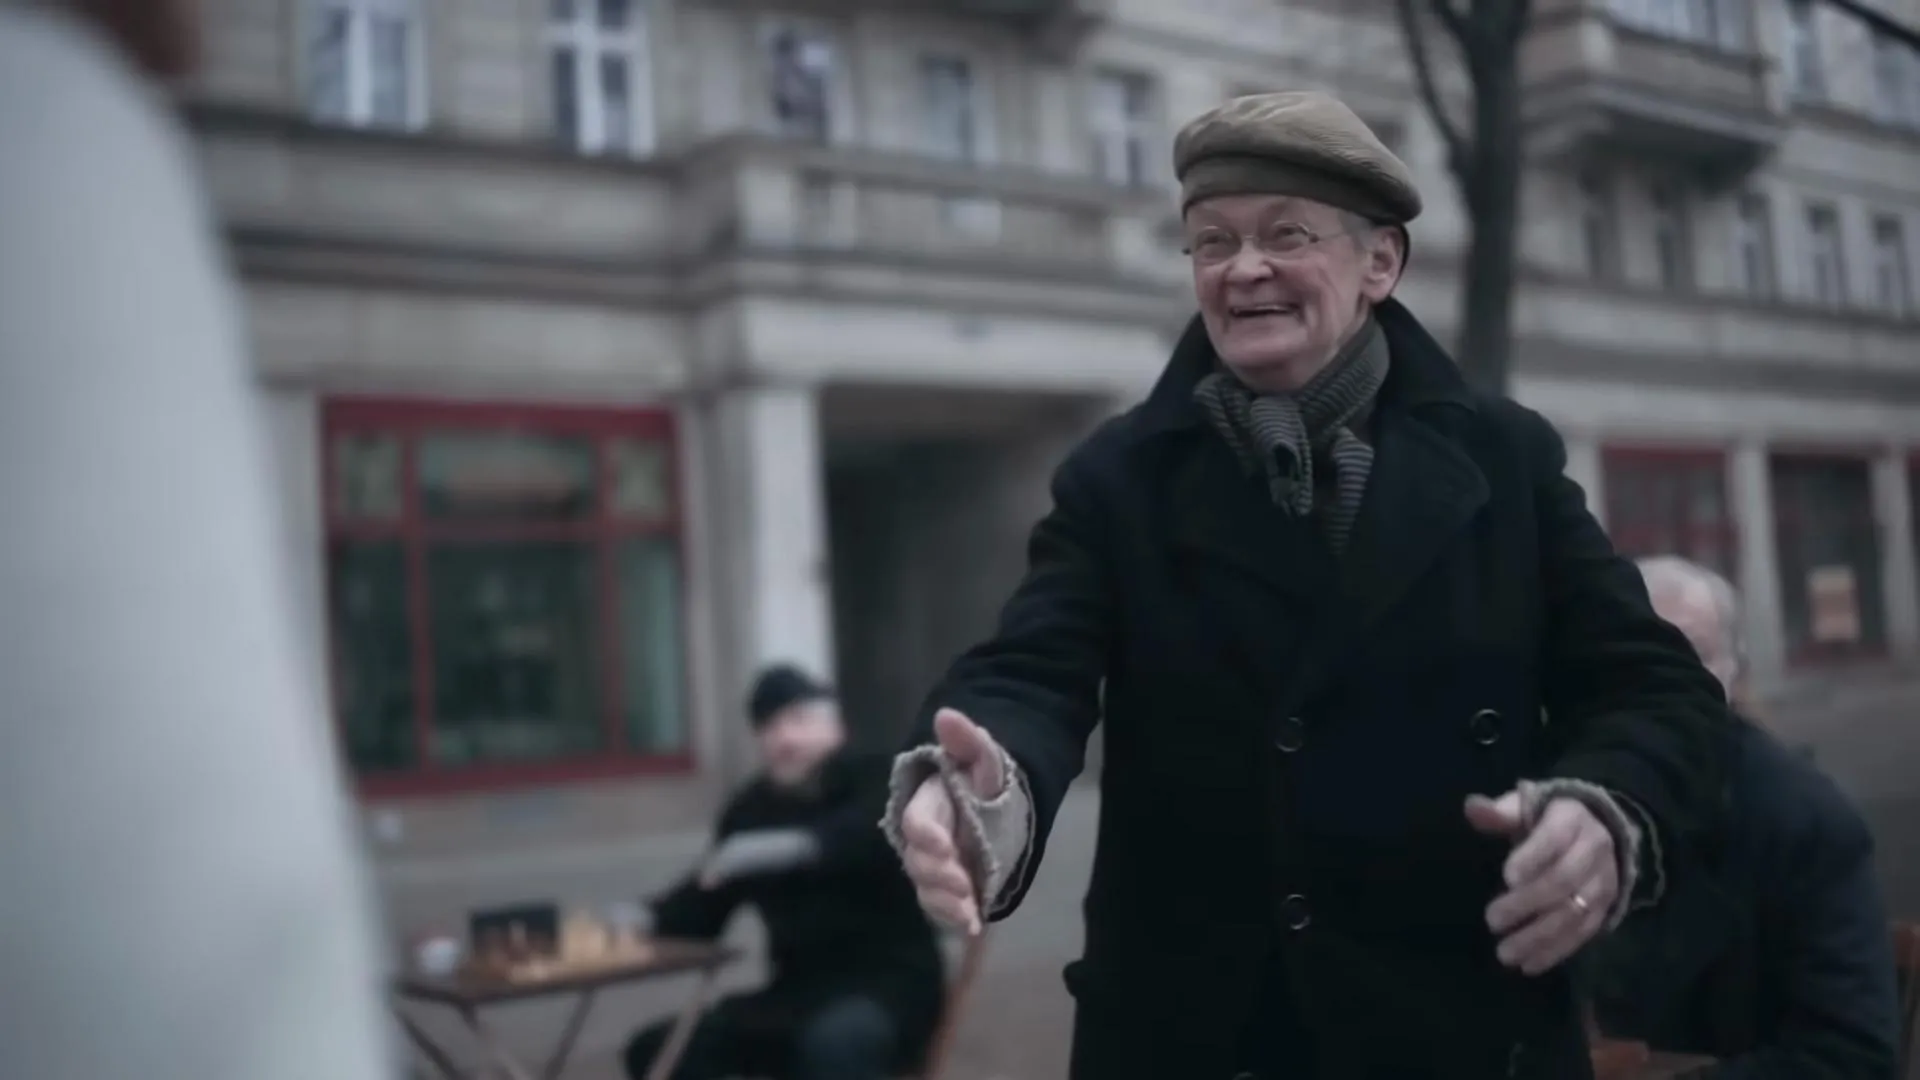
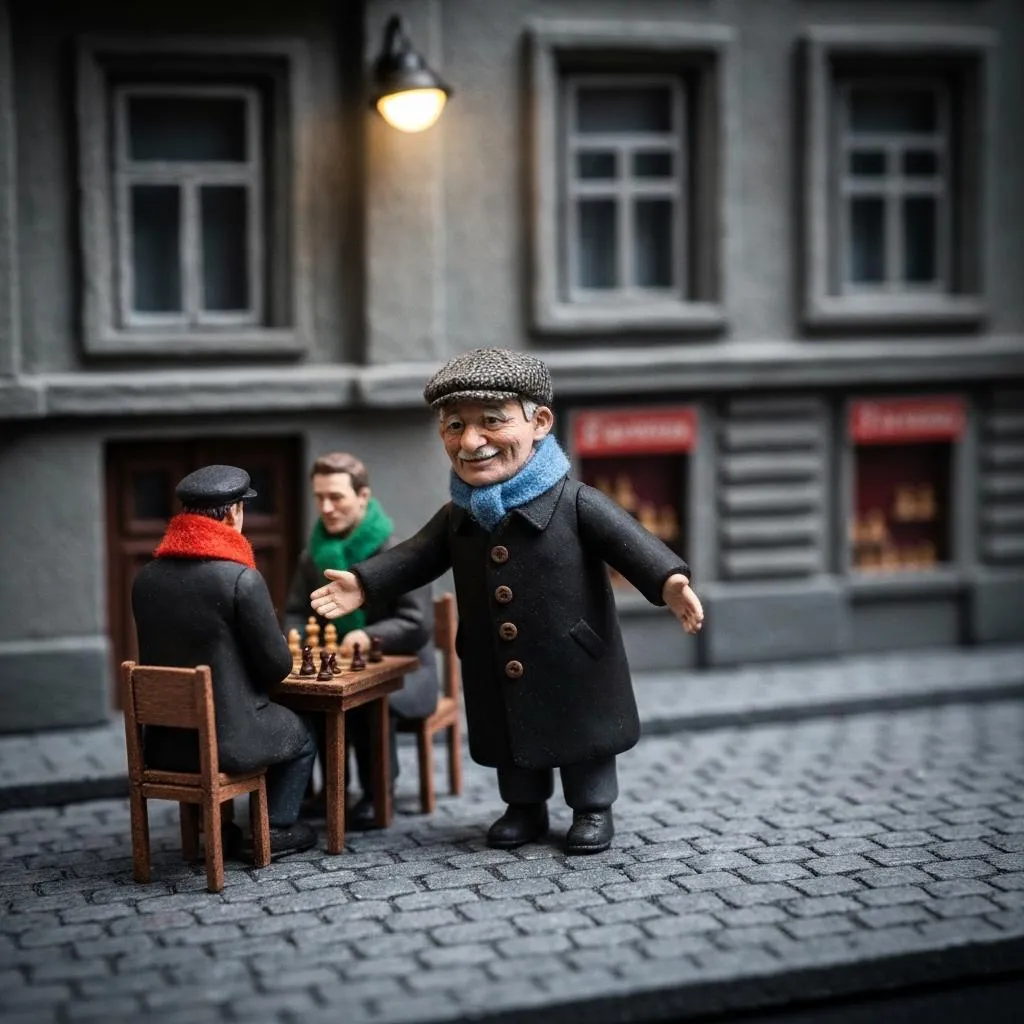
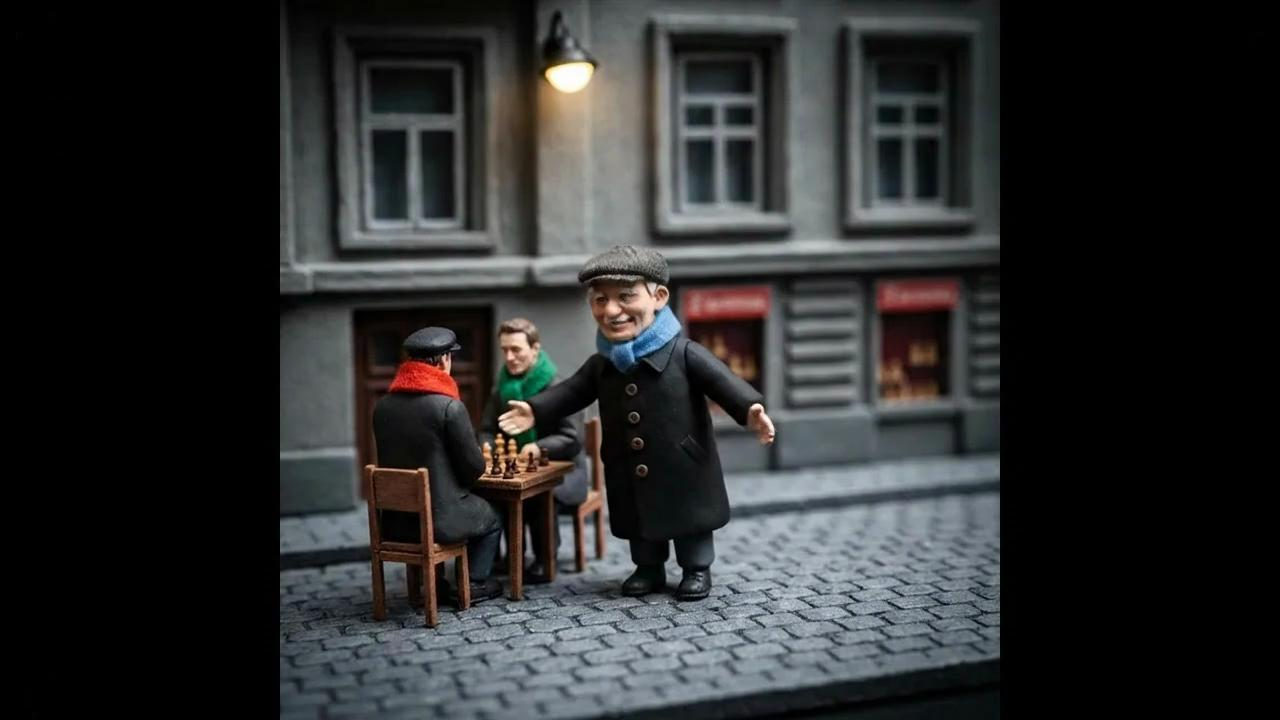

In [39]:
scene_animation

### Multimodal Inputs: Generate a Video from Prompt + Image

Test video generation using both the `scene_prompt` and the `scene_image`. Save the results of this query in memory as `scene_trailer`.

In [36]:
scene_trailer = scene_view.where(scene_view.pos == 7).select(
    scene_view.scene_image,
    scene_view.scene_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.scene_prompt,
        image=scene_view.scene_image.resize((640, 640)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

scene_image,scene_prompt,trailer_video
,"An intricate miniature diorama of a hallway scene from ""Only Murders in the Building"", featuring three handcrafted miniature figures: Charles in a dark suit meticulously holding a wine cork, Oliver gesturing with both hands raised, and Mabel in a sequined dress looking bewildered. The diorama includes a miniature wooden door behind them. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, eye-level perspective, dramatic miniature lighting emphasizing the characters' faces and the hallway's details with soft, warm spotlights mimicking interior lighting. Tiny handcrafted details: individual sequins on Mabel’s dress, realistic folds in Charles and Oliver’s felt clothing, and wood grain in the door. Materials: felt, clay, wood. The color palette is predominantly beige and brown, with a glint of gold from Mabel's dress. The mood is both humorous and slightly suspenseful, capturing the essence of the show.",
,"An intricate miniature diorama of an outdoor chess scene in Moscow during the Cold War, inspired by ""The Queen's Gambit."" An elderly man in a black coat and tweed cap, sculpted from clay, reaches out his hand in greeting, a warm smile on his tiny face. Behind him, two men are seated at a miniature chess table crafted from wood, pieces meticulously arranged. Background shows a building with detailed window frames and architectural details. Photographed with a tilt-shift lens creating selectiv ...... nd building softened. Dramatic miniature lighting, a single warm spotlight highlighting the man's face, casting long, soft shadows. Tiny handcrafted details include felt scarves and minuscule buttons on the coats, cobblestone street made of painted clay. Color palette: muted grays, browns, and hints of red in the storefront details, creating a melancholic yet charming atmosphere. Mood: a heartwarming moment of camaraderie amid a stark and cold environment, cinematic and charmingly handmade.",

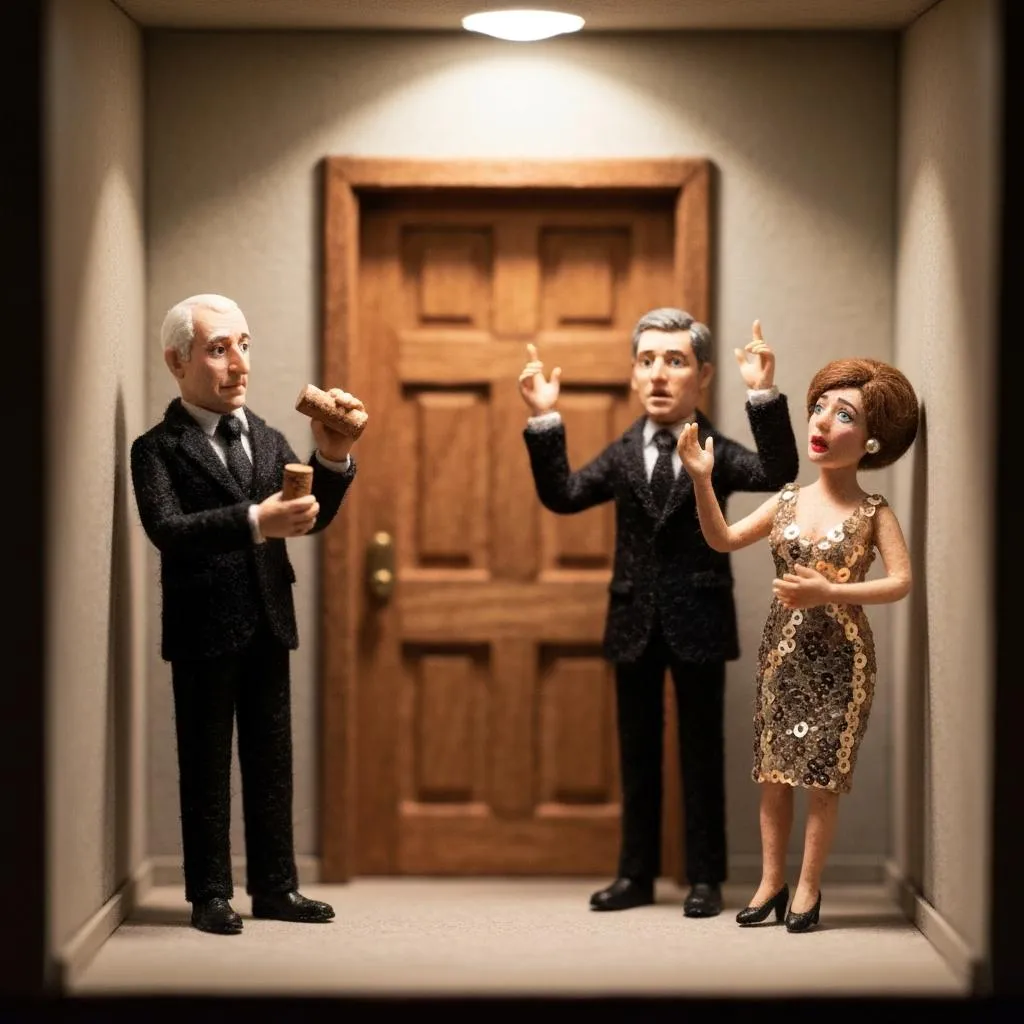
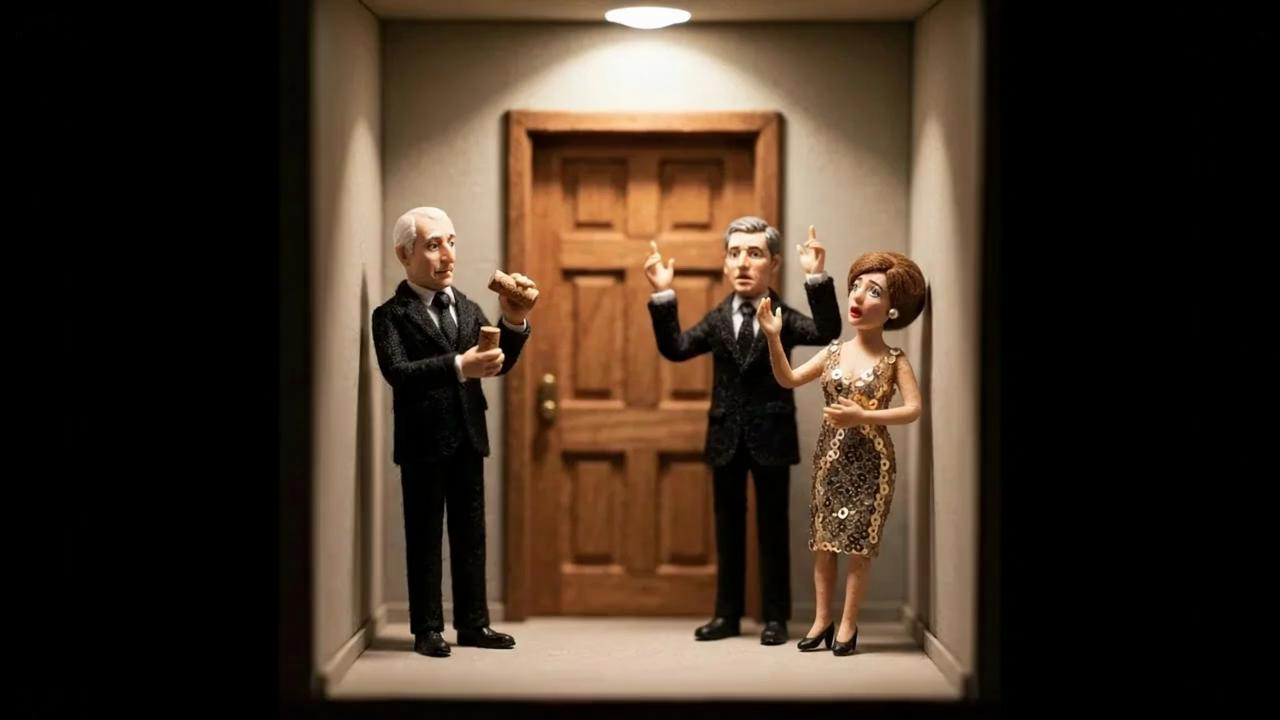
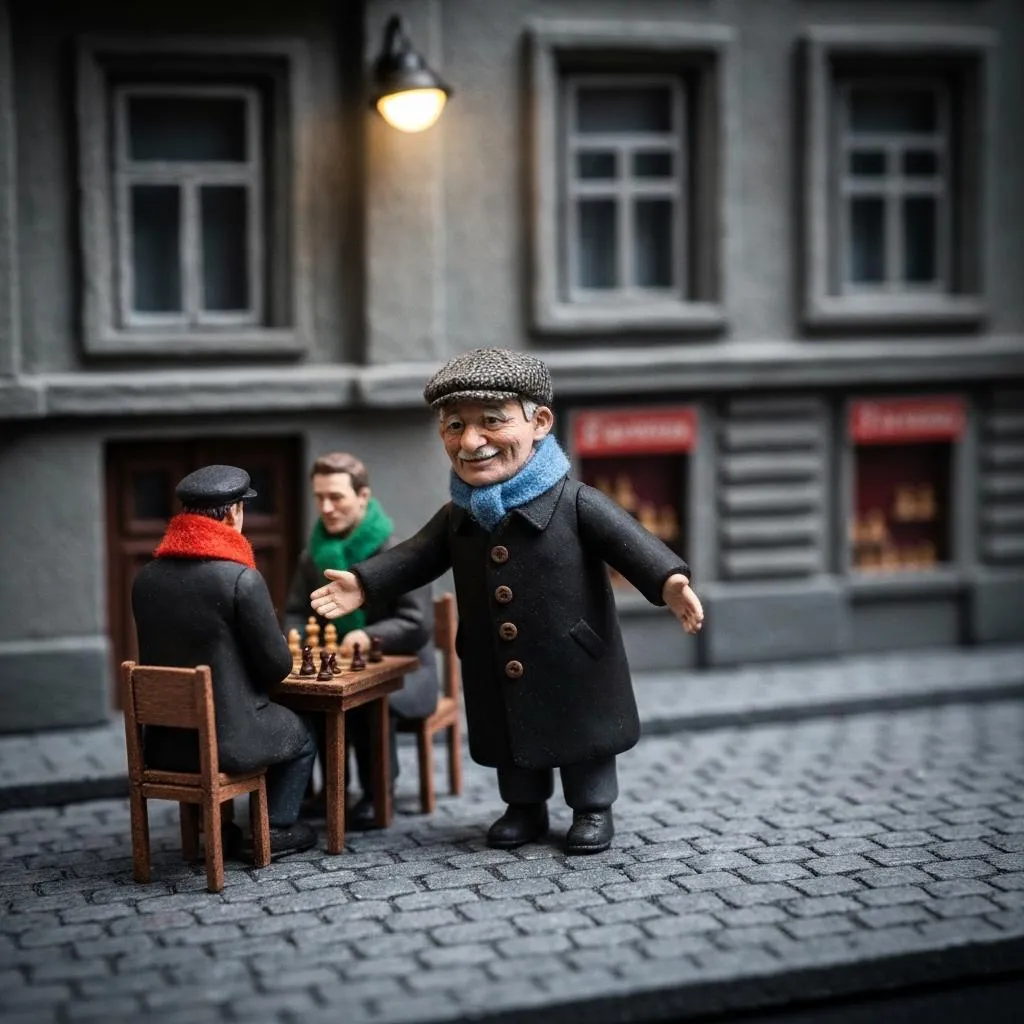
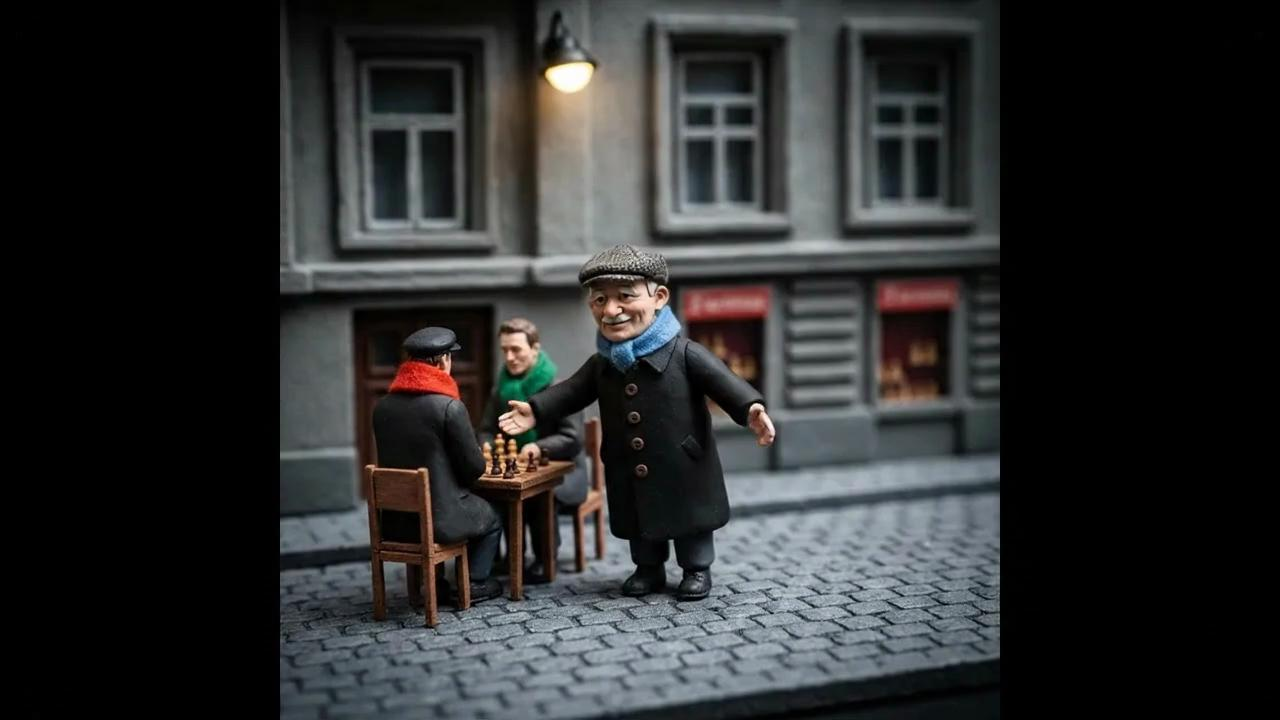

In [37]:
scene_trailer

## Wrap-Up

**Across this three-part workshop, you built a complete multimodal AI pipeline:**

- **Act 1**: Visual search - Extract frames, create embeddings, search by image or text
- **Act 2**: Audio search - Detect scenes, transcribe audio, search by semantic meaning
- **Act 3**: Content generation - Chain AI models to create new images and videos

In Act 3, you built a content generation pipeline that chains AI models together using computed columns:

```
┌─────────────────────────────────────────────────────────────────────────────────────────────┐
│  INPUT              EXTRACT           ANALYZE              GENERATE IMAGE      ANIMATE      │
│                                                                                             │
│  ┌────────┐        ┌────────┐        ┌─────────────┐      ┌─────────────┐    ┌──────────┐   │
│  │ Scene  │───────▶│ Frame  │───────▶│  Multimodal │─────▶│   Imagen    │───▶│   Veo    │   │
│  │ Data   │        │        │        │  AI (Gemini)│      │     4.0     │    │   3.1    │   │
│  └────────┘        └────────┘        └─────────────┘      └─────────────┘    └──────────┘   │
│     │                  │                    │                     │                 │       │
│     │                  │                    │                     │                 │       │
│  Metadata:          Image              Text Prompt            Image             Video       │
│  • video            frame from         combining:             from              from        │
│  • title            scene              • frame                prompt            image +     │
│  • promo                               • title                                  prompt      │
│  • transcript                          • promo                                              │
│                                        • transcript                                         │
│                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added content generation to your video pipeline. Act 1 gave you visual similarity search (find frames by what they look like). Act 2 gave you semantic audio search (find scenes by what's being said). Act 3 gives you generative AI (create new promotional content from any scene).

Together, these three capabilities form a complete multimodal system. The embeddings from Act 1 power visual search. The scene detection and transcription from Act 2 structure the video data and make it searchable by audio. Act 3 chains multiple AI models—Gemini analyzes frames and transcripts to write prompts, Imagen generates images from those prompts, and Veo can animate them into video clips.

**Each step is declarative:**
- **Input**: Scene data from `scene_view` (built in Act 2)
- **Extract**: Frame extraction via computed column processes all scenes
- **Generate**: AI models chain together via computed columns—Gemini's output becomes Imagen's input
- **Cascade**: When you add new videos to `primetime_vids`, the scene detection, transcription, and generation pipeline processes them

The workflow applies to all data. If you load another video tomorrow, the same pipeline that processed your first video will process the new one.

Now let's generate images for all scenes using our `scene_prompt` column:

In [ ]:
scene_view.add_computed_column(
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-generate-001'
    ),
    if_exists='replace',
    on_error='ignore'
)

You can also generate a video-specific prompt by passing `content_type='video'` to include claymation-style instructions:

In [ ]:
scene_video_claymation = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    # Generate a video-specific prompt with claymation instructions
    video_prompt=build_scene_prompt(
        scene_view.title,
        scene_view.promo_text,
        scene_view.transcript_text,
        content_type='video'
    ),
    # Use the video prompt with Gemini
    scene_video=extract_text(
        pxtf.gemini.generate_content(
            contents=[
                build_scene_prompt(
                    scene_view.title,
                    scene_view.promo_text,
                    scene_view.transcript_text,
                    content_type='video'
                ),
                scene_view.beginning_frame
            ],
            model='gemini-2.0-flash'
        )
    )
).collect()

View the generated images alongside the prompts:

In [ ]:
scene_view.select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()